In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os, pprint, pickle, math, time, platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# import mrcnn.utils     as utils
# import mrcnn.visualize as visualize

pp = pprint.PrettyPrinter(indent=2, width=100)
print('Current working dir: ', os.getcwd())
if '..' not in sys.path:
    print("appending '..' to sys.path")
    sys.path.append('..')
    
import mrcnn.calculate_map as cmap
import mrcnn.calculate_map_2 as cmap2
import mrcnn.utils          as utils
from mrcnn.visualize import plot_precision_recall


eval_method = '1'
syst = platform.system()
if syst == 'Windows':
    MAP_PATH = "E:/git_projs/MRCNN3/train_newshapes/BCE3_eval_method"+eval_method+"_results"
elif syst == 'Linux':
#     MAP_PATH = "/home/kbardool/mrcnn3/train_newshapes/BCE3_eval_method"+eval_method+"_results"
    MAP_PATH    = "/home/kbardool/mrcnn3/train_newshapes/BCE3_test_results"
    DIR_WEIGHTS = '/home/kbardool/models_newshapes/train_fcn8L2_BCE/fcn20181224T0000' 
else :
    raise Error('unrecognized system ')

print(' OS ' , syst, ' : ', MAP_PATH)

# files = ['fcn_0001.h5', 'fcn_0150.h5', 'fcn_0346.h5', 'fcn_0421.h5', 'fcn_0450.h5', 
#          'fcn_0521.h5', 'fcn_0687.h5', 'fcn_0793.h5', 'fcn_0821.h5', 'fcn_0940.h5', 
#          'fcn_1012.h5', 'fcn_1127.h5', 'fcn_1644.h5', 'fcn_1776.h5', 'fcn_1848.h5', 
#          'fcn_2017.h5', 'fcn_2084.h5']   #idx 13,14,15,16,17

# files       = ['fcn_0500.h5']

# files   = ['fcn_0001.h5', 'fcn_0022.h5', 'fcn_0057.h5', 'fcn_0092.h5',
#            'fcn_0101.h5', 'fcn_0220.h5', 'fcn_0290.h5', 'fcn_0304.h5',
#            'fcn_0372.h5', 'fcn_0423.h5', 'fcn_0500.h5', 'fcn_0530.h5',
#            'fcn_0578.h5', 'fcn_0648.h5']        

# Files for BCE3 - Training with newly designed heatmap layer(adding FPs to the class channels)
files  = ['fcn_0001.h5', 'fcn_0003.h5', 'fcn_0005.h5', 'fcn_0009.h5', 
          'fcn_0012.h5', 'fcn_0020.h5', 'fcn_0023.h5', 'fcn_0027.h5', 
          'fcn_0033.h5', 'fcn_0047.h5', 'fcn_0070.h5', 'fcn_0080.h5', 
          'fcn_0101.h5', 'fcn_0106.h5', 'fcn_0112.h5', 'fcn_0124.h5', 
          'fcn_0138.h5', 'fcn_0144.h5', 'fcn_0161.h5', 'fcn_0171.h5', 'fcn_0181.h5']


COLORS = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']    

CLASS_NAMES = ['ALL CLASSES', 'person', 'car', 'sun','building', 'tree', 'cloud']
CLASS_IDS = [1,2,3,4,5,6] 

Current working dir:  /home/kbardool/git_projs/mrcnn3/notebooks
appending '..' to sys.path
 OS  Linux  :  /home/kbardool/mrcnn3/train_newshapes/BCE3_test_results


Using TensorFlow backend.


In [2]:
print(MAP_PATH)
FILE_IDX = 0
epochs = files[FILE_IDX].split('_')[1].replace('.h5','')
print(files[FILE_IDX], '    ', epochs)


/home/kbardool/mrcnn3/train_newshapes/BCE3_test_results
fcn_0001.h5      0001


#### `dev_filter_by_class()`
02-14-2019 : Added this to verify that the filter by class is functioning properly, which was verfified  --

In [2]:
def dev_filter_by_class(gt_boxes, pr_boxes, class_ids):
    assert class_ids is not None
    if not isinstance(class_ids, list):
        class_ids = [class_ids]
        
    pr_keys_len = len(pr_boxes.keys())
    gt_keys_len = len(gt_boxes.keys())
    assert pr_keys_len == gt_keys_len,  "Number of keys in two input dicts don't match"
    print(' # pr keys :', pr_keys_len, '# gt_keys: ', gt_keys_len)

    output_gt_boxes = {}
    output_pr_boxes = {}
    
    for class_id in class_ids:
        print(' Processing class : ', class_id)
        pr_boxes_class = {}
        gt_boxes_class = {}
        for key in gt_boxes.keys():
            kk = [ i  for i,j in enumerate(gt_boxes[key]['class_ids']) if j == class_id]
            jj = [ i  for i,j in enumerate(pr_boxes[key]['class_ids']) if j == class_id]
            if (len(kk) == len(jj) == 0 ):
    #             print(' Nothing found for this class_id, skip this entry')
                continue
            pr_boxes_class[key] = {}
            for sub_key in pr_boxes[key].keys():
    #             print('Key: ' , key, 'sub_key: ',sub_key)
                pr_boxes_class[key].setdefault(sub_key, [pr_boxes[key][sub_key][j]     for j in jj])

            gt_boxes_class[key] = {"boxes"    : [gt_boxes[key]['boxes'][k]     for k in kk],
                                   "class_ids" : [gt_boxes[key]['class_ids'][k] for k in kk] }
        output_gt_boxes[class_id] = gt_boxes_class
        output_pr_boxes[class_id] = pr_boxes_class
        # print(key)
        # print('indexes for gt_boxes: ', kk)
        # print('indexes for pr_boxes: ', jj)        
#         print('gt_boxes     : ',[gt_boxes[key]['boxes'][k] for k in kk])
#         print('gt_class_ids : ',[gt_boxes[key]['class_ids'][k] for k in kk])
#         print('pr_boxes     : ',[pr_boxes[key]['boxes'][j] for j in jj])
#         print('pr_scores    : ',[pr_boxes[key]['scores'][j] for j in jj])
#         print('pr_class_ids : ',[pr_boxes[key]['class_ids'][j] for j in jj])
                    
    return output_gt_boxes, output_pr_boxes 


## Load previously build `map_info_epochxxxx`  file

### Load previously built  `gt_boxes`, `pr_boxes`, and `cls_info` data structures 

In [3]:
# MAP_PATH = "/home/kbardool/mrcnn3/train_newshapes/BCE3_eval_method"+eval_method+"_results"
# MAP_PATH = "/home/kbardool/mrcnn3/train_newshapes/BCE3_test_results"    
#     cls_info_file = 'eval'+eval_method+'_cls_info_epoch' +epochs+'_500.pkl'
#     pr_boxes_file = 'eval'+eval_method+'_pr_bboxes_epoch'+epochs+'_500.pkl'
#     gt_boxes_file = 'eval'+eval_method+'_gt_bboxes_epoch'+epochs+'_500.pkl'

FILE_IDX = 3
epochs = files[FILE_IDX].split('_')[1].replace('.h5','')

cls_info_file = 'test_cls_info_epoch' +epochs+'_500.pkl'
pr_boxes_file = 'test_pr_bboxes_epoch'+epochs+'_500.pkl'
gt_boxes_file = 'test_gt_bboxes_epoch'+epochs+'_500.pkl' 

with open(os.path.join(MAP_PATH, cls_info_file), 'rb') as infile:
    cls_info = pickle.load(infile)            
with open(os.path.join(MAP_PATH, pr_boxes_file), 'rb') as infile:
    pr_boxes = pickle.load(infile)
with open(os.path.join(MAP_PATH, gt_boxes_file), 'rb') as infile:
    gt_boxes = pickle.load(infile)
print('loaded :', cls_info_file, '   ', pr_boxes_file, '    ', gt_boxes_file)    

loaded : test_cls_info_epoch0009_500.pkl     test_pr_bboxes_epoch0009_500.pkl      test_gt_bboxes_epoch0009_500.pkl


In [7]:
# FILE_IDX= 0
# epochs = files[FILE_IDX].split('_')[1].replace('.h5','')

# map_info_file = 'eval'+eval_method+'_map_info_epoch'+epochs+'.pkl'
# cls_info_file = 'eval'+eval_method+'_cls_info_epoch'+epochs+'_500.pkl'

# with open(os.path.join(MAP_PATH, map_info_file), 'rb') as infile:
#     all_data = pickle.load(infile)            

# with open(os.path.join(MAP_PATH, cls_info_file), 'rb') as infile:
#     cls_info = pickle.load(infile)                
# print('loaded :', map_info_file, '   ', cls_info_file)    

loaded : eval1_map_info_epoch0001.pkl     eval1_cls_info_epoch0001_500.pkl


### Load previously build `map_info_epochxxxx`  file

In [4]:
map_info_file = 'test_map_info_epoch' +epochs+'.pkl'
with open(os.path.join(MAP_PATH, map_info_file), 'rb') as infile:
    all_data = pickle.load(infile)             
print('loaded :', map_info_file)    


loaded : test_map_info_epoch0009.pkl


###  Use `filter_by_class()` to generate gt_boxes_class and pr_boxes_class

In [5]:
# gt_boxes_class, pr_boxes_class = filter_by_class(gt_boxes, pr_boxes, class_id= 2)
gt_boxes_class, pr_boxes_class  = cmap.filter_by_class(gt_boxes, pr_boxes, class_ids= CLASS_IDS)
print(' GT Boxes: ', len(gt_boxes.keys()),  ' PR Boxes:'      , len(pr_boxes.keys()))
for i in pr_boxes_class:
    print(' Class : ',i,' ', len(pr_boxes_class[i].keys()), len(gt_boxes_class[i].keys()))
# print(pr_boxes_class[3].keys())
# print(gt_boxes_class[3].keys())

 # pr keys : 500 # gt_keys:  500
 Processing class :  1
 Processing class :  2
 Processing class :  3
 Processing class :  4
 Processing class :  5
 Processing class :  6
 GT Boxes:  500  PR Boxes: 500
 Class :  1   348 348
 Class :  2   353 353
 Class :  3   342 342
 Class :  4   348 348
 Class :  5   335 335
 Class :  6   360 360


## Develop Build Mean Average Precision Data Structure 

Using loaded gt_boxes and pr_boxes.
    ALL_DATA is a dictionary keyed by class_id to dictionaries, one for each possible score. Each SCORE dictionary is itrself a dictionary with keys for iOUs 
    between 0.5 and 0.95. Each dictionary entry has the following keys:
    {'iou', 'model_thrs', 'recalls', 'precisions', 'avg_prec'}
    iou :         indicates the iOU threshold of the dictionary entry
    model_thrs:   score thresholds
    recalls   :   recall at threshold
    precision :   precision at threshold


- Create `gt_boxes_class`, `pr_boxes_class` (separated by class)  - 

### Build mAP data structure 

In [3]:
     ## build gt_boxes_class, pr_boxes_class which only containing info for each class
    class_ids = [1,2,3,4,5,6]    
    scores    = [ 'mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
    iou_thresholds = np.arange(0.20, 0.95, 0.05)
    
    all_data = gt_boxes_class = pr_boxes_class = {}
    gt_boxes_class, pr_boxes_class  = cmap.filter_by_class(gt_boxes, pr_boxes, class_ids= class_ids)

    all_data = cmap.build_mAP_data_structure_by_class(gt_boxes_class, pr_boxes_class, class_ids, scores, iou_thresholds)
    all_data[0] = cmap.build_mAP_data_structure_combined(gt_boxes, pr_boxes, scores, iou_thresholds)

    print(all_data.keys())

    ### Save mAP data to file `map_info_epochxxxx.pkl` for future reuse

    map_info_file = 'eval'+eval_method+'_map_info_epoch'+epochs+'.pkl'
    with open(os.path.join(MAP_PATH, map_info_file), 'wb') as outfile:
        pickle.dump(all_data, outfile)            
    print(' Datafile :', map_info_file , ' saved')

loaded : eval1_cls_info_epoch0001_500.pkl     eval1_pr_bboxes_epoch0001_500.pkl      eval1_gt_bboxes_epoch0001_500.pkl
 # pr keys : 500 # gt_keys:  500
 Processing class :  1
 Processing class :  2
 Processing class :  3
 Processing class :  4
 Processing class :  5
 Processing class :  6
Build mAP information for classes:  [1, 2, 3, 4, 5, 6]  and scores  ['mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
class_id:   1  
class_id:   2  
class_id:   3  
class_id:   4  
class_id:   5  
class_id:   6  
Build mAP (all classes combined)  
 For scores:  ['mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
 score_key: mrcnn_score_orig        iou_thr: 0.20  (idx  0)  
 score_key: mrcnn_score_orig        iou_thr: 0.25  (idx  1)  
 score_key: mrcnn_score_orig        iou_thr: 0.30  (idx  2)  
 score_key: mrcnn_score_orig        i

dict_keys([0, 1, 2, 3, 4, 5, 6])
 Datafile : eval1_map_info_epoch0001.pkl  saved


In [4]:
FILE_IDX = 0
epochs = files[FILE_IDX].split('_')[1].replace('.h5','')

cls_info_file = 'test_cls_info_epoch' +epochs+'_500.pkl'
pr_boxes_file = 'test_pr_bboxes_epoch'+epochs+'_500.pkl'
gt_boxes_file = 'test_gt_bboxes_epoch'+epochs+'_500.pkl'

with open(os.path.join(MAP_PATH, cls_info_file), 'rb') as infile:
    cls_info = pickle.load(infile)            
with open(os.path.join(MAP_PATH, pr_boxes_file), 'rb') as infile:
    pr_boxes = pickle.load(infile)
with open(os.path.join(MAP_PATH, gt_boxes_file), 'rb') as infile:
    gt_boxes = pickle.load(infile)

print('loaded :', cls_info_file, '   ', pr_boxes_file, '    ', gt_boxes_file)    

loaded : test_cls_info_epoch0001_500.pkl     test_pr_bboxes_epoch0001_500.pkl      test_gt_bboxes_epoch0001_500.pkl


## Data Structure displays

### display `cls_info` 

In [5]:
print(len(cls_info))
print(' Keys: ', cls_info[0].keys())
print('score           :' , cls_info[1]['scores'][:20])
print('mrcnn_score_orig:', cls_info[1]['mrcnn_score_orig'][:20])
print('mrcnn_score_norm:',cls_info[1]['mrcnn_score_norm'][:20])
print()
print('mrcnn_score_0',cls_info[1]['mrcnn_score_0'][:20])
print('mrcnn_score_1',cls_info[1]['mrcnn_score_1'][:20])
print('mrcnn_score_2',cls_info[1]['mrcnn_score_2'][:20])
 

7
 Keys:  dict_keys(['fcn_score_2_norm', 'id', 'mrcnn_score_orig', 'mrcnn_score_norm', 'fcn_score_1_norm', 'mrcnn_score_1', 'mrcnn_score_0', 'mrcnn_score_1_norm', 'bboxes', 'scores', 'mrcnn_score_2_norm', 'fcn_score_2', 'name', 'fcn_score_1', 'mrcnn_score_2', 'fcn_score_0'])
score           : [0.997, 0.7888, 0.9994, 0.9962, 0.8363, 0.981, 0.979, 0.9038, 0.9997, 0.8228, 0.9993, 0.9974, 0.9886, 0.9092, 0.6947, 0.6199, 0.9899, 0.9882, 0.9811, 0.7377]
mrcnn_score_orig: [0.997, 0.7888, 0.9994, 0.9962, 0.8363, 0.981, 0.979, 0.9038, 0.9997, 0.8228, 0.9993, 0.9974, 0.9886, 0.9092, 0.6947, 0.6199, 0.9899, 0.9882, 0.9811, 0.7377]
mrcnn_score_norm: [1.0, 0.7911, 1.0, 0.9968, 0.8368, 1.0, 0.998, 0.9213, 1.0, 0.8231, 1.0, 0.9981, 0.9893, 0.9098, 0.6952, 0.6204, 1.0, 1.0, 0.9928, 0.7465]

mrcnn_score_0 [0.9319, 0.6913, 0.9499, 0.9017, 0.7313, 0.9047, 0.9056, 0.8052, 0.95, 0.7194, 0.9323, 0.9063, 0.8979, 0.795, 0.6843, 0.5972, 0.9324, 0.9319, 0.9014, 0.6949]
mrcnn_score_1 [0.6592, 0.4831, 0.7115, 0.6

### display `gt_boxes` and `pr_boxes` for a range of images

In [90]:
pr_keys = list(pr_boxes.keys())
gt_keys = list(gt_boxes.keys())
# cls_keys= cls_info
# print(gt_boxes.keys())
print(len(gt_boxes.keys()), len(pr_boxes.keys()), len(cls_info))
print(len(gt_keys), gt_keys[:10])
print(len(pr_keys), pr_keys[:10])
print('keys for GT :', gt_boxes[gt_keys[0]].keys())
print('keys for PR :', pr_boxes[pr_keys[0]].keys())
print()

for i in range(5):
    print(' Filename key   : ',pr_keys[i])
    print('------------------------------------')
    print(' PR Boxes   : ')
    print('   Boxes    : ', pr_boxes[pr_keys[i]]['boxes'])
    print('   Scores   : ', pr_boxes[pr_keys[i]]['scores'])
    print('   Class Ids: ', pr_boxes[pr_keys[i]]['class_ids'])
    print('   DetInd   : ', pr_boxes[pr_keys[i]]['det_ind'])
    print()
    print(' GT Boxes   : ')
    print('   Boxes    : ', gt_boxes[gt_keys[i]]['boxes'])
    print('   Class Ids: ', gt_boxes[gt_keys[i]]['class_ids'])
    print()

500 500 7
500 ['newshapes_00124', 'newshapes_00255', 'newshapes_00428', 'newshapes_00085', 'newshapes_00122', 'newshapes_00466', 'newshapes_00281', 'newshapes_00005', 'newshapes_00043', 'newshapes_00471']
500 ['newshapes_00124', 'newshapes_00255', 'newshapes_00428', 'newshapes_00085', 'newshapes_00122', 'newshapes_00466', 'newshapes_00281', 'newshapes_00005', 'newshapes_00043', 'newshapes_00471']
keys for GT : dict_keys(['boxes', 'class_ids'])
keys for PR : dict_keys(['fcn_score_1', 'scores', 'fcn_score_0', 'mrcnn_score_norm', 'boxes', 'fcn_score_2_norm', 'mrcnn_score_0', 'mrcnn_score_1_norm', 'det_ind', 'mrcnn_score_orig', 'mrcnn_score_1', 'class_ids', 'fcn_score_2', 'fcn_score_1_norm', 'mrcnn_score_2', 'mrcnn_score_2_norm'])

 Filename key   :  newshapes_00124
------------------------------------
 PR Boxes   : 
   Boxes    :  [[59.0, 72.0, 73.0, 105.0], [11.0, 8.0, 29.0, 26.0], [54.0, 32.0, 105.0, 68.0]]
   Scores   :  [0.9999, 0.9997, 1.0]
   Class Ids:  [2, 3, 4]
   DetInd   :  [1.

### This code whether mrcnn_score_1 and mrcnn_score2 match or not

In [16]:
ttl = 0
for key in sorted(pr_keys[:1000]):  ##  'newshapes_00115'
    test = pr_boxes[key]['mrcnn_score_orig'] == pr_boxes[key]['scores']
    ttl +=1 
    if not test:
        print(key, '  ' ,  test)
        print('      - ', pr_boxes[key]['mrcnn_score_1'])
        print('        ', pr_boxes[key]['mrcnn_score_2'])
print('checked :', ttl)        

checked : 500


In [33]:
# # class_data = all_data[1]
# # score_key = 'scores'
# # for idx, iou_key in enumerate(sorted(class_data[score_key])):
# #     print(idx, iou_key)
# bb = [0.7777, 0.7569, 0.6442, 0.4946, 0.3545, 0.1565, 0.0654, 0.0264, 0.005]
# avg_precs = [" {:10.4f}".format(ap) for ap in bb]
# # avg_precs = [str(ap) for ap in bb]
# b1 = ""
# print(b1.join(avg_precs))

###  Print gt_boxes and pr_boxes for a image - and the class filtered gt_boxes and pr_boxes

In [91]:
key = 'newshapes_00001'
print(' gt class ids: ',gt_boxes[key]['class_ids'])
print(' pr class ids: ',pr_boxes[key]['class_ids'])

# pp.pprint(gt_boxes[key])
# print()
# print('pr_boxes')
# pp.pprint(pr_boxes[key])
# print()

i = 3
print('Class  ',i)
print('GT_boxes :')
pp.pprint(gt_boxes_class[i][key])
print('PR_boxes :')
pp.pprint(pr_boxes_class[i][key])

print(pr_boxes[key]['class_ids'])
# pr_boxes[key]['class_ids'][0] = 3   ## change from 3 to 1
# print(pr_boxes[key]['class_ids'])
# gt_boxes[key]['class_ids'][0] = 3   ## change from 3 to 1
# print(gt_boxes[key]['class_ids'])

 gt class ids:  [3, 6, 4, 4, 4, 5, 5, 5]
 pr class ids:  [3, 4, 4, 4, 5, 5, 5, 6]
Class   3
GT_boxes :
{'boxes': [[14, 90, 33, 109]], 'class_ids': [3]}
PR_boxes :
{ 'boxes': [[14.0, 89.0, 33.0, 109.0]],
  'class_ids': [3],
  'det_ind': [1.0],
  'fcn_score_0': [1.1246],
  'fcn_score_1': [0.0045],
  'fcn_score_1_norm': [1.0],
  'fcn_score_2': [0.3681],
  'fcn_score_2_norm': [1.0],
  'mrcnn_score_0': [0.9961],
  'mrcnn_score_1': [0.6649],
  'mrcnn_score_1_norm': [1.0],
  'mrcnn_score_2': [0.6649],
  'mrcnn_score_2_norm': [1.0],
  'mrcnn_score_norm': [1.0],
  'mrcnn_score_orig': [0.999],
  'scores': [0.999]}
[3, 4, 4, 4, 5, 5, 5, 6]


### Print / compare  Boxes and Boxes_Class:

In [20]:
pr_keys = list(pr_boxes.keys())
gt_keys = list(gt_boxes.keys())
cls = 3
ttl_missing = 0

for i in range(10):
    pr_key = pr_keys[i]
    gt_key = gt_keys[i]
    assert pr_key == gt_key
    print('\n Key   : ', pr_key)
    print('------------------------------------')
    if pr_key not in pr_boxes_class[cls] or gt_key not in gt_boxes_class[cls]:
        ttl_missing += 1
#         print(' Key ', pr_key, 'Missing in one of the filtered files')
        print('    PR: ', pr_key, 'doesnt have any detections:', pr_boxes[pr_key]['class_ids'])
        print('    GT: ', gt_key, 'doesnt have any detections:', gt_boxes[gt_key]['class_ids'])

    else:
        print(' PR Info: ', pr_key)

        print('   Boxes      : ', pr_boxes[pr_key]['boxes'])
        print('   Scores     : ', pr_boxes[pr_key]['scores'])
        print('   score_orig : ', pr_boxes[pr_key]['mrcnn_score_orig'])
        print('   Class Ids  : ', pr_boxes[pr_key]['class_ids'])
        print('   DetInd     : ', pr_boxes[pr_key]['det_ind'])
        print(' * Filtered by class: ')
        print('   Boxes      : ', len(pr_boxes_class[cls][pr_key]['boxes'])    , pr_boxes_class[cls][pr_key]['boxes'])
        print('   Scores     : ', len(pr_boxes_class[cls][pr_key]['scores'])   , sorted(pr_boxes_class[cls][pr_key]['scores']))
        print('   score_orig : ', len(pr_boxes_class[cls][pr_key]['mrcnn_score_orig']),pr_boxes_class[cls][pr_key]['mrcnn_score_orig'])
        print('   Class Ids  : ', len(pr_boxes_class[cls][pr_key]['class_ids']), pr_boxes_class[cls][pr_key]['class_ids'])
        print('   DetInd     : ', len(pr_boxes_class[cls][pr_key]['det_ind'])  , pr_boxes_class[cls][pr_key]['det_ind'])
        print()
        print(' GT Info   : ', gt_key)
        print('   Boxes    : ', gt_boxes[gt_key]['boxes'])
        print('   Class Ids: ', gt_boxes[gt_key]['class_ids'])
        print(' * Filtered by class: ')
        print('   Boxes    : ', len(gt_boxes_class[cls][gt_key]['boxes'])    , gt_boxes_class[cls][gt_key]['boxes'])
        print('   Class Ids: ', len(gt_boxes_class[cls][gt_key]['class_ids']), gt_boxes_class[cls][gt_key]['class_ids'])
        print()        
print(' Total Missing :', ttl_missing)        


 Key   :  newshapes_00245
------------------------------------
 PR Info:  newshapes_00245
   Boxes      :  [[60.0, 55.0, 79.0, 60.0], [93.0, 75.0, 118.0, 128.0], [11.0, 96.0, 26.0, 112.0], [39.0, 51.0, 74.0, 80.0], [38.0, 93.0, 68.0, 118.0]]
   Scores     :  [0.9992, 0.9999, 0.9995, 1.0, 1.0]
   score_orig :  [0.9992, 0.9999, 0.9995, 1.0, 1.0]
   Class Ids  :  [1, 2, 3, 4, 4]
   DetInd     :  [1.0, 1.0, 1.0, 1.0, 1.0]
 * Filtered by class: 
   Boxes      :  1 [[11.0, 96.0, 26.0, 112.0]]
   Scores     :  1 [0.9995]
   score_orig :  1 [0.9995]
   Class Ids  :  1 [3]
   DetInd     :  1 [1.0]

 GT Info   :  newshapes_00245
   Boxes    :  [[11, 97, 26, 112], [38, 93, 67, 118], [41, 51, 76, 78], [58, 56, 81, 61], [92, 71, 119, 128]]
   Class Ids:  [3, 4, 4, 1, 2]
 * Filtered by class: 
   Boxes    :  1 [[11, 97, 26, 112]]
   Class Ids:  1 [3]


 Key   :  newshapes_00001
------------------------------------
 PR Info:  newshapes_00001
   Boxes      :  [[14.0, 89.0, 33.0, 109.0], [44.0, 31.0, 

In [ ]:

# for img_id in pred_boxes.keys():
#     arg_sort = np.argsort(pred_boxes[img_id]['scores'])
#     pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
#     pred_boxes[img_id]['boxes']  = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

# print(type(class_pr_info), type(pr_boxes))    
# pr_keys = list(gt_boxes.keys())
# print(len(pr_keys))
# pp.pprint(class_pr_info[6].keys())

# class_stats  = {}
# class_stats.setdefault('avg', [cls['avg'] for cls in class_pr_info])
# class_stats.setdefault('pct', [cls['percentiles'] for cls in class_pr_info])   
# pp.pprint(class_stats)

# print(len(pr_keys), pr_keys[0])
# print(pr_boxes[pr_keys[0]])

# print(pred_boxes[pr_keys[0]])
# print(len(gt_boxes.keys()))

#### display of gt_boxes_class, pr_boxes_class

In [21]:
# gt_boxes_class, pr_boxes_class = filter_by_class(gt_boxes, pr_boxes, class_id= 5)
# gt_boxes_class, pr_boxes_class = filter_by_class_2(gt_boxes, pr_boxes, class_id= 2)

print(type(gt_boxes_class), type(pr_boxes_class))
pr_boxes_class_keys = list(pr_boxes_class.keys())
gt_boxes_class_keys = list(gt_boxes_class.keys())

print(' boxes keys: ', len(gt_boxes.keys()), len(pr_boxes.keys()))
print('gt_boxes_class_keys: ', len(gt_boxes_class_keys), gt_keys[:10])
print('pr_boxes_class_keys: ', len(pr_boxes_class_keys), pr_keys[:10])
for i in gt_boxes_class_keys:
    pr_class_keys = list(pr_boxes_class[i].keys())
    gt_class_keys = list(gt_boxes_class[i].keys())

    print('class_keys for cls: ',i, len(gt_class_keys), len(pr_class_keys), pr_class_keys[:10])
#     print('pr_boxes_class_keys for class : ',i, len(pr_boxes_class[i].keys()), pr_boxes_class[i].keys()[:10])
    

<class 'dict'> <class 'dict'>
 boxes keys:  500 500
gt_boxes_class_keys:  6 ['newshapes_00245', 'newshapes_00001', 'newshapes_00051', 'newshapes_00397', 'newshapes_00385', 'newshapes_00166', 'newshapes_00384', 'newshapes_00134', 'newshapes_00480', 'newshapes_00064']
pr_boxes_class_keys:  6 ['newshapes_00245', 'newshapes_00001', 'newshapes_00051', 'newshapes_00397', 'newshapes_00385', 'newshapes_00166', 'newshapes_00384', 'newshapes_00134', 'newshapes_00480', 'newshapes_00064']
class_keys for cls:  1 348 348 ['newshapes_00245', 'newshapes_00385', 'newshapes_00384', 'newshapes_00134', 'newshapes_00480', 'newshapes_00064', 'newshapes_00223', 'newshapes_00449', 'newshapes_00159', 'newshapes_00143']
class_keys for cls:  2 353 353 ['newshapes_00245', 'newshapes_00385', 'newshapes_00166', 'newshapes_00384', 'newshapes_00134', 'newshapes_00480', 'newshapes_00064', 'newshapes_00449', 'newshapes_00159', 'newshapes_00143']
class_keys for cls:  3 342 342 ['newshapes_00245', 'newshapes_00001', 'new

In [22]:
# pp.pprint(pr_boxes['newshapes_00002'])
class_id = 3

for key in list(gt_boxes_class[class_id].keys())[:10]:
    print('-----------------------')
    print('Key: ', key)
    print('-----------------------')
    print(' PR_BOXES_CLASS[class_id][key]', type(pr_boxes_class[class_id][key]))
    pp.pprint(pr_boxes_class[class_id][key])
    print()
    print(' GT_BOXES_CLASS[class_id][key]', type(gt_boxes_class[class_id][key]))
    pp.pprint(gt_boxes_class[class_id][key])

-----------------------
Key:  newshapes_00245
-----------------------
 PR_BOXES_CLASS[class_id][key] <class 'dict'>
{ 'boxes': [[11.0, 96.0, 26.0, 112.0]],
  'class_ids': [3],
  'det_ind': [1.0],
  'fcn_score_0': [0.6919],
  'fcn_score_1': [0.0045],
  'fcn_score_1_norm': [1.0],
  'fcn_score_2': [0.4229],
  'fcn_score_2_norm': [1.0],
  'mrcnn_score_0': [0.9882],
  'mrcnn_score_1': [0.6772],
  'mrcnn_score_1_norm': [1.0],
  'mrcnn_score_2': [0.6772],
  'mrcnn_score_2_norm': [1.0],
  'mrcnn_score_norm': [1.0],
  'mrcnn_score_orig': [0.9995],
  'scores': [0.9995]}

 GT_BOXES_CLASS[class_id][key] <class 'dict'>
{'boxes': [[11, 97, 26, 112]], 'class_ids': [3]}
-----------------------
Key:  newshapes_00001
-----------------------
 PR_BOXES_CLASS[class_id][key] <class 'dict'>
{ 'boxes': [[14.0, 89.0, 33.0, 109.0]],
  'class_ids': [3],
  'det_ind': [1.0],
  'fcn_score_0': [1.1246],
  'fcn_score_1': [0.0045],
  'fcn_score_1_norm': [1.0],
  'fcn_score_2': [0.3681],
  'fcn_score_2_norm': [1.0],
  

#### Code

In [ ]:

# class_ids     = [10, 11, 12, 13, 14, 15, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 69, 70, 71, 72, 73]
# Runs it for one IoU threshold


In [4]:
for cls in [1,2,3,4,5,6]:
    print('========================================')
    for i in pr_boxes_class[cls]:
        print(cls, '  ', i, len(pr_boxes_class[cls][i]['class_ids']) == len(pr_boxes_class[cls][i]['boxes']), len(pr_boxes_class[cls][i]['class_ids']), len(pr_boxes_class[cls][i]['boxes']))
        print(cls, '  ', i, len(gt_boxes_class[cls][i]['class_ids']) == len(gt_boxes_class[cls][i]['boxes']), len(gt_boxes_class[cls][i]['class_ids']), len(gt_boxes_class[cls][i]['boxes']))

1    newshapes_00232 True 4 4
1    newshapes_00232 True 2 2
1    newshapes_00388 True 8 8
1    newshapes_00388 True 4 4
1    newshapes_00483 True 8 8
1    newshapes_00483 True 4 4
1    newshapes_00068 True 4 4
1    newshapes_00068 True 2 2
1    newshapes_00118 True 2 2
1    newshapes_00118 True 1 1
1    newshapes_00079 True 6 6
1    newshapes_00079 True 3 3
1    newshapes_00473 True 2 2
1    newshapes_00473 True 1 1
1    newshapes_00434 True 6 6
1    newshapes_00434 True 3 3
1    newshapes_00219 True 2 2
1    newshapes_00219 True 1 1
1    newshapes_00184 True 6 6
1    newshapes_00184 True 3 3
1    newshapes_00083 True 4 4
1    newshapes_00083 True 2 2
1    newshapes_00149 True 4 4
1    newshapes_00149 True 2 2
1    newshapes_00107 True 6 6
1    newshapes_00107 True 3 3
1    newshapes_00138 True 10 10
1    newshapes_00138 True 5 5
1    newshapes_00431 True 2 2
1    newshapes_00431 True 1 1
1    newshapes_00449 True 6 6
1    newshapes_00449 True 3 3
1    newshapes_00332 True 2 2
1    new

1    newshapes_00341 True 2 2
1    newshapes_00341 True 1 1
1    newshapes_00301 True 2 2
1    newshapes_00301 True 1 1
1    newshapes_00117 True 4 4
1    newshapes_00117 True 2 2
1    newshapes_00492 True 2 2
1    newshapes_00492 True 1 1
1    newshapes_00030 True 2 2
1    newshapes_00030 True 1 1
1    newshapes_00419 True 6 6
1    newshapes_00419 True 3 3
1    newshapes_00271 True 4 4
1    newshapes_00271 True 2 2
1    newshapes_00464 True 2 2
1    newshapes_00464 True 1 1
1    newshapes_00013 True 4 4
1    newshapes_00013 True 2 2
1    newshapes_00394 True 6 6
1    newshapes_00394 True 3 3
1    newshapes_00199 True 6 6
1    newshapes_00199 True 3 3
1    newshapes_00021 True 4 4
1    newshapes_00021 True 2 2
1    newshapes_00495 True 2 2
1    newshapes_00495 True 1 1
1    newshapes_00042 True 2 2
1    newshapes_00042 True 1 1
1    newshapes_00383 True 2 2
1    newshapes_00383 True 1 1
1    newshapes_00381 True 2 2
1    newshapes_00381 True 1 1
1    newshapes_00452 True 4 4
1    newsh

2    newshapes_00163 True 3 3
2    newshapes_00023 True 4 4
2    newshapes_00023 True 2 2
2    newshapes_00312 True 4 4
2    newshapes_00312 True 2 2
2    newshapes_00407 True 2 2
2    newshapes_00407 True 1 1
2    newshapes_00397 True 2 2
2    newshapes_00397 True 1 1
2    newshapes_00037 True 4 4
2    newshapes_00037 True 2 2
2    newshapes_00278 True 4 4
2    newshapes_00278 True 2 2
2    newshapes_00270 True 2 2
2    newshapes_00270 True 1 1
2    newshapes_00368 True 2 2
2    newshapes_00368 True 1 1
2    newshapes_00489 True 6 6
2    newshapes_00489 True 3 3
2    newshapes_00129 True 10 10
2    newshapes_00129 True 5 5
2    newshapes_00334 True 2 2
2    newshapes_00334 True 1 1
2    newshapes_00069 True 4 4
2    newshapes_00069 True 2 2
2    newshapes_00198 True 2 2
2    newshapes_00198 True 1 1
2    newshapes_00211 True 2 2
2    newshapes_00211 True 1 1
2    newshapes_00006 True 4 4
2    newshapes_00006 True 2 2
2    newshapes_00076 True 2 2
2    newshapes_00076 True 1 1
2    new

2    newshapes_00139 True 2 2
2    newshapes_00139 True 1 1
2    newshapes_00156 True 2 2
2    newshapes_00156 True 1 1
2    newshapes_00081 True 2 2
2    newshapes_00081 True 1 1
2    newshapes_00277 True 2 2
2    newshapes_00277 True 1 1
2    newshapes_00294 True 2 2
2    newshapes_00294 True 1 1
2    newshapes_00404 True 4 4
2    newshapes_00404 True 2 2
2    newshapes_00364 True 2 2
2    newshapes_00364 True 1 1
2    newshapes_00428 True 2 2
2    newshapes_00428 True 1 1
2    newshapes_00151 True 2 2
2    newshapes_00151 True 1 1
2    newshapes_00288 True 4 4
2    newshapes_00288 True 2 2
2    newshapes_00102 True 4 4
2    newshapes_00102 True 2 2
2    newshapes_00072 True 4 4
2    newshapes_00072 True 2 2
2    newshapes_00295 True 4 4
2    newshapes_00295 True 2 2
2    newshapes_00065 True 2 2
2    newshapes_00065 True 1 1
2    newshapes_00030 True 4 4
2    newshapes_00030 True 2 2
2    newshapes_00188 True 6 6
2    newshapes_00188 True 3 3
2    newshapes_00169 True 4 4
2    newsh

3    newshapes_00327 True 2 2
3    newshapes_00327 True 1 1
3    newshapes_00291 True 2 2
3    newshapes_00291 True 1 1
3    newshapes_00426 True 2 2
3    newshapes_00426 True 1 1
3    newshapes_00358 True 2 2
3    newshapes_00358 True 1 1
3    newshapes_00315 True 2 2
3    newshapes_00315 True 1 1
3    newshapes_00146 True 2 2
3    newshapes_00146 True 1 1
3    newshapes_00223 True 2 2
3    newshapes_00223 True 1 1
3    newshapes_00340 True 2 2
3    newshapes_00340 True 1 1
3    newshapes_00004 True 2 2
3    newshapes_00004 True 1 1
3    newshapes_00113 True 2 2
3    newshapes_00113 True 1 1
3    newshapes_00000 True 2 2
3    newshapes_00000 True 1 1
3    newshapes_00436 True 2 2
3    newshapes_00436 True 1 1
3    newshapes_00027 True 2 2
3    newshapes_00027 True 1 1
3    newshapes_00318 True 2 2
3    newshapes_00318 True 1 1
3    newshapes_00171 True 2 2
3    newshapes_00171 True 1 1
3    newshapes_00497 True 2 2
3    newshapes_00497 True 1 1
3    newshapes_00337 True 2 2
3    newsh

3    newshapes_00404 True 2 2
3    newshapes_00404 True 1 1
3    newshapes_00172 True 2 2
3    newshapes_00172 True 1 1
3    newshapes_00428 True 2 2
3    newshapes_00428 True 1 1
3    newshapes_00151 True 2 2
3    newshapes_00151 True 1 1
3    newshapes_00288 True 2 2
3    newshapes_00288 True 1 1
3    newshapes_00129 True 2 2
3    newshapes_00129 True 1 1
3    newshapes_00211 True 2 2
3    newshapes_00211 True 1 1
3    newshapes_00001 True 2 2
3    newshapes_00001 True 1 1
3    newshapes_00220 True 2 2
3    newshapes_00220 True 1 1
3    newshapes_00214 True 2 2
3    newshapes_00214 True 1 1
3    newshapes_00302 True 2 2
3    newshapes_00302 True 1 1
3    newshapes_00188 True 2 2
3    newshapes_00188 True 1 1
3    newshapes_00213 True 2 2
3    newshapes_00213 True 1 1
3    newshapes_00363 True 2 2
3    newshapes_00363 True 1 1
3    newshapes_00002 True 2 2
3    newshapes_00002 True 1 1
3    newshapes_00175 True 2 2
3    newshapes_00175 True 1 1
3    newshapes_00294 True 2 2
3    newsh

4    newshapes_00053 True 3 3
4    newshapes_00036 True 2 2
4    newshapes_00036 True 1 1
4    newshapes_00487 True 4 4
4    newshapes_00487 True 2 2
4    newshapes_00410 True 4 4
4    newshapes_00410 True 2 2
4    newshapes_00486 True 2 2
4    newshapes_00486 True 1 1
4    newshapes_00236 True 2 2
4    newshapes_00236 True 1 1
4    newshapes_00206 True 2 2
4    newshapes_00206 True 1 1
4    newshapes_00426 True 2 2
4    newshapes_00426 True 1 1
4    newshapes_00272 True 2 2
4    newshapes_00272 True 1 1
4    newshapes_00109 True 4 4
4    newshapes_00109 True 2 2
4    newshapes_00432 True 4 4
4    newshapes_00432 True 2 2
4    newshapes_00057 True 4 4
4    newshapes_00057 True 2 2
4    newshapes_00332 True 4 4
4    newshapes_00332 True 2 2
4    newshapes_00325 True 2 2
4    newshapes_00325 True 1 1
4    newshapes_00422 True 4 4
4    newshapes_00422 True 2 2
4    newshapes_00463 True 2 2
4    newshapes_00463 True 1 1
4    newshapes_00413 True 2 2
4    newshapes_00413 True 1 1
4    newsh

4    newshapes_00208 True 1 1
4    newshapes_00129 True 2 2
4    newshapes_00129 True 1 1
4    newshapes_00028 True 2 2
4    newshapes_00028 True 1 1
4    newshapes_00243 True 2 2
4    newshapes_00243 True 1 1
4    newshapes_00142 True 2 2
4    newshapes_00142 True 1 1
4    newshapes_00239 True 2 2
4    newshapes_00239 True 1 1
4    newshapes_00019 True 6 6
4    newshapes_00019 True 3 3
4    newshapes_00220 True 2 2
4    newshapes_00220 True 1 1
4    newshapes_00193 True 4 4
4    newshapes_00193 True 2 2
4    newshapes_00493 True 6 6
4    newshapes_00493 True 3 3
4    newshapes_00016 True 2 2
4    newshapes_00016 True 1 1
4    newshapes_00341 True 4 4
4    newshapes_00341 True 2 2
4    newshapes_00301 True 4 4
4    newshapes_00301 True 2 2
4    newshapes_00117 True 2 2
4    newshapes_00117 True 1 1
4    newshapes_00030 True 2 2
4    newshapes_00030 True 1 1
4    newshapes_00419 True 6 6
4    newshapes_00419 True 3 3
4    newshapes_00464 True 2 2
4    newshapes_00464 True 1 1
4    newsh

5    newshapes_00155 True 3 3
5    newshapes_00495 True 2 2
5    newshapes_00495 True 1 1
5    newshapes_00231 True 6 6
5    newshapes_00231 True 3 3
5    newshapes_00326 True 4 4
5    newshapes_00326 True 2 2
5    newshapes_00327 True 2 2
5    newshapes_00327 True 1 1
5    newshapes_00381 True 6 6
5    newshapes_00381 True 3 3
5    newshapes_00216 True 2 2
5    newshapes_00216 True 1 1
5    newshapes_00426 True 2 2
5    newshapes_00426 True 1 1
5    newshapes_00130 True 4 4
5    newshapes_00130 True 2 2
5    newshapes_00223 True 2 2
5    newshapes_00223 True 1 1
5    newshapes_00340 True 4 4
5    newshapes_00340 True 2 2
5    newshapes_00066 True 2 2
5    newshapes_00066 True 1 1
5    newshapes_00113 True 4 4
5    newshapes_00113 True 2 2
5    newshapes_00165 True 2 2
5    newshapes_00165 True 1 1
5    newshapes_00000 True 4 4
5    newshapes_00000 True 2 2
5    newshapes_00027 True 4 4
5    newshapes_00027 True 2 2
5    newshapes_00318 True 4 4
5    newshapes_00318 True 2 2
5    newsh

5    newshapes_00322 True 4 4
5    newshapes_00322 True 2 2
5    newshapes_00409 True 8 8
5    newshapes_00409 True 4 4
5    newshapes_00256 True 2 2
5    newshapes_00256 True 1 1
5    newshapes_00225 True 2 2
5    newshapes_00225 True 1 1
5    newshapes_00240 True 6 6
5    newshapes_00240 True 3 3
5    newshapes_00041 True 2 2
5    newshapes_00041 True 1 1
5    newshapes_00143 True 6 6
5    newshapes_00143 True 3 3
5    newshapes_00157 True 6 6
5    newshapes_00157 True 3 3
5    newshapes_00089 True 4 4
5    newshapes_00089 True 2 2
5    newshapes_00200 True 2 2
5    newshapes_00200 True 1 1
5    newshapes_00366 True 2 2
5    newshapes_00366 True 1 1
5    newshapes_00278 True 2 2
5    newshapes_00278 True 1 1
5    newshapes_00013 True 4 4
5    newshapes_00013 True 2 2
5    newshapes_00435 True 2 2
5    newshapes_00435 True 1 1
5    newshapes_00164 True 2 2
5    newshapes_00164 True 1 1
5    newshapes_00156 True 2 2
5    newshapes_00156 True 1 1
5    newshapes_00330 True 6 6
5    newsh

6    newshapes_00076 True 1 1
6    newshapes_00347 True 8 8
6    newshapes_00347 True 4 4
6    newshapes_00120 True 4 4
6    newshapes_00120 True 2 2
6    newshapes_00448 True 2 2
6    newshapes_00448 True 1 1
6    newshapes_00163 True 8 8
6    newshapes_00163 True 4 4
6    newshapes_00477 True 2 2
6    newshapes_00477 True 1 1
6    newshapes_00110 True 2 2
6    newshapes_00110 True 1 1
6    newshapes_00179 True 2 2
6    newshapes_00179 True 1 1
6    newshapes_00234 True 6 6
6    newshapes_00234 True 3 3
6    newshapes_00050 True 2 2
6    newshapes_00050 True 1 1
6    newshapes_00127 True 2 2
6    newshapes_00127 True 1 1
6    newshapes_00207 True 2 2
6    newshapes_00207 True 1 1
6    newshapes_00369 True 4 4
6    newshapes_00369 True 2 2
6    newshapes_00005 True 4 4
6    newshapes_00005 True 2 2
6    newshapes_00218 True 4 4
6    newshapes_00218 True 2 2
6    newshapes_00282 True 2 2
6    newshapes_00282 True 1 1
6    newshapes_00114 True 4 4
6    newshapes_00114 True 2 2
6    newsh

6    newshapes_00485 True 1 1
6    newshapes_00243 True 4 4
6    newshapes_00243 True 2 2
6    newshapes_00324 True 6 6
6    newshapes_00324 True 3 3
6    newshapes_00074 True 10 10
6    newshapes_00074 True 5 5
6    newshapes_00142 True 6 6
6    newshapes_00142 True 3 3
6    newshapes_00167 True 4 4
6    newshapes_00167 True 2 2
6    newshapes_00019 True 2 2
6    newshapes_00019 True 1 1
6    newshapes_00156 True 6 6
6    newshapes_00156 True 3 3
6    newshapes_00193 True 2 2
6    newshapes_00193 True 1 1
6    newshapes_00493 True 4 4
6    newshapes_00493 True 2 2
6    newshapes_00301 True 6 6
6    newshapes_00301 True 3 3
6    newshapes_00121 True 2 2
6    newshapes_00121 True 1 1
6    newshapes_00150 True 6 6
6    newshapes_00150 True 3 3
6    newshapes_00419 True 2 2
6    newshapes_00419 True 1 1
6    newshapes_00271 True 2 2
6    newshapes_00271 True 1 1
6    newshapes_00464 True 4 4
6    newshapes_00464 True 2 2
6    newshapes_00013 True 2 2
6    newshapes_00013 True 1 1
6    new

### display `all_data`

In [27]:
print(all_data.keys())
print(all_data[1].keys())
print(all_data[1]['mrcnn_score_2'].keys())
print(all_data[1]['mrcnn_score_2'][0.5].keys())

dict_keys([0, 1, 2, 3, 4, 5, 6])
dict_keys(['fcn_score_0', 'fcn_score_2', 'mrcnn_score_1', 'mrcnn_score_0', 'mrcnn_score_2', 'mrcnn_score_orig', 'mrcnn_score_2_norm', 'mrcnn_score_1_norm', 'mrcnn_score_norm', 'fcn_score_2_norm', 'fcn_score_1_norm', 'fcn_score_1'])
dict_keys([0.2, 0.25, 0.35, 0.6, 0.5, 0.7, 0.65, 0.3, 0.55, 0.8, 0.4, 0.9, 0.45, 0.85, 0.75])
dict_keys(['avg_prec', 'recalls', 'iou', 'precisions', 'model_thrs', 'prec_at_rec'])


In [29]:
cls_key   = 3
score_key = 'mrcnn_score_0'
iou_key   = 0.5
print(all_data.keys())
print(all_data[cls_key].keys())
print(all_data[cls_key][score_key].keys())
print(all_data[cls_key][score_key][iou_key].keys())
print(' iou             : ', all_data[cls_key][score_key][iou_key]['iou'])
print(' score_thresholds: ', len(all_data[cls_key][score_key][iou_key]['model_thrs']))
print(' precisions      : ', len(all_data[cls_key][score_key][iou_key]['precisions']))
print(' recalls         : ', len(all_data[cls_key][score_key][iou_key]['recalls']))
print(' prec_at_rec     : ', len(all_data[cls_key][score_key][iou_key]['prec_at_rec']))
print(' prec_at_rec     : ', all_data[cls_key][score_key][iou_key]['prec_at_rec'])

dict_keys([0, 1, 2, 3, 4, 5, 6])
dict_keys(['fcn_score_0', 'fcn_score_2', 'mrcnn_score_1', 'mrcnn_score_0', 'mrcnn_score_2', 'mrcnn_score_orig', 'mrcnn_score_2_norm', 'mrcnn_score_1_norm', 'mrcnn_score_norm', 'fcn_score_2_norm', 'fcn_score_1_norm', 'fcn_score_1'])
dict_keys([0.2, 0.25, 0.35, 0.6, 0.5, 0.7, 0.65, 0.3, 0.55, 0.8, 0.4, 0.9, 0.45, 0.85, 0.75])
dict_keys(['avg_prec', 'recalls', 'iou', 'precisions', 'model_thrs', 'prec_at_rec'])
 iou             :  0.5
 score_thresholds:  85
 precisions      :  85
 recalls         :  85
 prec_at_rec     :  11
 prec_at_rec     :  [1.0, 1.0, 0.9904306220095693, 0.9904306220095693, 0.9904306220095693, 0.9904306220095693, 0.9904306220095693, 0.9878542510121457, 0.9846153846153847, 0.9846153846153847, 0.0]


In [ ]:
# for lst in all_data[1]:
#     print(lst)
#     print(all_data[1][lst])
# #     ['iou'], lst['avg_prec'])
#     print(len(all_data[1][lst]['model_thrs']), len(all_data[1][lst]['precisions']), len(all_data[1][lst]['recalls']))

### plot mAP for one class and one threshold

Single IoU calculation took 0.5814 secs
avg precision: 0.8084
[0.5]
[0.8083785616727233]
 precisions:  (273,)
 recalls   :  (273,)
map: 80.84
avg precs:  [0.8084]
iou_thrs:   [0.5]

Plotting and calculating mAP takes 0.6595 secs


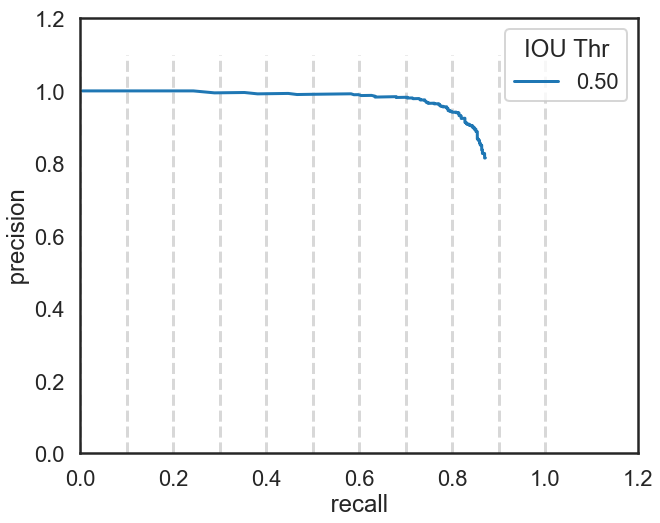

In [8]:
cls = 1

iou_thr = 0.5
start_time = time.time()
data =  cmap.get_avg_precision_at_iou(gt_boxes_class[cls], pr_boxes_class[cls], iou_thr=iou_thr, score_key = 'scores')
end_time = time.time()
print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
print('avg precision: {:.4f}'.format(data['avg_prec']))
# pp.pprint(data)

idx = 0
ax = None
avg_precs = []
iou_thrs = []
avg_precs.append(data['avg_prec'])
iou_thrs.append(iou_thr)
precisions = data['precisions']
recalls    = data['recalls']
print(iou_thrs)
print(avg_precs)
print(' precisions: ', precisions.shape)
print(' recalls   : ', recalls.shape)
ax = cmap.plot_pr_curve(precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
print('map: {:.2f}'.format(100*np.mean(avg_precs)))
print('avg precs: ', avg_precs)
print('iou_thrs:  ', iou_thrs)
plt.legend(loc='upper right', title='IOU Thr', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
end_time = time.time()
print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
plt.show()

### Display mAP one threshold (across all classes)

Single IoU calculation took 4.3709 secs
avg precision: 0.4631
[0.5]
[0.4631445460351786]
 precisions:  (36,)
 recalls   :  (36,)
map: 46.31
avg precs:  [0.4631]
iou_thrs:   [0.5]

Plotting and calculating mAP takes 4.3865 secs


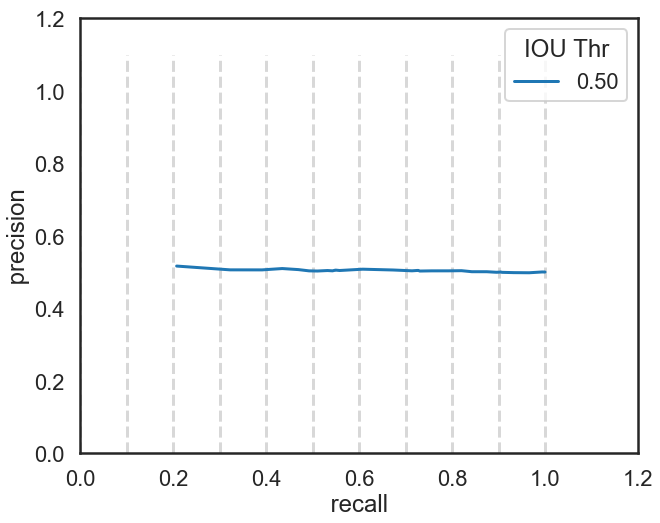

In [36]:
cls = 1

iou_thr = 0.5
start_time = time.time()
data =  cmap.get_avg_precision_at_iou(gt_boxes, pr_boxes, iou_thr=iou_thr, score_key = 'scores')
end_time = time.time()
print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
print('avg precision: {:.4f}'.format(data['avg_prec']))
# pp.pprint(data)

idx = 0
ax = None
avg_precs = []
iou_thrs = []
avg_precs.append(data['avg_prec'])
iou_thrs.append(iou_thr)
precisions = data['precisions']
recalls    = data['recalls']
print(iou_thrs)
print(avg_precs)
print(' precisions: ', precisions.shape)
print(' recalls   : ', recalls.shape)
ax = cmap.plot_pr_curve(precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
print('map: {:.2f}'.format(100*np.mean(avg_precs)))
print('avg precs: ', avg_precs)
print('iou_thrs:  ', iou_thrs)
plt.legend(loc='upper right', title='IOU Thr', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
end_time = time.time()
print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
plt.show()

## Build Mean Average Precision Data Structure 

### Build and Save `map_info_epochxxxx` file from  `gt_boxes`, `pr_boxes`, and `cls_info` data structures 
Using loaded gt_boxes and pr_boxes.
    ALL_DATA is a dictionary keyed by class_id to dictionaries, one for each possible score. Each SCORE dictionary is itrself a dictionary with keys for iOUs 
    between 0.5 and 0.95. Each dictionary entry has the following keys:
    {'iou', 'model_thrs', 'recalls', 'precisions', 'avg_prec'}
    iou :         indicates the iOU threshold of the dictionary entry
    model_thrs:   score thresholds
    recalls   :   recall at threshold
    precision :   precision at threshold

- Create `gt_boxes_class`, `pr_boxes_class` (separated by class)  - 

In [3]:
for idx in [0]:
    epochs = files[FILE_IDX].split('_')[1].replace('.h5','')
    
    cls_info_file = 'eval'+eval_method+'_cls_info_epoch' +epochs+'_500.pkl'
    pr_boxes_file = 'eval'+eval_method+'_pr_bboxes_epoch'+epochs+'_500.pkl'
    gt_boxes_file = 'eval'+eval_method+'_gt_bboxes_epoch'+epochs+'_500.pkl'
 
    with open(os.path.join(MAP_PATH, cls_info_file), 'rb') as infile:
        cls_info = pickle.load(infile)            
    with open(os.path.join(MAP_PATH, pr_boxes_file), 'rb') as infile:
        pr_boxes = pickle.load(infile)
    with open(os.path.join(MAP_PATH, gt_boxes_file), 'rb') as infile:
        gt_boxes = pickle.load(infile)
    print('loaded :', cls_info_file, '   ', pr_boxes_file, '    ', gt_boxes_file)    

     ## build gt_boxes_class, pr_boxes_class which only containing info for each class
    class_ids = [1,2,3,4,5,6]    
    scores    = [ 'mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
    iou_thresholds = np.arange(0.20, 0.95, 0.05)
    
    all_data = gt_boxes_class = pr_boxes_class = {}
    gt_boxes_class, pr_boxes_class  = cmap.filter_by_class(gt_boxes, pr_boxes, class_ids= class_ids)

    all_data = cmap.build_mAP_data_structure_by_class(gt_boxes_class, pr_boxes_class, class_ids, scores, iou_thresholds)
    all_data[0] = cmap.build_mAP_data_structure_combined(gt_boxes, pr_boxes, scores, iou_thresholds)

    print(all_data.keys())

    ### Save mAP data to file `map_info_epochxxxx.pkl` for future reuse

    map_info_file = 'eval'+eval_method+'_map_info_epoch'+epochs+'.pkl'
    with open(os.path.join(MAP_PATH, map_info_file), 'wb') as outfile:
        pickle.dump(all_data, outfile)            
    print(' Datafile :', map_info_file , ' saved')

loaded : eval1_cls_info_epoch0001_500.pkl     eval1_pr_bboxes_epoch0001_500.pkl      eval1_gt_bboxes_epoch0001_500.pkl
 # pr keys : 500 # gt_keys:  500
 Processing class :  1
 Processing class :  2
 Processing class :  3
 Processing class :  4
 Processing class :  5
 Processing class :  6
Build mAP information for classes:  [1, 2, 3, 4, 5, 6]  and scores  ['mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
class_id:   1  
class_id:   2  
class_id:   3  
class_id:   4  
class_id:   5  
class_id:   6  
Build mAP (all classes combined)  
 For scores:  ['mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
 score_key: mrcnn_score_orig        iou_thr: 0.20  (idx  0)  
 score_key: mrcnn_score_orig        iou_thr: 0.25  (idx  1)  
 score_key: mrcnn_score_orig        iou_thr: 0.30  (idx  2)  
 score_key: mrcnn_score_orig        i

dict_keys([0, 1, 2, 3, 4, 5, 6])
 Datafile : eval1_map_info_epoch0001.pkl  saved


## Display distribution of various scores 

In [32]:
cmap.plot_score_distribution(cls_info, 'mrcnn_score_orig')

###  mrcnn_score_norm

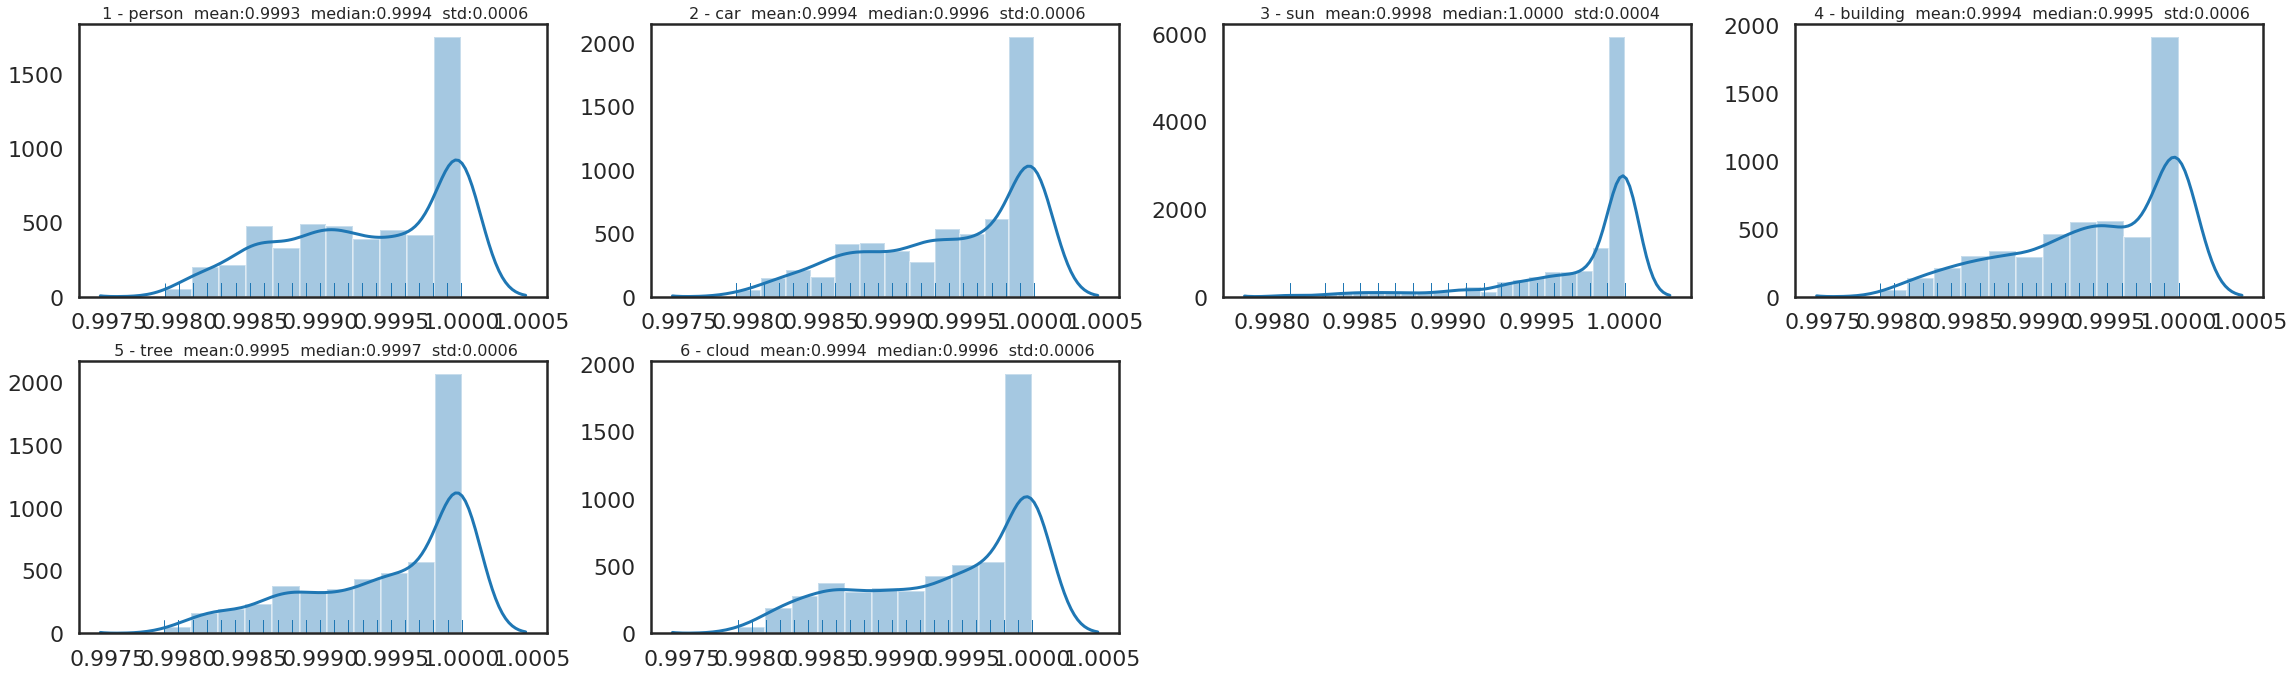

In [5]:
cmap.plot_score_distribution(cls_info, 'mrcnn_score_norm')

###  mrcnn_score_0

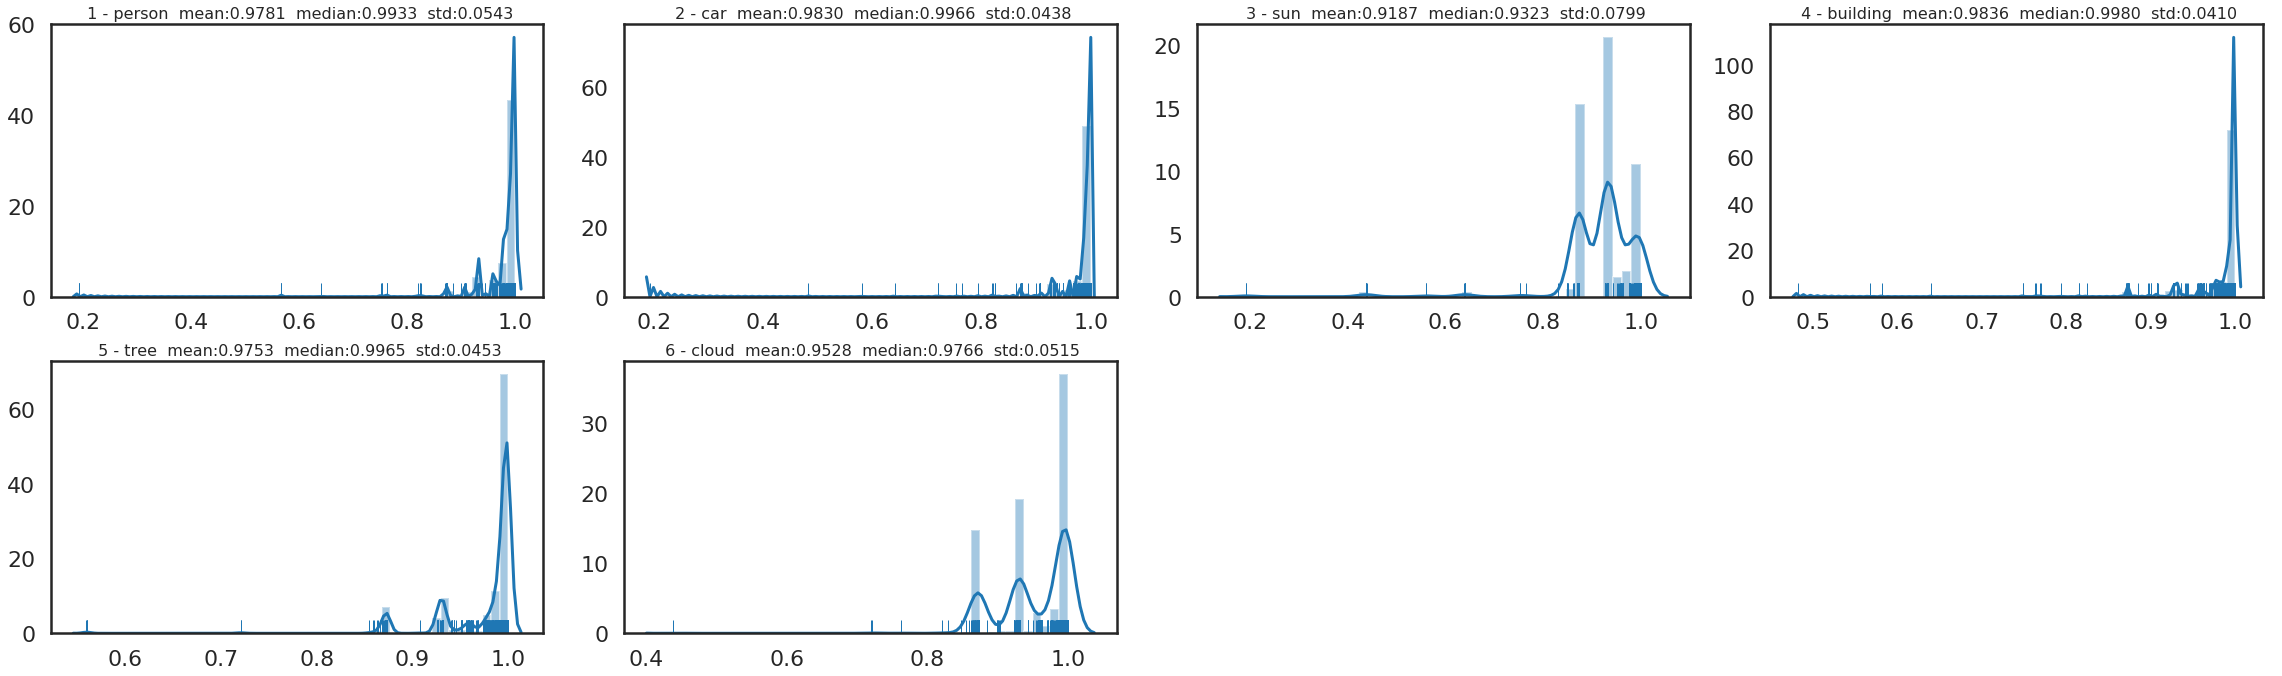

In [6]:
cmap.plot_score_distribution(cls_info, 'mrcnn_score_0')

###  mrcnn_score_1

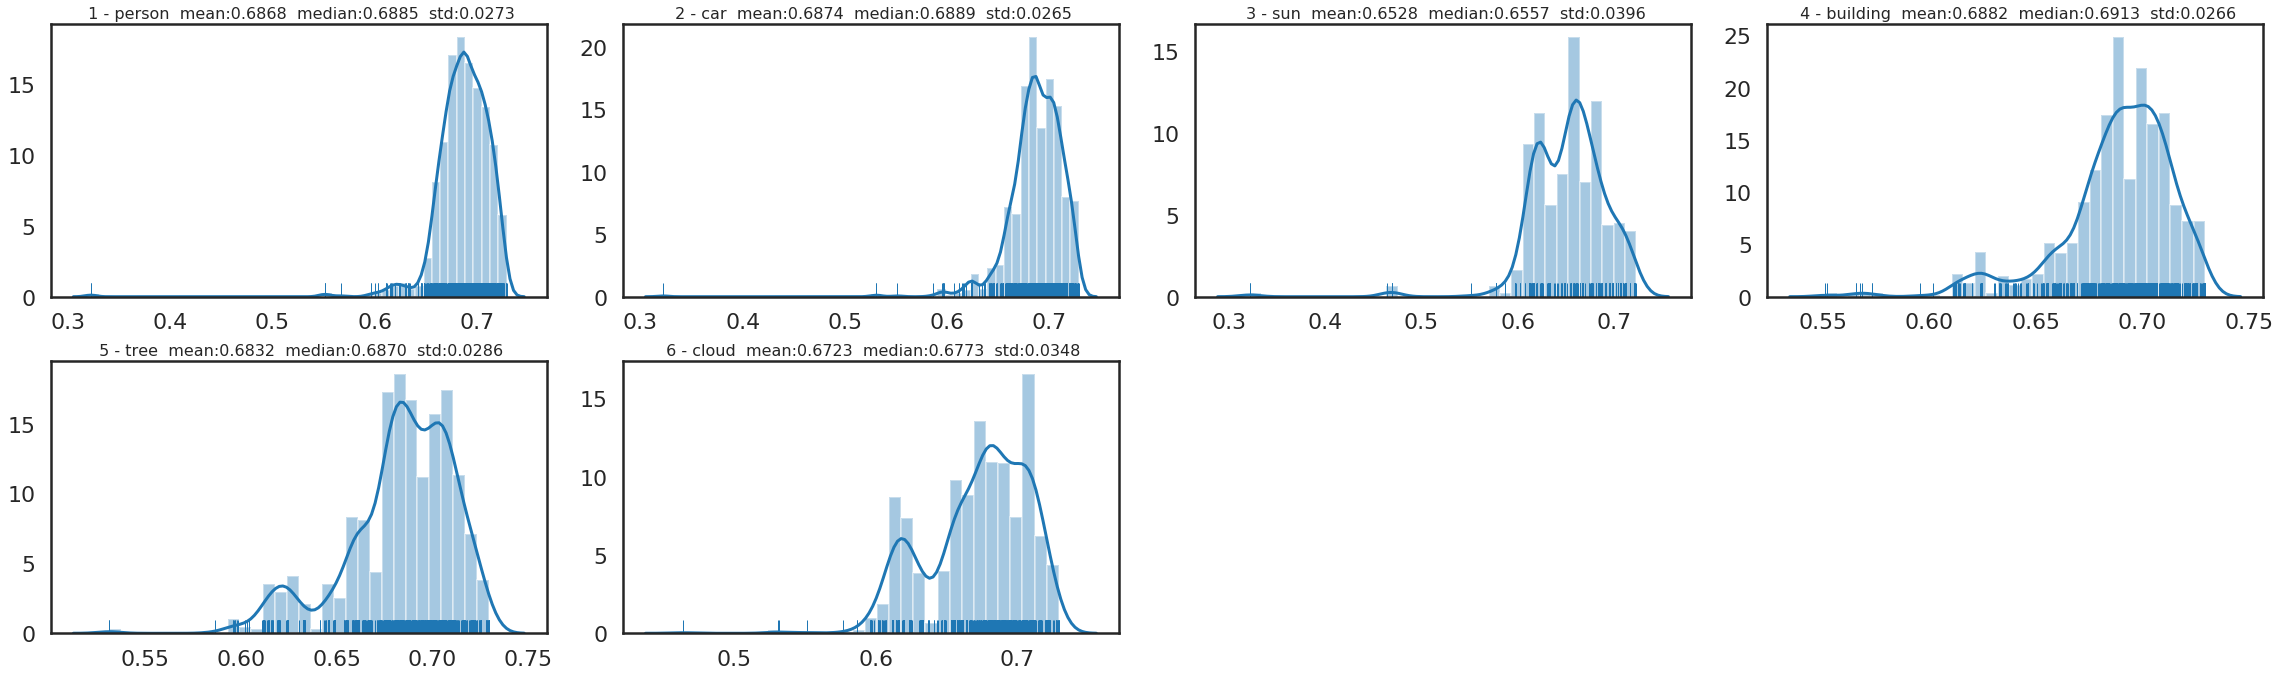

In [7]:
cmap.plot_score_distribution(cls_info, 'mrcnn_score_1')

###  mrcnn_score_2

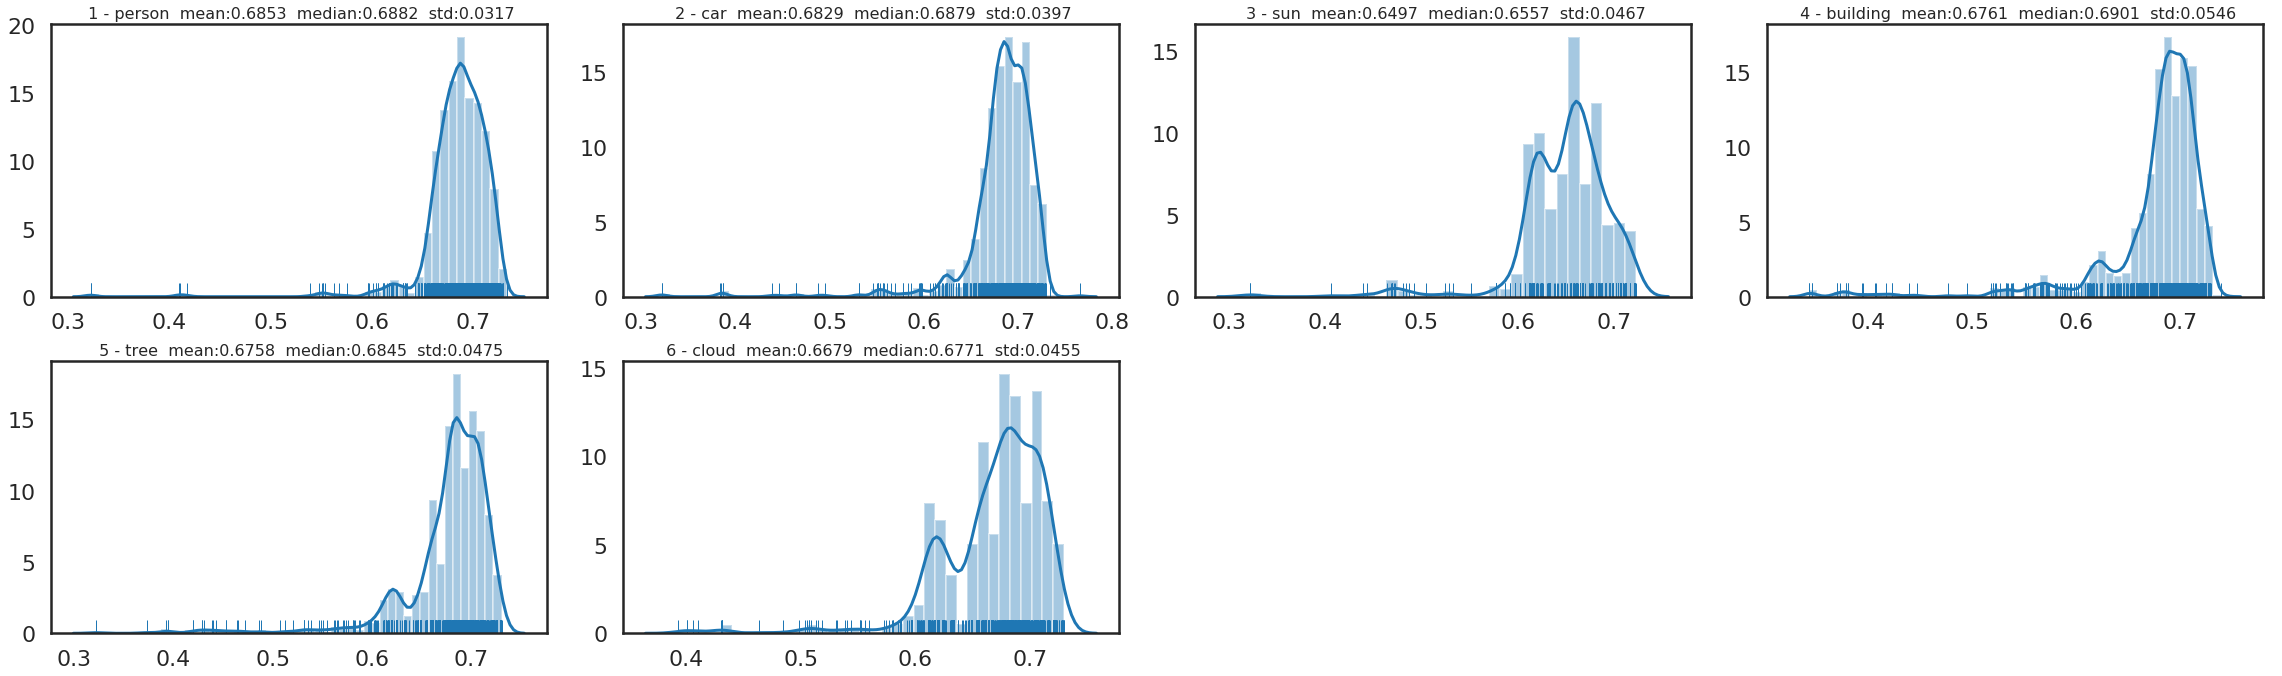

In [8]:
cmap.plot_score_distribution(cls_info, 'mrcnn_score_2')

###  fcn_score_0

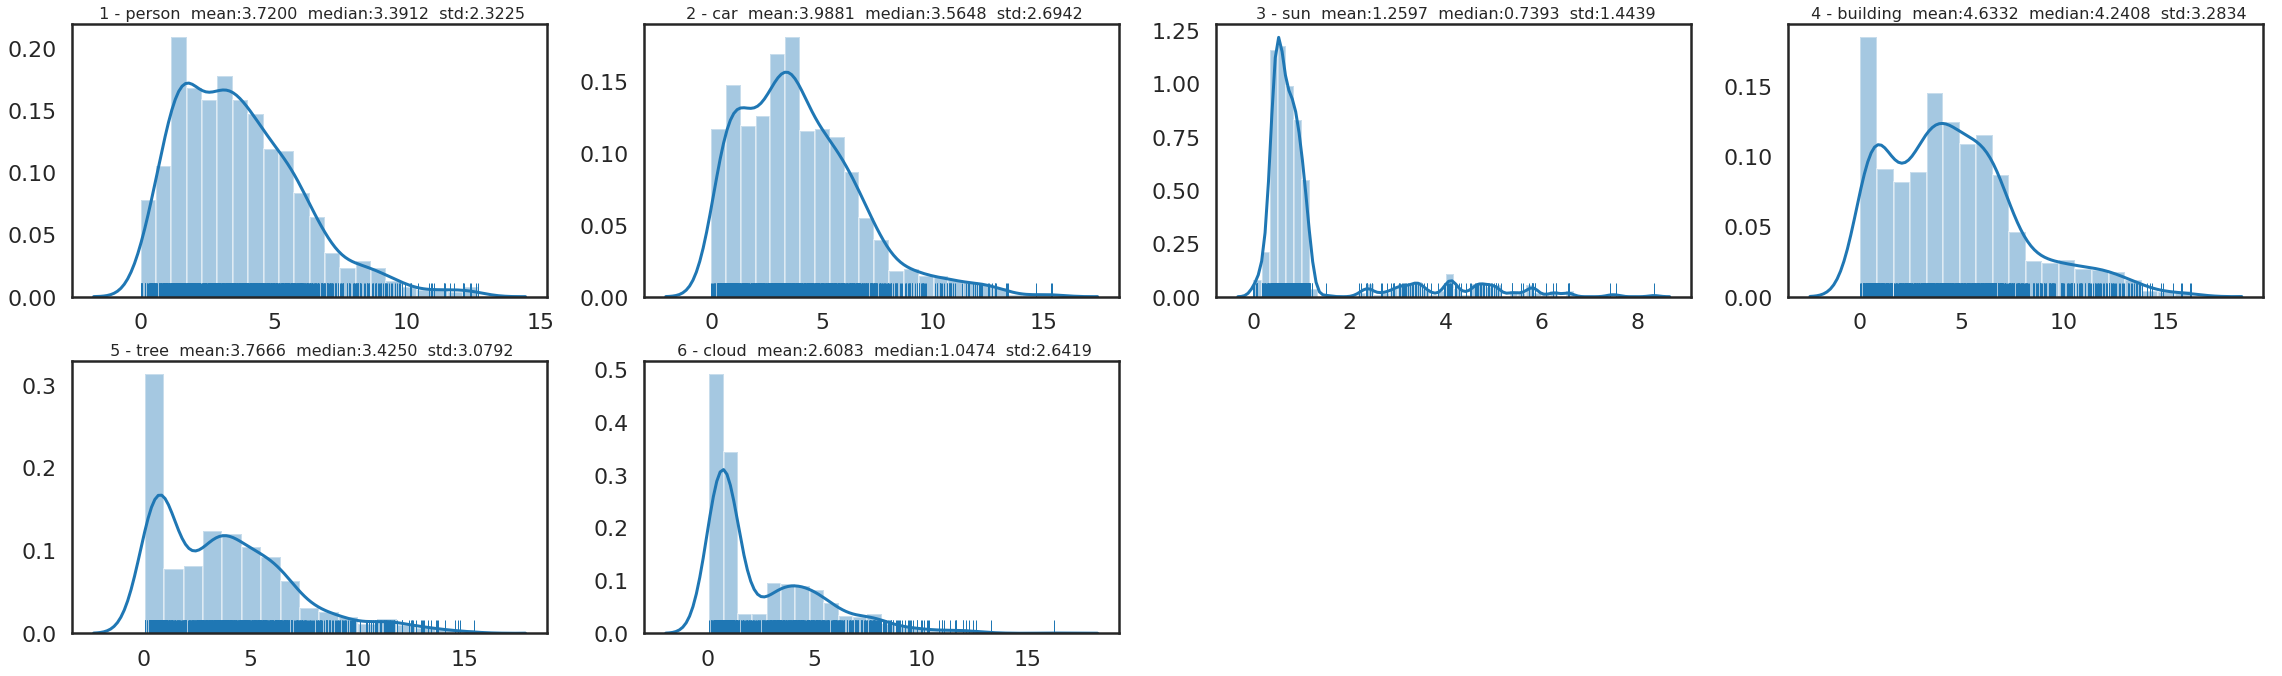

In [9]:
cmap.plot_score_distribution(cls_info, 'fcn_score_0')

###  fcn_score_1

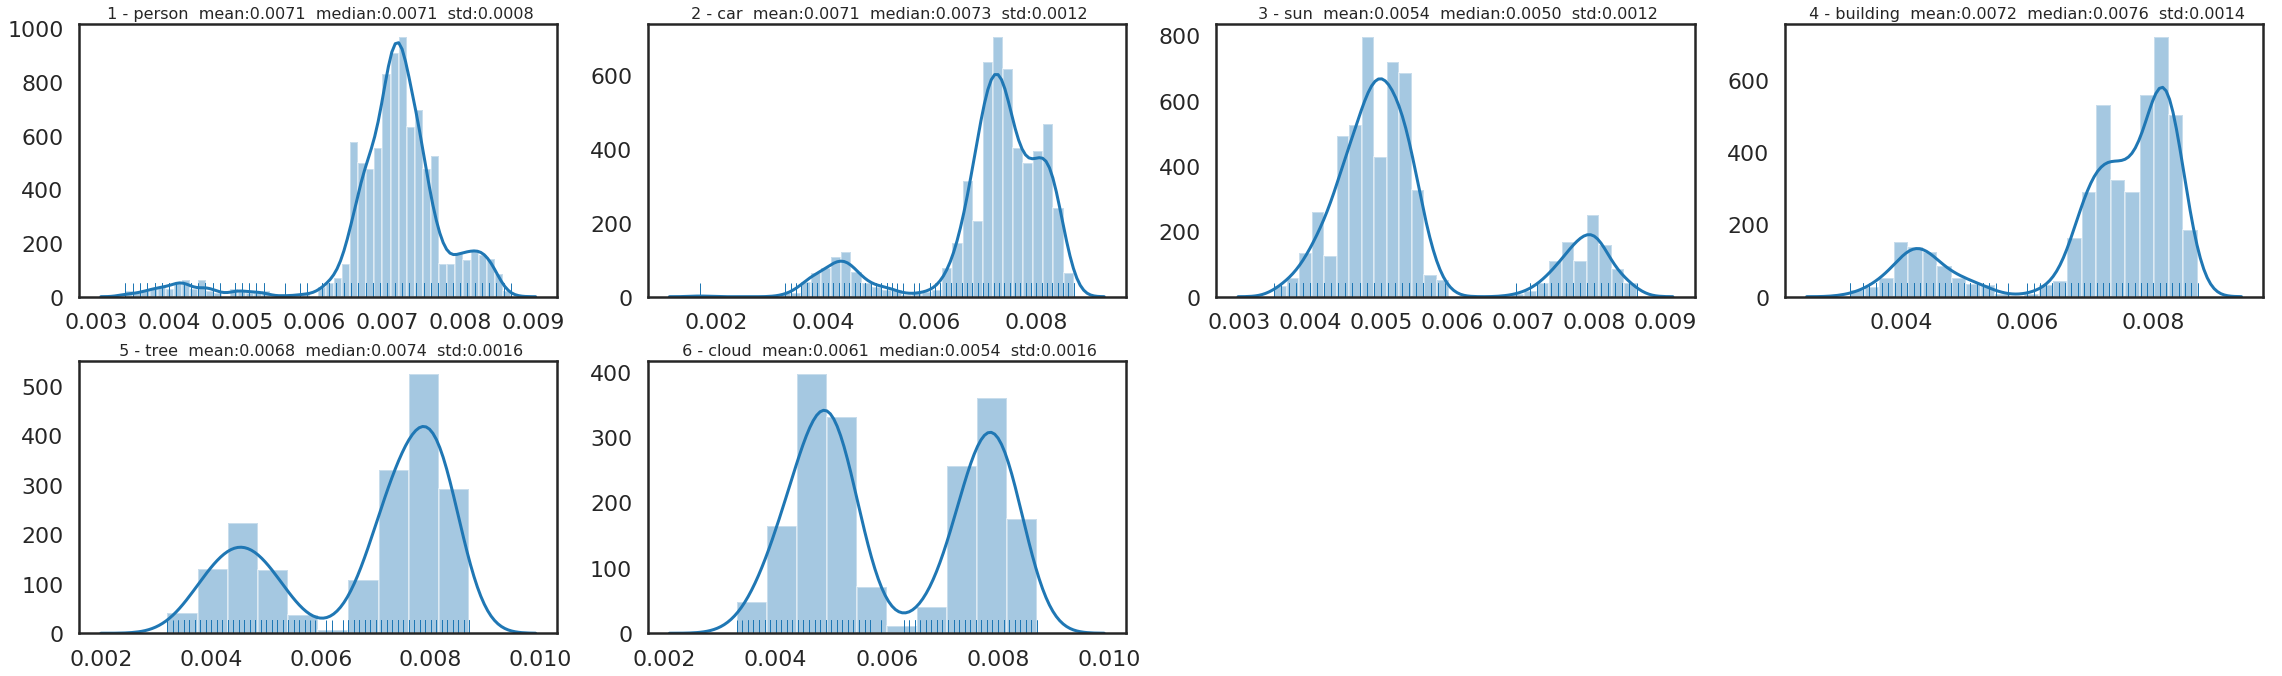

In [10]:
cmap.plot_score_distribution(cls_info, 'fcn_score_1')

###  fcn_score_2

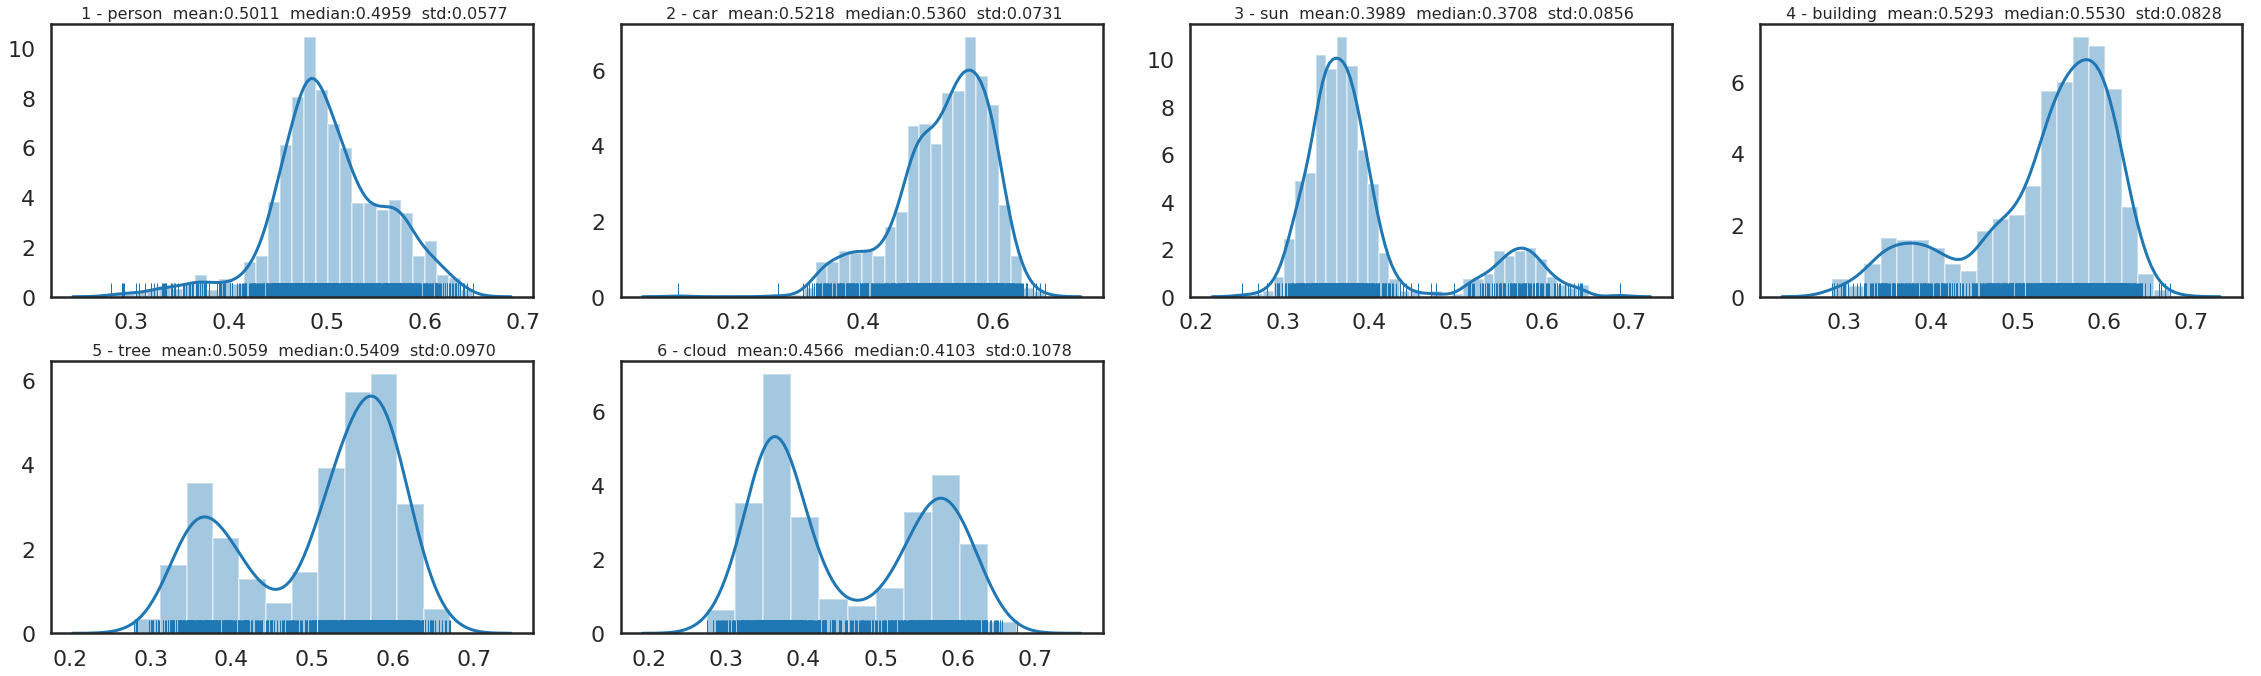

In [11]:
cmap.plot_score_distribution(cls_info, 'fcn_score_2')

## Barchart - AP vs. IoU Threshold for various scores 

 Num disp classes 1  Columns:  1  Rows:  1


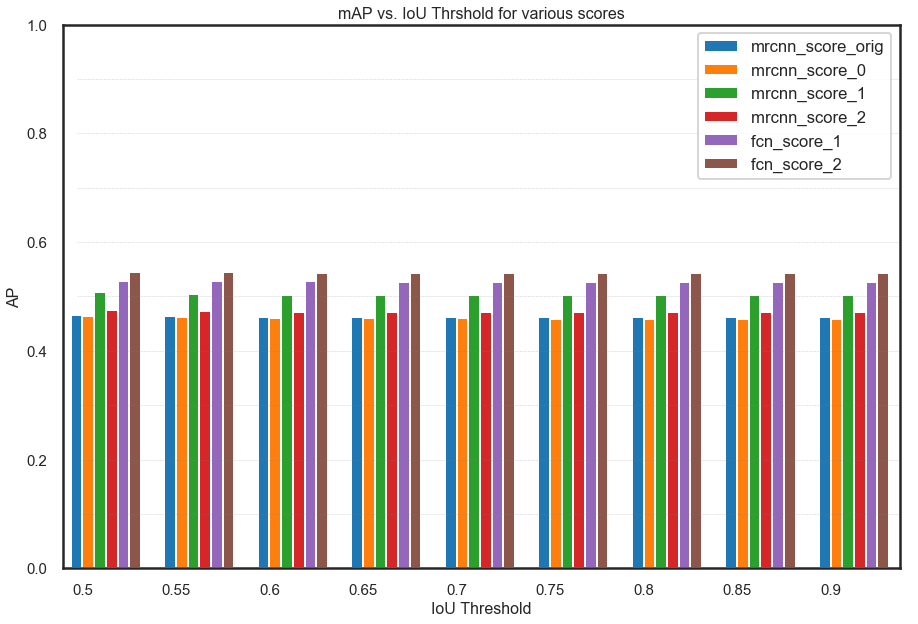


                                                  AP @ IoU Thresholds for computed scores                                                   

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Score -                           0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
mrcnn_score_orig                  0.4667     0.4645     0.4631     0.4627     0.4623     0.4620     0.4620     0.4618     0.4617     %46.30 
mrcnn_score_0                     0.4633     0.4618     0.4607     0.4605     0.4596     0.4595     0.4595     0.4595     0.4595     %46.04 
mrcnn_score_1                     0.5082     0.5048     0.5037     0.5035     0.5029     0.5027     0.5027     0.5027     0.5025     %50.38 
mrcnn_score_2

In [109]:
# disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2',  'fcn_score_1', 'fcn_score_2']
disp_ious    = [0.5 , 0.75, 0.9]
cmap.plot_mAP_vs_IoUs_BarChart(all_data, disp_scores, class_ids= [0])# , disp_ious)

## Barchart - mAP vs. Class for different scores `plot_mAP_vs_class()`

disp_scores:  ['mrcnn_score_orig', 'mrcnn_score_0', 'fcn_score_0', 'mrcnn_score_1', 'fcn_score_1', 'mrcnn_score_2', 'fcn_score_2']


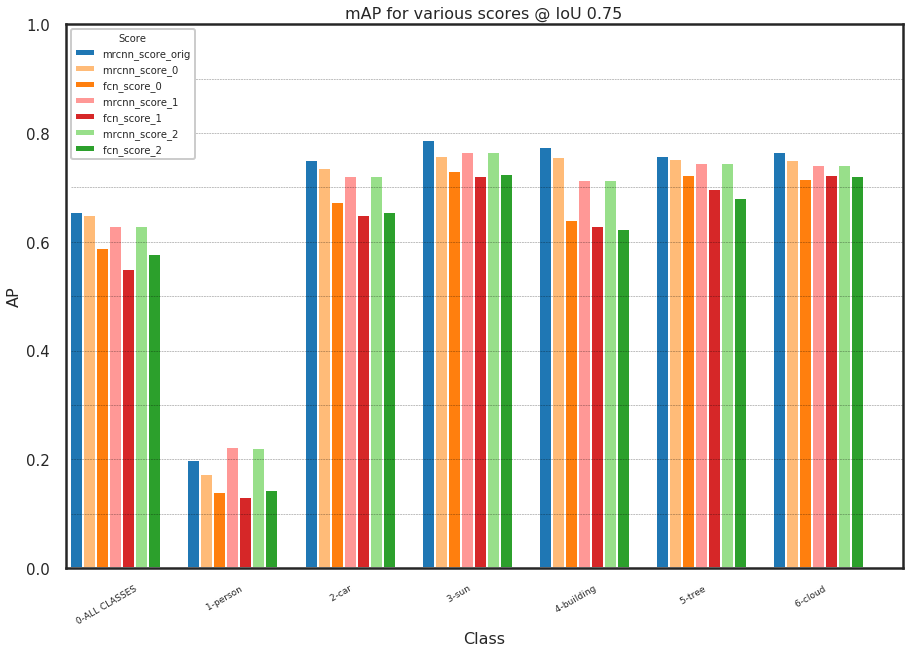


                                                AP @ IoU 0.75 Thresholds for Computed Scores                                                

-----------------------------------------------------------------  scores  -----------------------------------------------------------------
Id - ClassName           mrcnn_score_orig     mrcnn_score_0       fcn_score_0     mrcnn_score_1       fcn_score_1     mrcnn_score_2       fcn_score_2
--------------------------------------------------------------------------------------------------------------------------------------------
 1 - person                        0.1987            0.1734            0.1403            0.2217            0.1313            0.2199            0.1432 
 2 - car                           0.7507            0.7353            0.6729            0.7204            0.6497            0.7204            0.6551 
 3 - sun                           0.7871            0.7587            0.7302            0.7647            0.7208          

In [35]:
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_0', 'fcn_score_0'  , 'mrcnn_score_1', 'fcn_score_1', 'mrcnn_score_2', 'fcn_score_2']
# disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2','fcn_score_0', 'fcn_score_1', 'fcn_score_2']
disp_ious    = [0.5 , 0.75, 0.9]
cmap.plot_mAP_vs_class_BarChart(all_data, disp_scores, class_names = class_names, iou = 0.75)# , disp_ious)

disp_scores:  ['mrcnn_score_orig', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_1_norm', 'fcn_score_2', 'fcn_score_2_norm']


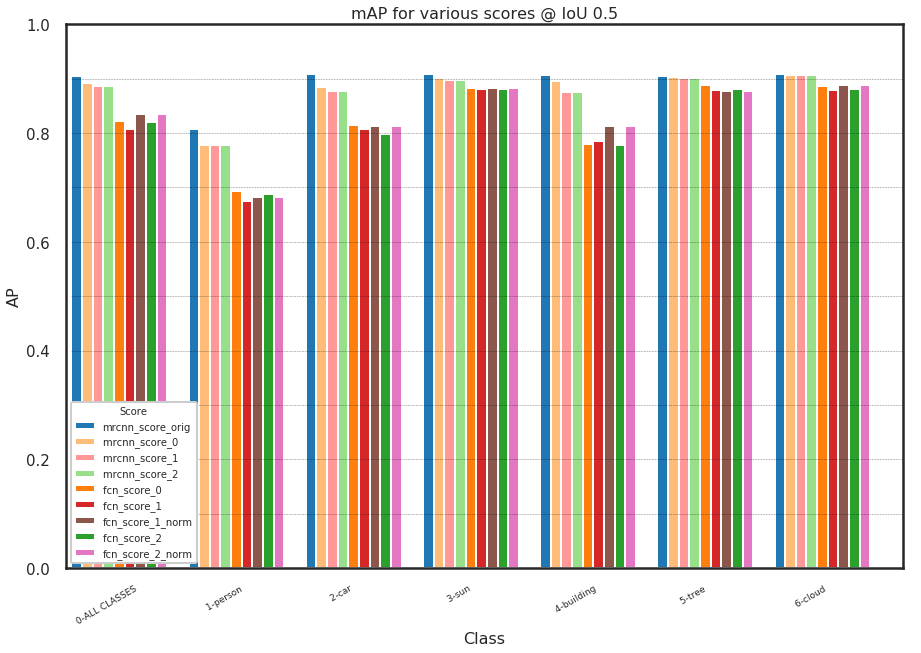


                                                AP @ IoU 0.50 Thresholds for Computed Scores                                                

-----------------------------------------------------------------  scores  -----------------------------------------------------------------
Id - ClassName           mrcnn_score_orig     mrcnn_score_0     mrcnn_score_1     mrcnn_score_2       fcn_score_0       fcn_score_1  fcn_score_1_norm       fcn_score_2  fcn_score_2_norm
--------------------------------------------------------------------------------------------------------------------------------------------
 1 - person                        0.8084            0.7774            0.7778            0.7785            0.6940            0.6748            0.6816            0.6881            0.6816 
 2 - car                           0.9082            0.8852            0.8771            0.8771            0.8141            0.8076            0.8125            0.7982            0.8125 
 3 - sun       

In [44]:
# disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_1_norm','fcn_score_2', 'fcn_score_2_norm' ]
# disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_0', 'fcn_score_0'  , 'mrcnn_score_1', 'fcn_score_1', 'mrcnn_score_2', 'fcn_score_2']
disp_ious    = [0.5 , 0.75, 0.9]
cmap.plot_mAP_vs_class_BarChart(all_data, disp_scores, class_names = class_names, iou = 0.5)# , disp_ious)

## Plot combined mAP for different IoU thresholds for each score
(one type of score, e.g. 'scores' - all classes combined)

### `mrcnn_score_orig`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                         AP @ IoU Thresholds for Score Computation: mrcnn_score_orig                                        

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.2000     0.2500     0.3000     0.3500     0.4000     0.4500     0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  ALL CLASSES                     90.79%     90.78%     90.78%     90.77%     90.72%     90.69%     90.54%     90.23%     89.21%     79.62%     77.20%     65.45%     50.49%     25.92%      7.99%      %74.75 
---------------------------------------------------------------------------------------------

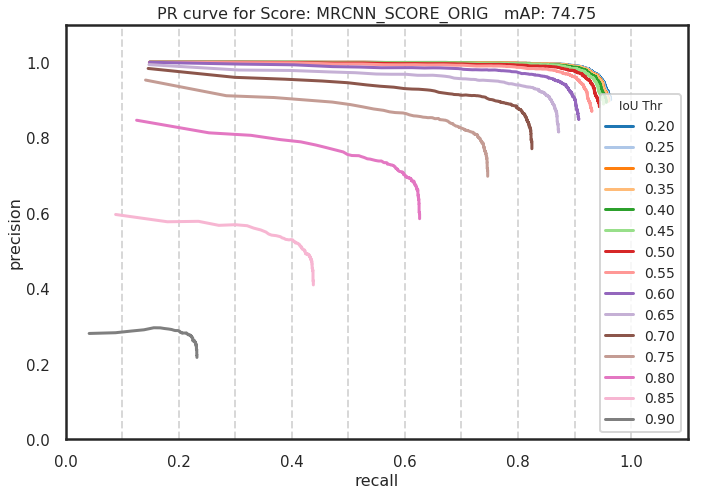

In [45]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_orig', class_ids = [0], class_names = class_names, columns = 3)

### `mrcnn_score_0`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_0                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.2000     0.2500     0.3000     0.3500     0.4000     0.4500     0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  ALL CLASSES                     89.97%     89.82%     89.76%     89.72%     89.53%     89.44%     89.12%     88.70%     87.71%     78.62%     76.96%     64.95%     50.10%     25.67%      7.80%      %73.86 
---------------------------------------------------------------------------------------------

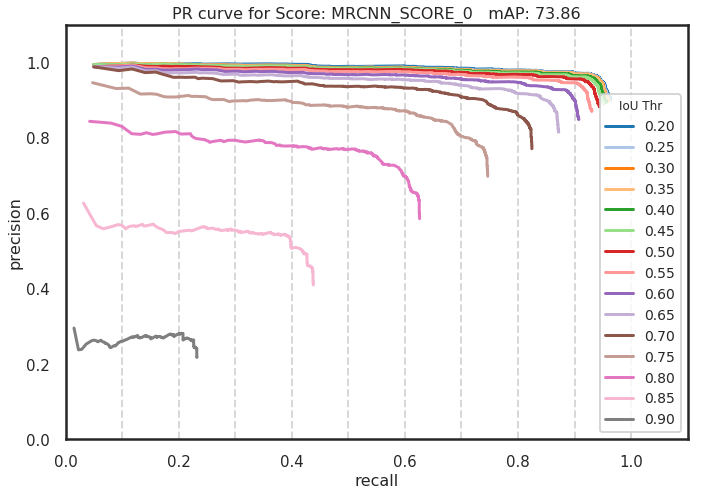

In [46]:
# plot_mAP_by_score(all_data, 'scores' )

cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_0' , class_ids = 0 , class_names = class_names, columns = 3)

### `mrcnn_score_1`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_1                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.2000     0.2500     0.3000     0.3500     0.4000     0.4500     0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  ALL CLASSES                     89.87%     89.70%     89.63%     89.44%     89.18%     89.02%     88.69%     88.06%     86.89%     77.11%     75.00%     62.96%     48.71%     27.73%     13.81%      %73.72 
---------------------------------------------------------------------------------------------

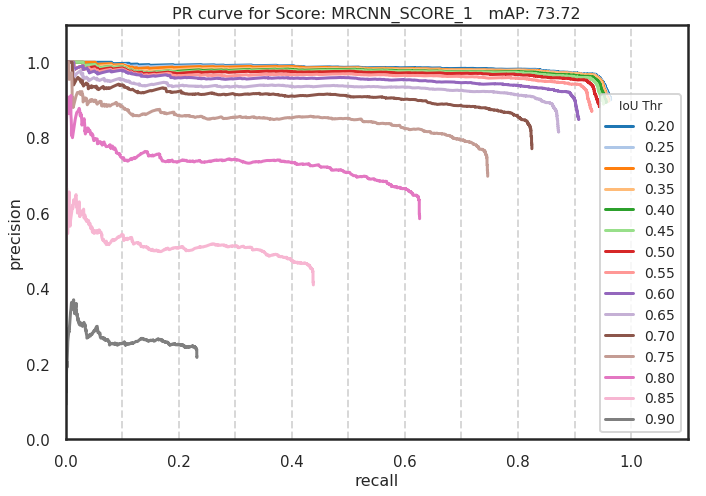

In [47]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_1' , class_ids = 0 ,class_names = class_names, columns = 3)

### `mrcnn_score_2`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_2                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.4740     0.4714     0.4705     0.4703     0.4701     0.4699     0.4699     0.4699     0.4699      %47.07 



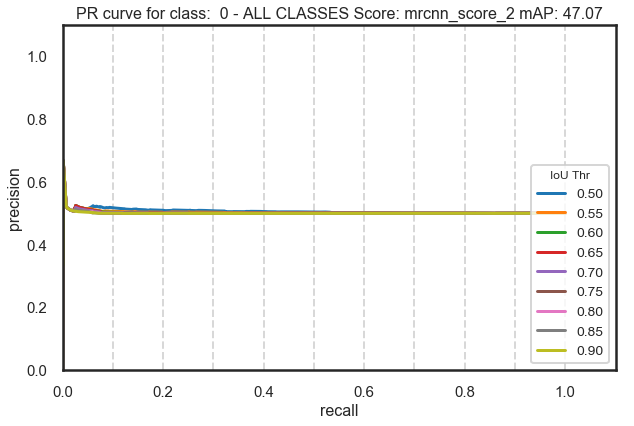

In [21]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_2' , class_ids = 0 ,class_names = class_names, columns = 3)

### `mrcnn_score_norm`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                         AP @ IoU Thresholds for Score Computation: mrcnn_score_norm                                        

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.4572     0.4563     0.4555     0.4552     0.4547     0.4547     0.4547     0.4547     0.4545      %45.53 



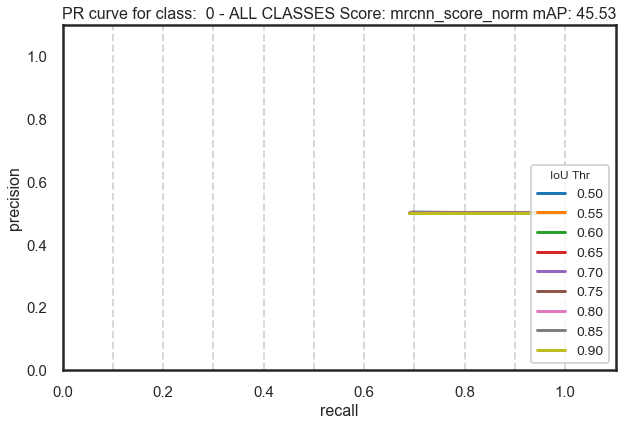

In [22]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_norm' , class_ids = 0 ,class_names = class_names, columns = 3)

### `fcn_score_0`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                           AP @ IoU Thresholds for Score Computation: fcn_score_0                                           

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.2000     0.2500     0.3000     0.3500     0.4000     0.4500     0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  ALL CLASSES                     84.25%     83.71%     83.37%     83.16%     82.96%     82.68%     82.24%     81.59%     80.71%     71.71%     69.72%     58.86%     42.98%     21.72%      6.52%      %67.75 
---------------------------------------------------------------------------------------------

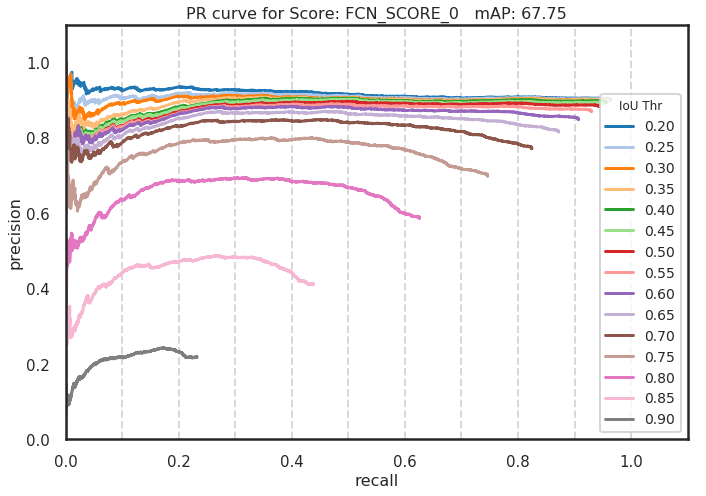

In [48]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_0' , class_ids = 0 , class_names = class_names,columns = 3)

### `fcn_score_1`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                           AP @ IoU Thresholds for Score Computation: fcn_score_1                                           

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.2000     0.2500     0.3000     0.3500     0.4000     0.4500     0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  ALL CLASSES                     83.81%     83.24%     82.84%     82.60%     82.34%     81.09%     80.68%     79.86%     78.53%     69.04%     66.66%     55.06%     41.72%     21.08%      6.34%      %66.33 
---------------------------------------------------------------------------------------------

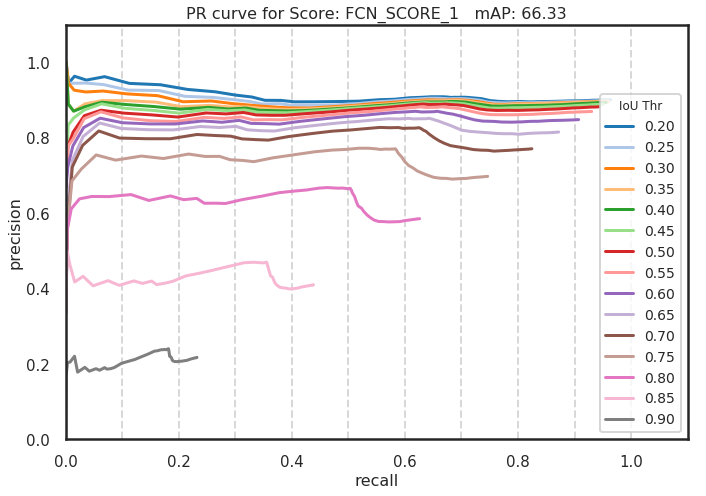

In [49]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_1' , class_ids = 0 , class_names = class_names,columns = 3)

### `fcn_score_2`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                           AP @ IoU Thresholds for Score Computation: fcn_score_2                                           

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.2000     0.2500     0.3000     0.3500     0.4000     0.4500     0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  ALL CLASSES                     83.93%     83.43%     83.02%     82.92%     82.68%     82.35%     81.95%     81.31%     80.17%     70.98%     68.88%     57.81%     45.10%     26.13%      7.81%      %67.90 
---------------------------------------------------------------------------------------------

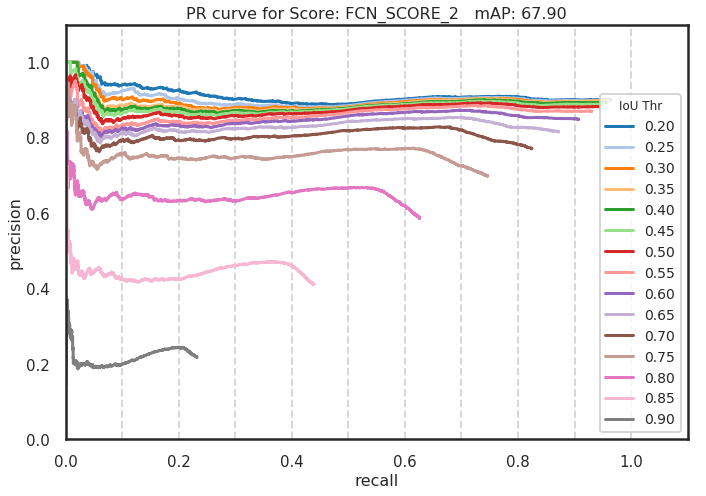

In [50]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_2' , class_ids = 0 , class_names = class_names,columns = 3)

## Plot combined mAP info for different scores (at a given IoU threshold, all classes combined)

In [7]:
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2' ,'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = [0], class_names = class_names,iou = 0.50)

NameError: name 'all_data' is not defined

## Indvidual classes - Plot mAP info for  at different thresholds (one type of score, e.g. 'scores')

### Plot mAP for `mrcnn_score_orig` for different IoU thresholds

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                         AP @ IoU Thresholds for Score Computation: mrcnn_score_orig                                        

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.2000     0.2500     0.3000     0.3500     0.4000     0.4500     0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.4677     0.4675     0.4675     0.4675     0.4675     0.4675     0.4675     0.4675     0.4637     0.4637     0.4637     0.4637     0.4637     0.4637     0.4637      %46.57 
  2 - car                         0.5039     0.5033     0.5033     0.5033     0.5033     0.50

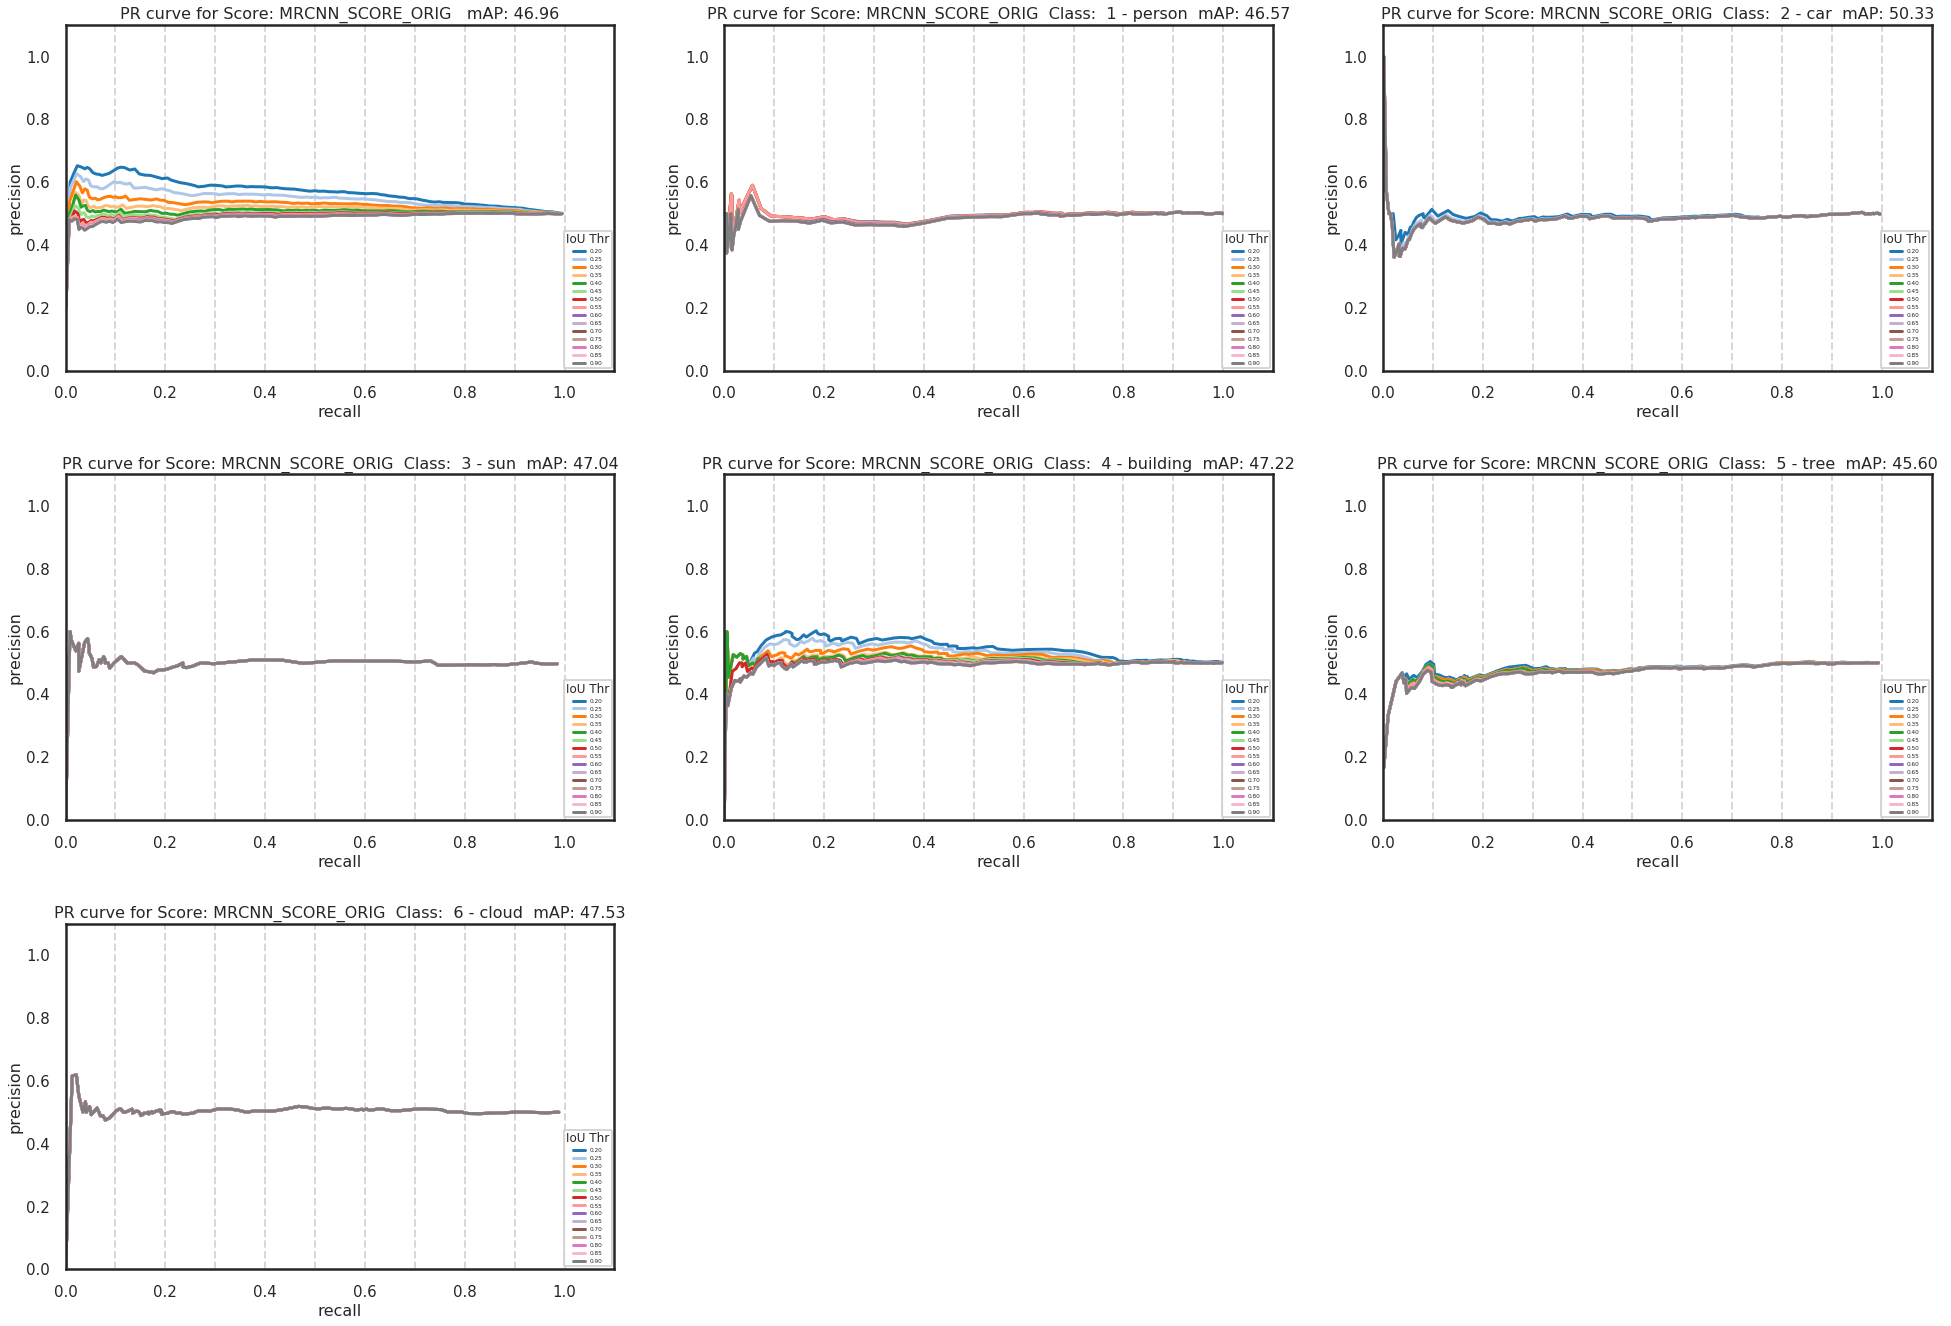

In [14]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_orig', class_names = class_names )

### Plot mAP for `mrcnn_score_norm` for different IoU thresholds


                                         AP @ IoU Thresholds for Score Computation: mrcnn_score_norm                                        

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.7777     0.7569     0.6442     0.4946     0.3545     0.1565     0.0654     0.0264     0.0050      %36.46 
  2 - car                         0.8921     0.8852     0.8817     0.8759     0.7737     0.7111     0.4763     0.2429     0.0719      %64.56 
  3 - sun                         0.9062     0.9062     0.8977     0.8919     0.8634     0.8205     0.5786     0.3862     0.1338      %70.94 
  4 - buil

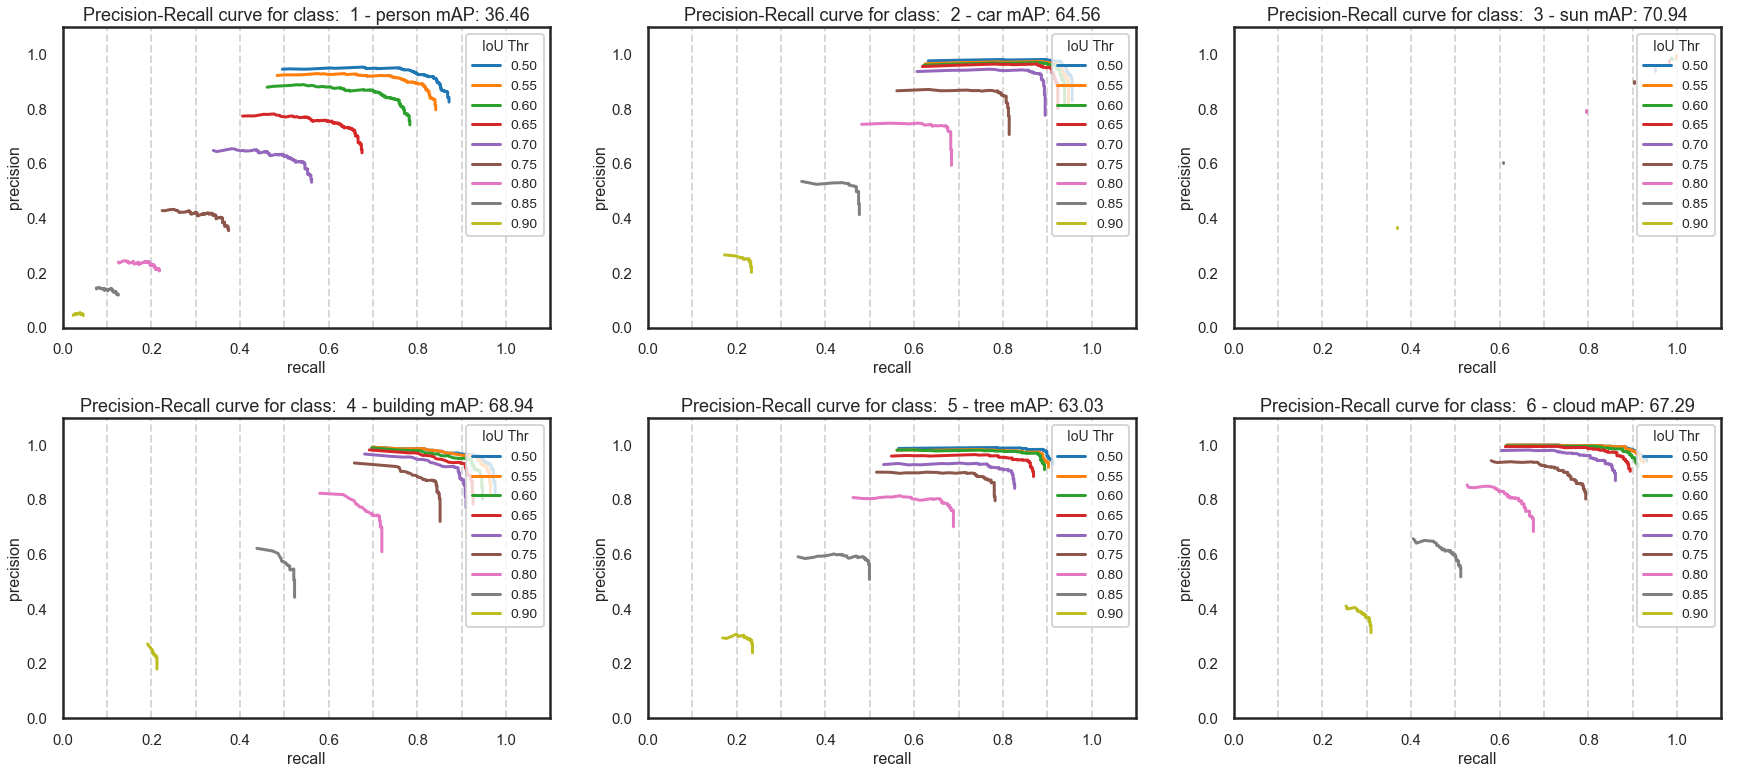

In [163]:
plot_mAP_by_IOU(all_data, 'mrcnn_score_norm')

### Plot mAP for `mrcnn_score_0` for different IoU thresholds

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_0                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.8912     0.8870     0.8770     0.7862     0.7696     0.6493     0.5006     0.2566     0.0779      %63.28 
  1 - person                      0.7774     0.7507     0.6410     0.5154     0.3580     0.1734     0.0717     0.0244     0.0061      %36.87 
  2 - car                         0.8851     0.8819     0.8780     0.8694     0.766

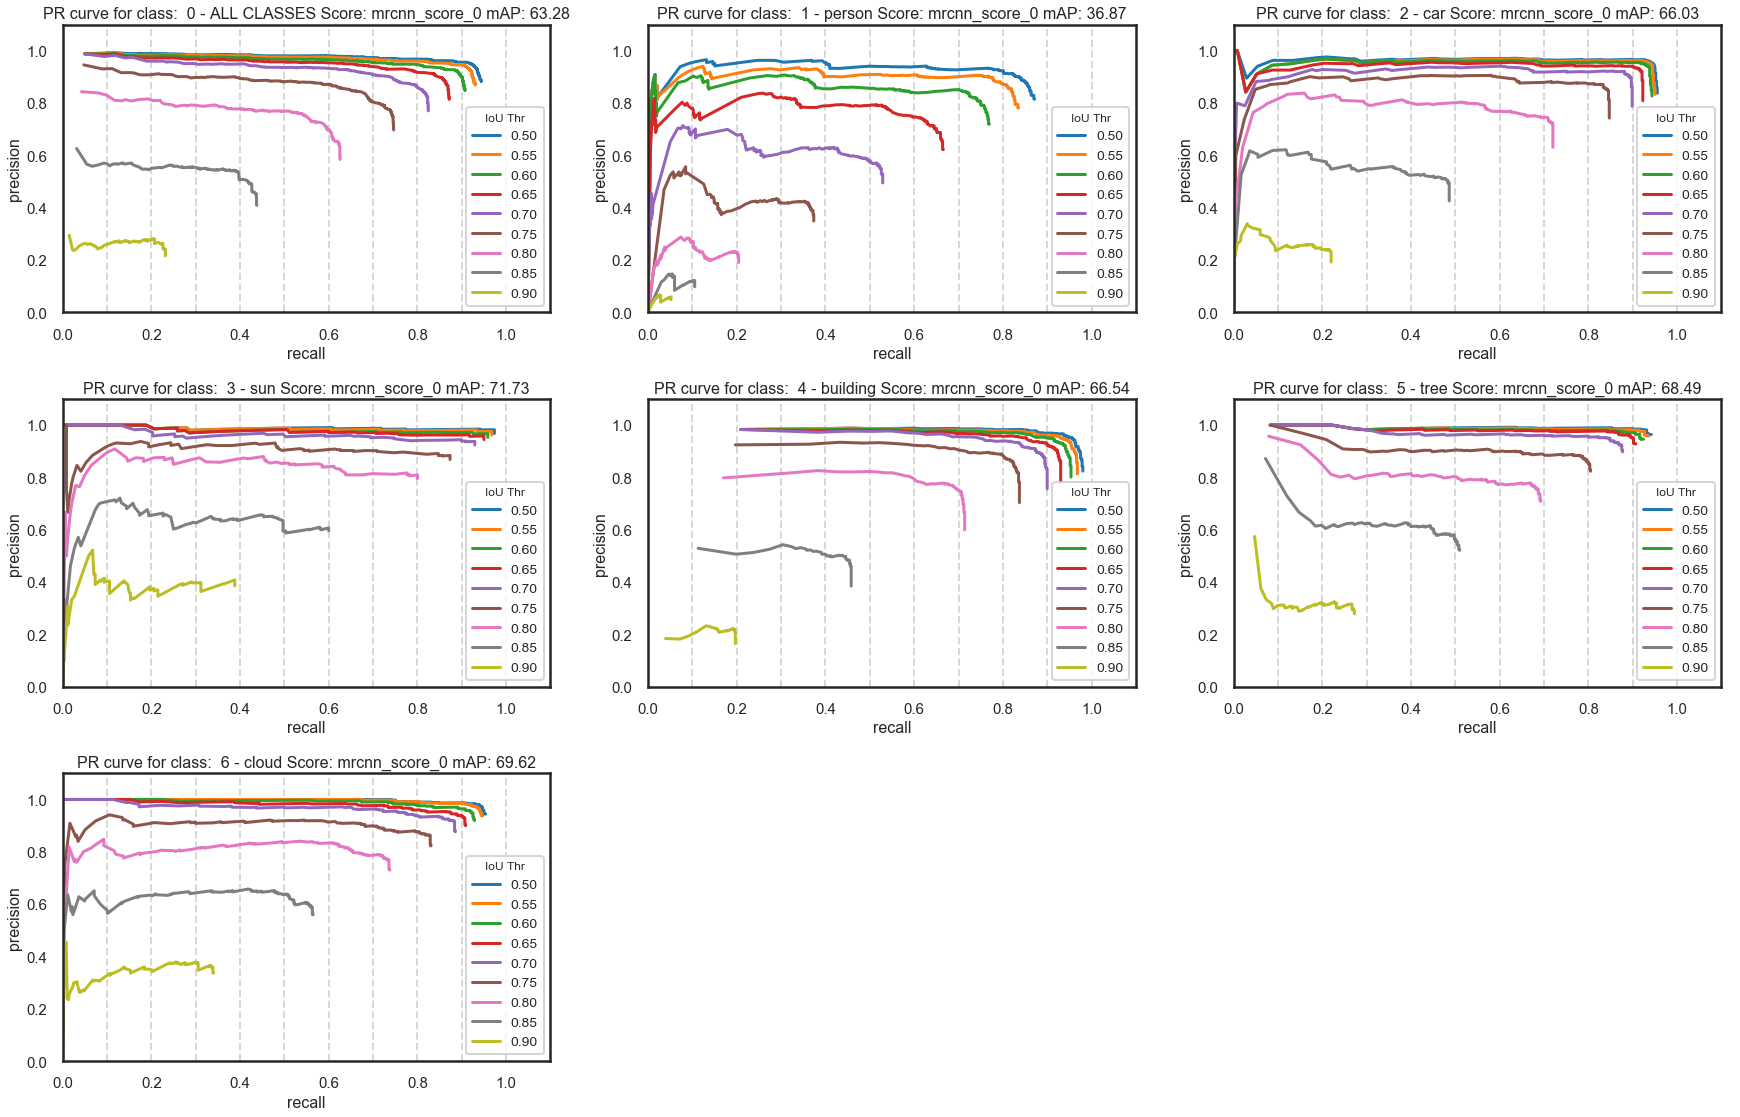

In [201]:
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_0', class_names = class_names )

### Plot mAP for `mrcnn_score_1` for different IoU thresholds

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_1                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.4563     0.4563     0.4555     0.4545     0.4545     0.4545     0.4545     0.4545     0.4545      %45.50 
  2 - car                         0.4545     0.4545     0.4545     0.4545     0.4545     0.4545     0.4545     0.4545     0.4545      %45.45 
  3 - sun                         0.4545     0.4545     0.4545     0.4545     0.454

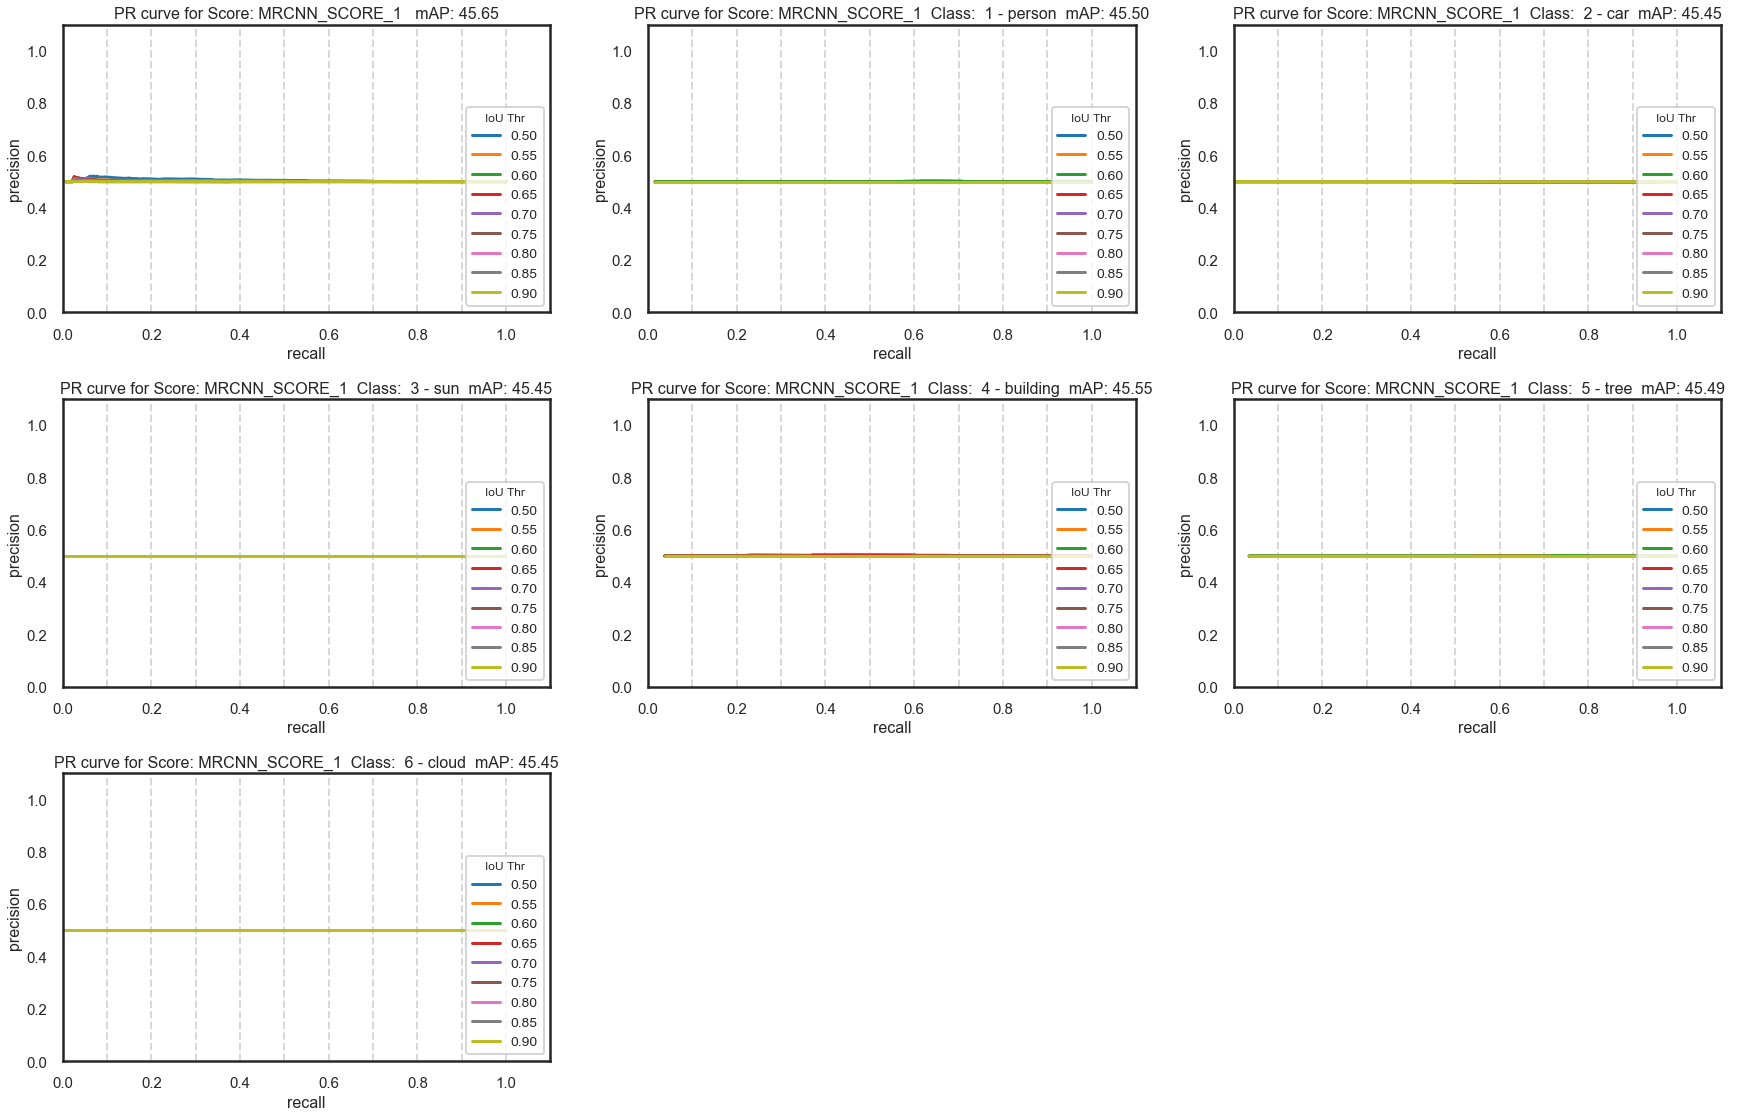

In [145]:
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_1', class_names = class_names )

### Plot mAP for `mrcnn_score_2` for different IoU thresholds

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_2                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.4560     0.4560     0.4560     0.4560     0.4560     0.4560     0.4560     0.4560     0.4560      %45.60 
  2 - car                         0.4549     0.4549     0.4549     0.4549     0.4549     0.4549     0.4549     0.4549     0.4549      %45.49 
  3 - sun                         0.4545     0.4545     0.4545     0.4545     0.454

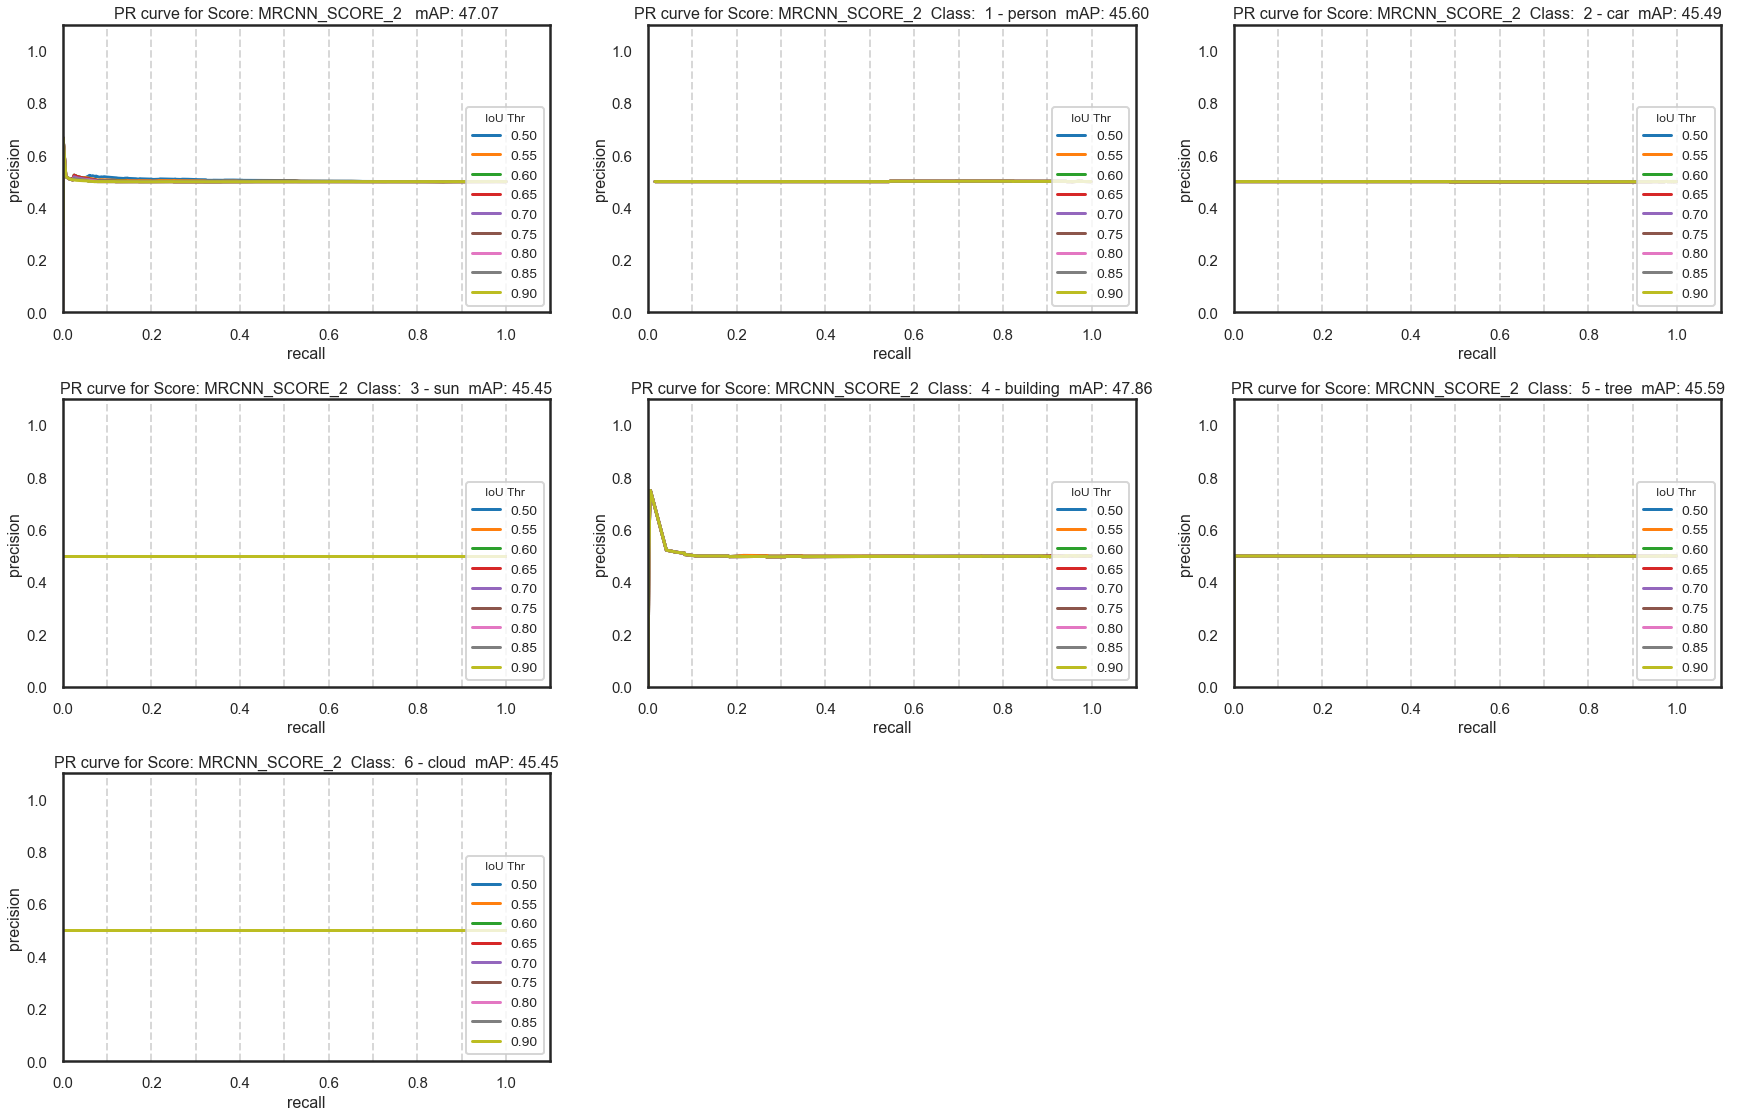

In [146]:
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_2', class_names = class_names )

### Plot mAP for `fcn_score_1` for different IoU thresholds

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                           AP @ IoU Thresholds for Score Computation: fcn_score_1                                           

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.2000     0.2500     0.3000     0.3500     0.4000     0.4500     0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.4845     0.4836     0.4836     0.4836     0.4836     0.4836     0.4836     0.4836     0.4836     0.4836     0.4836     0.4836     0.4836     0.4836     0.4836      %48.37 
  2 - car                         0.5297     0.5295     0.5295     0.5295     0.5295     0.52

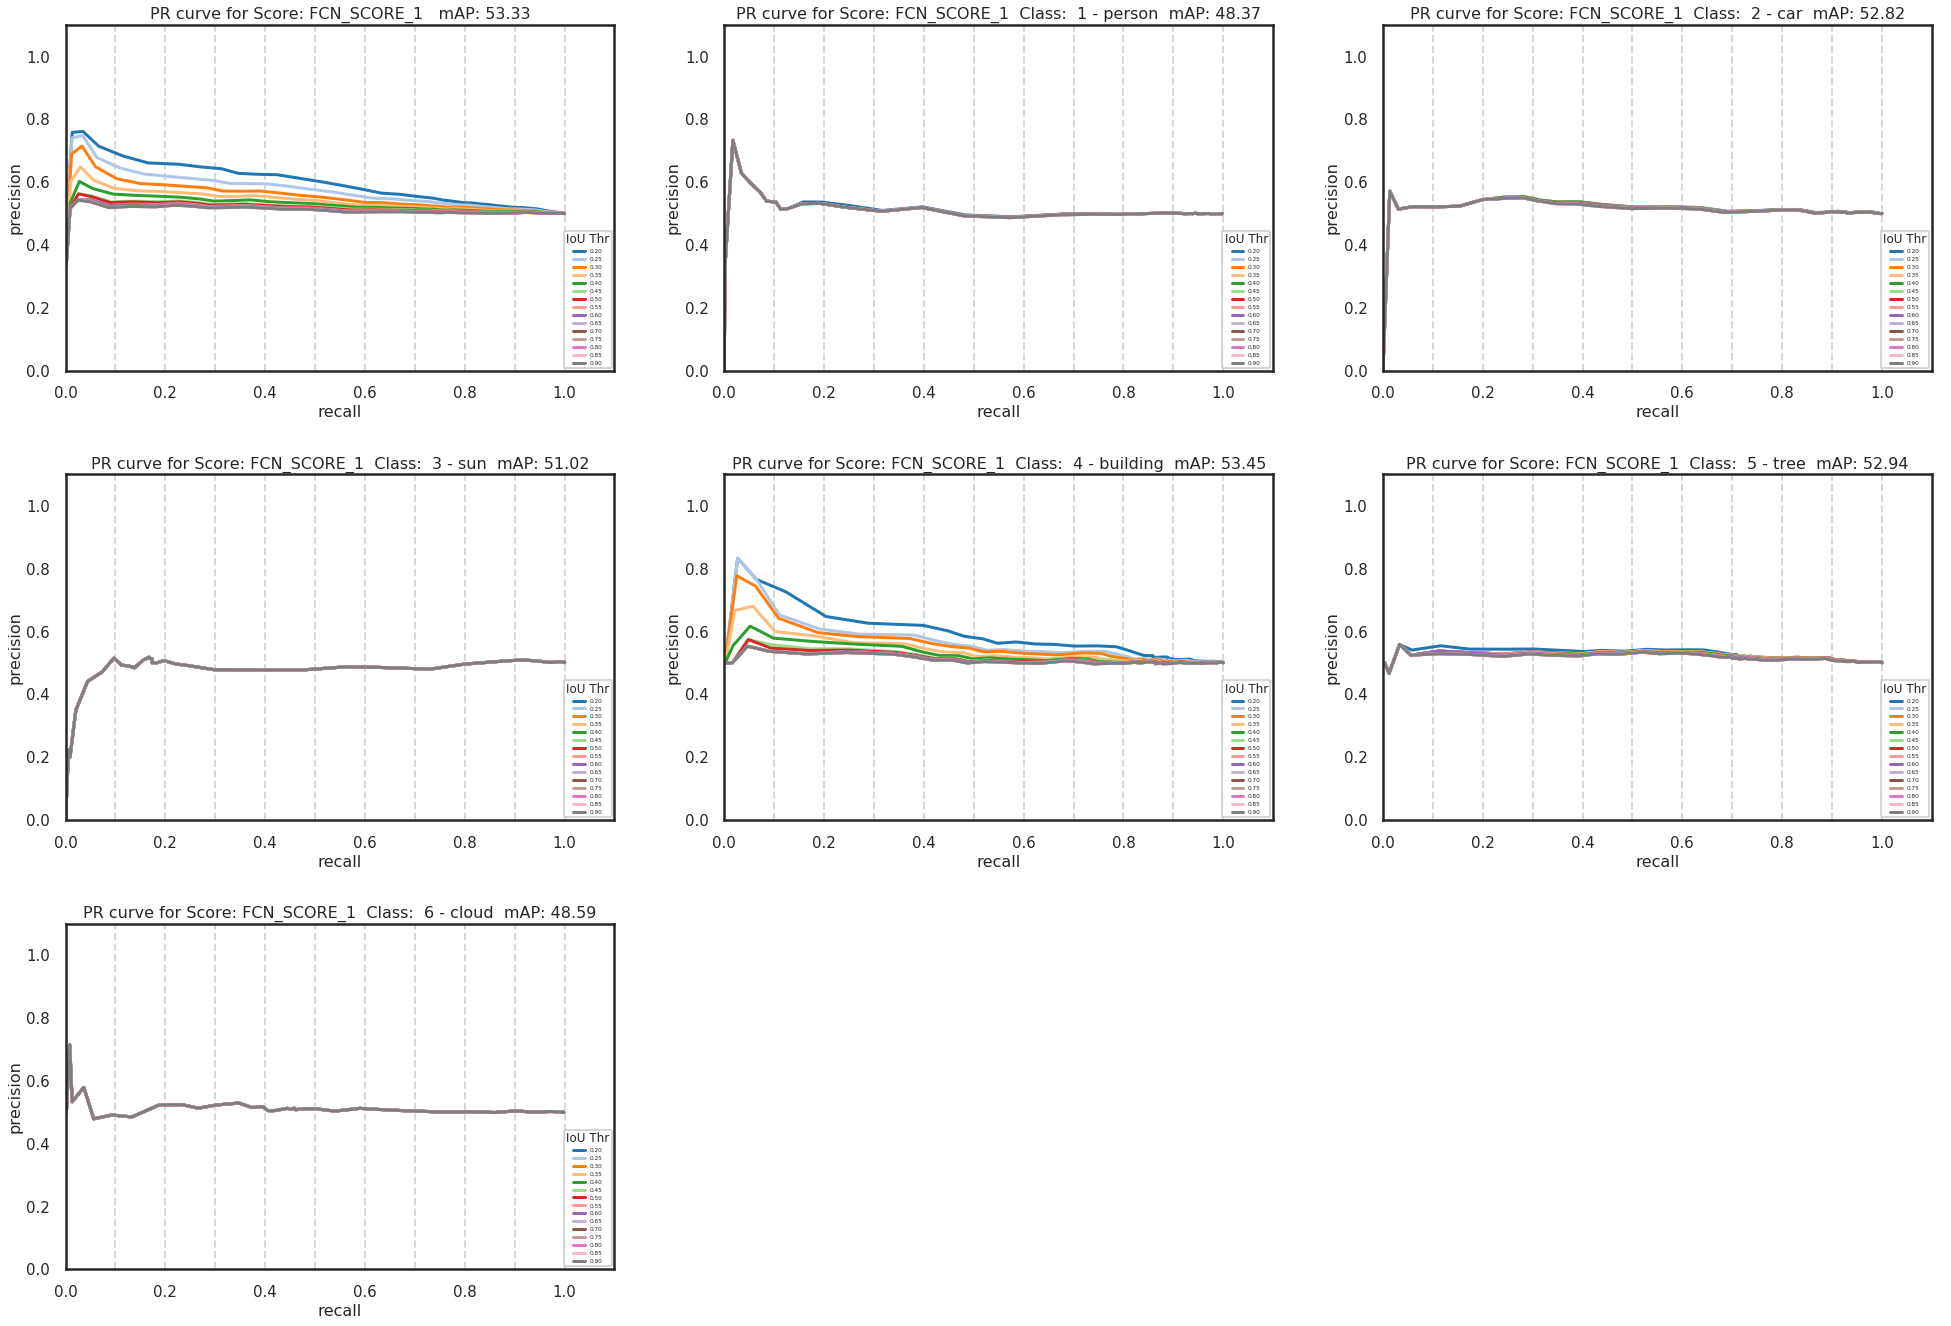

In [15]:
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_1', class_names = class_names )

### Plot mAP for `fcn_score_2` for different IoU thresholds

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                           AP @ IoU Thresholds for Score Computation: fcn_score_2                                           

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.2000     0.2500     0.3000     0.3500     0.4000     0.4500     0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.5593     0.5579     0.5579     0.5579     0.5579     0.5579     0.5579     0.5579     0.5579     0.5574     0.5574     0.5574     0.5574     0.5574     0.5574      %55.78 
  2 - car                         0.5501     0.5498     0.5498     0.5498     0.5498     0.54

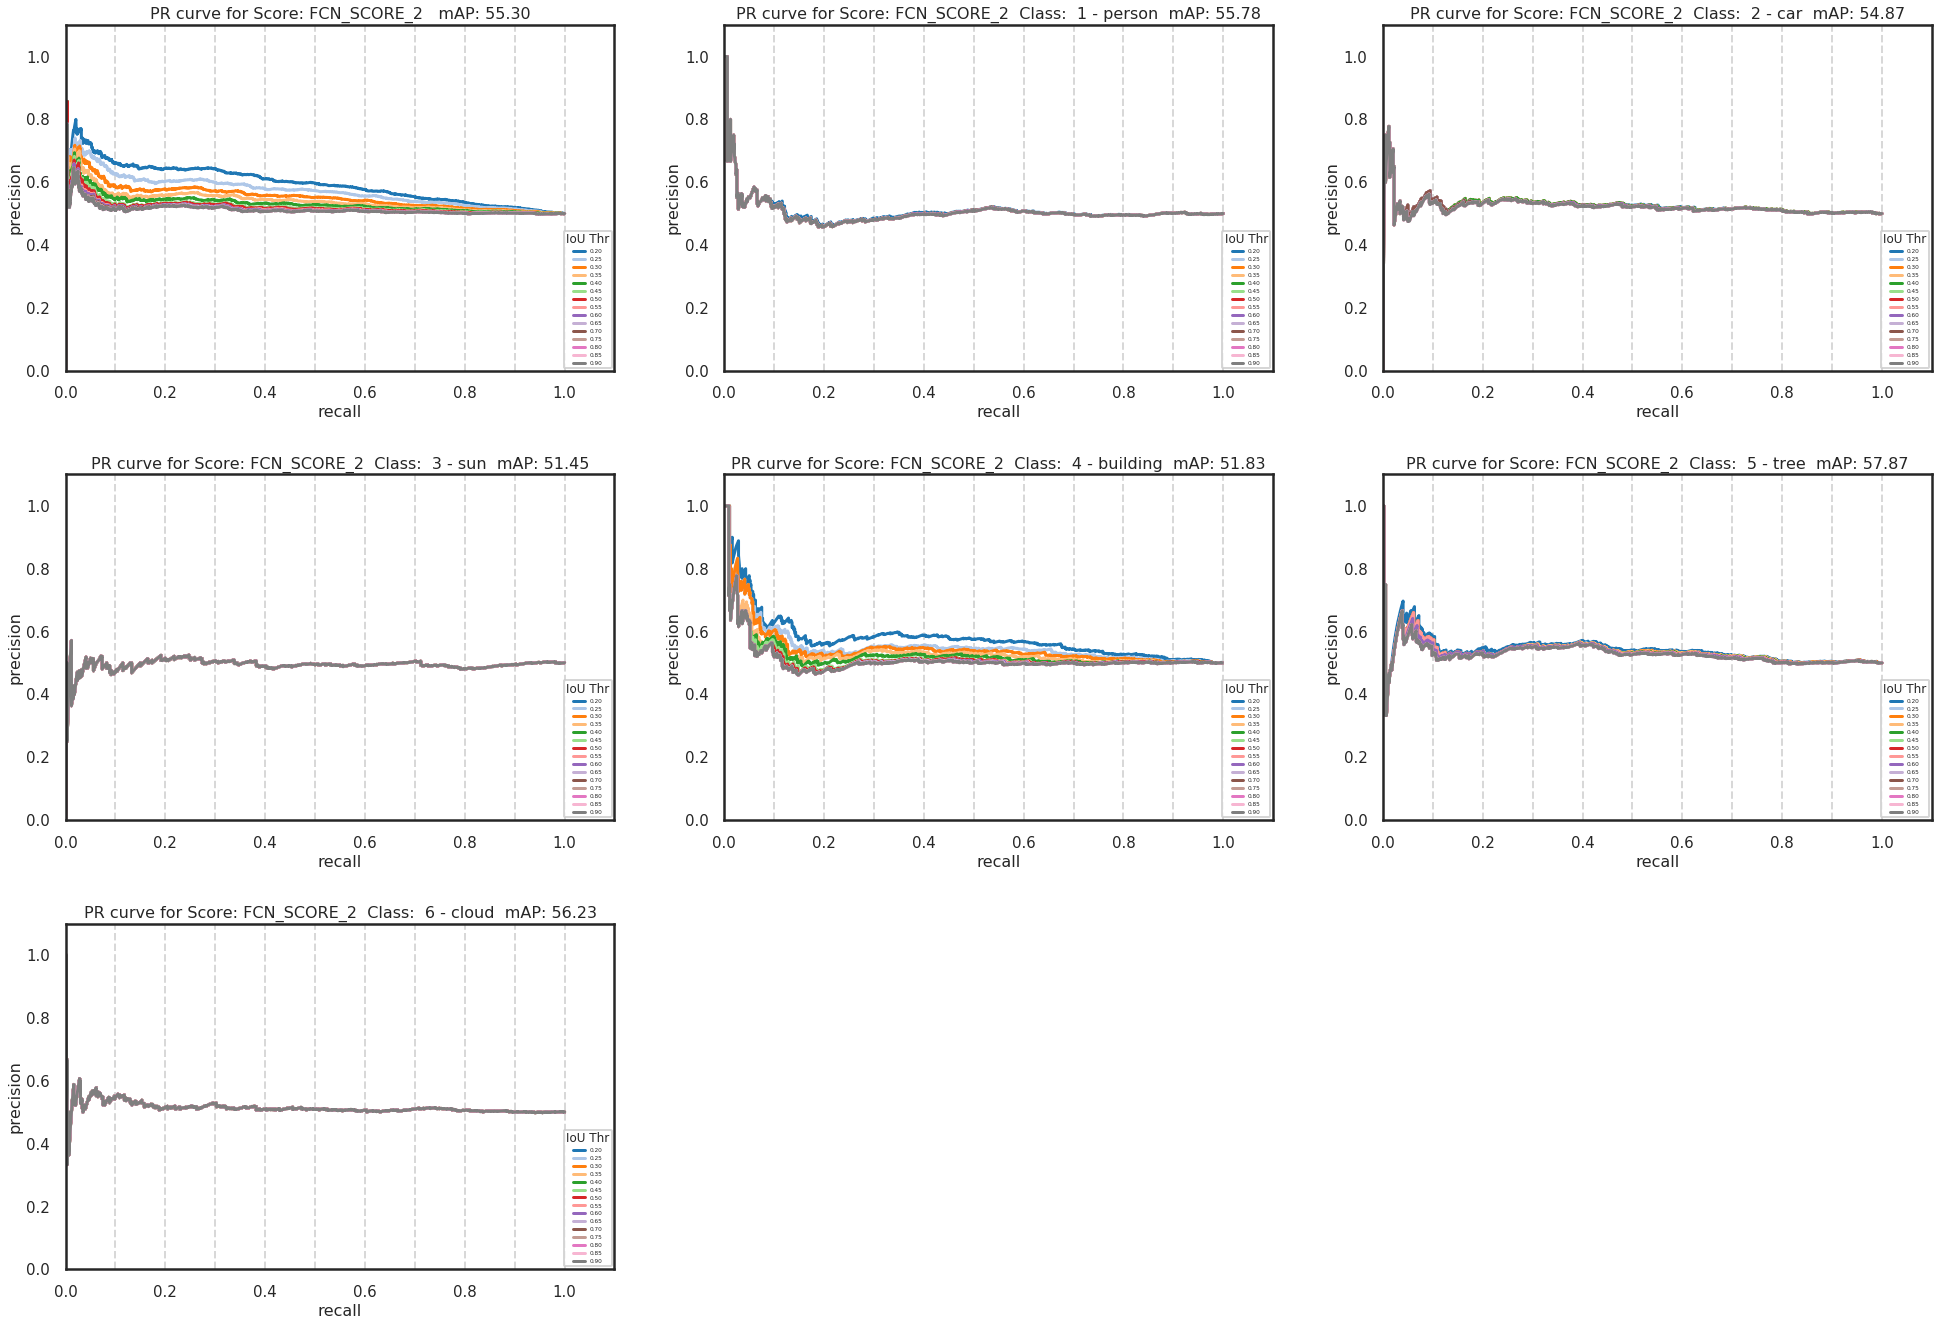

In [16]:
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_2', class_names = class_names )

## Indvidual classes - Plot mAP info for different scores (at a given IoU threshold)

### IoU = 0.5

col/rows:  2 4

                                                     AP @ IoU 0.50 Thresholds for Computed Scores                                                     

----------------------------------------------------------------------  scores  ----------------------------------------------------------------------
Id - ClassName           mrcnn_score_orig       fcn_score_2       fcn_score_1
------------------------------------------------------------------------------------------------------------------------------------------------------
 1 - person                        0.8084            0.7531            0.7453 
 2 - car                           0.9082            0.8781            0.8829 
 3 - sun                           0.9091            0.8901            0.8847 
 4 - building                      0.9071            0.8755            0.8696 
 5 - tree                          0.9056            0.8986            0.8993 
 6 - cloud                         0.9084            0.89

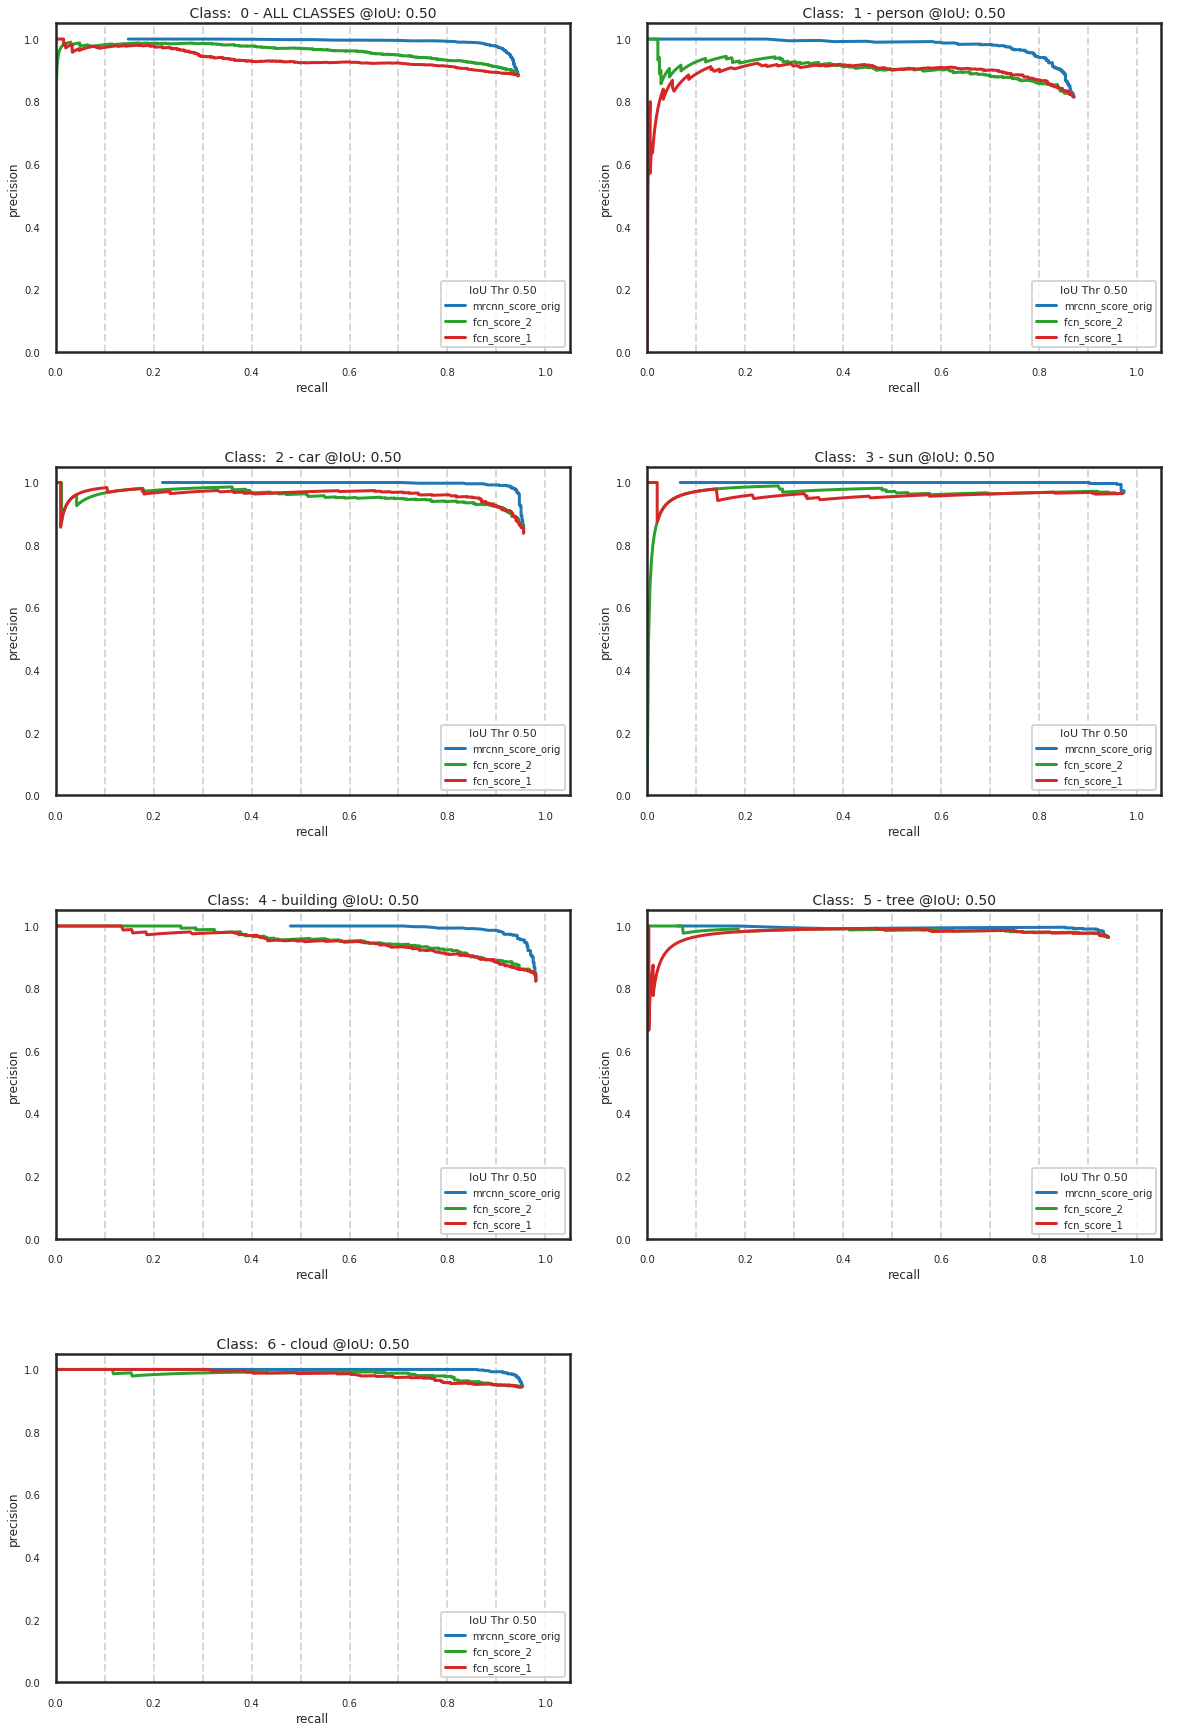

In [7]:
disp_classes = [0,1,2,3,4,5,6]  
# disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
# disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_0', 'fcn_score_0']
# disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_1', 'fcn_score_1']
# disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_1', 'mrcnn_score_1', 'fcn_score_1','fcn_score_2']
disp_scores = [ 'mrcnn_score_orig','fcn_score_2', 'fcn_score_1']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = disp_classes, class_names= CLASS_NAMES, iou = 0.5)

col/rows:  1 7

                                                     AP @ IoU 0.30 Thresholds for Computed Scores                                                     

----------------------------------------------------------------------  scores  ----------------------------------------------------------------------
Id - ClassName                fcn_score_1       fcn_score_2  mrcnn_score_orig
------------------------------------------------------------------------------------------------------------------------------------------------------
 1 - person                        0.8506            0.8555            0.8970 
 2 - car                           0.8855            0.8802            0.9086 
 3 - sun                           0.8969            0.9013            0.9091 
 4 - building                      0.8785            0.8812            0.9084 
 5 - tree                          0.9038            0.9036            0.9087 
 6 - cloud                         0.8994            0.90

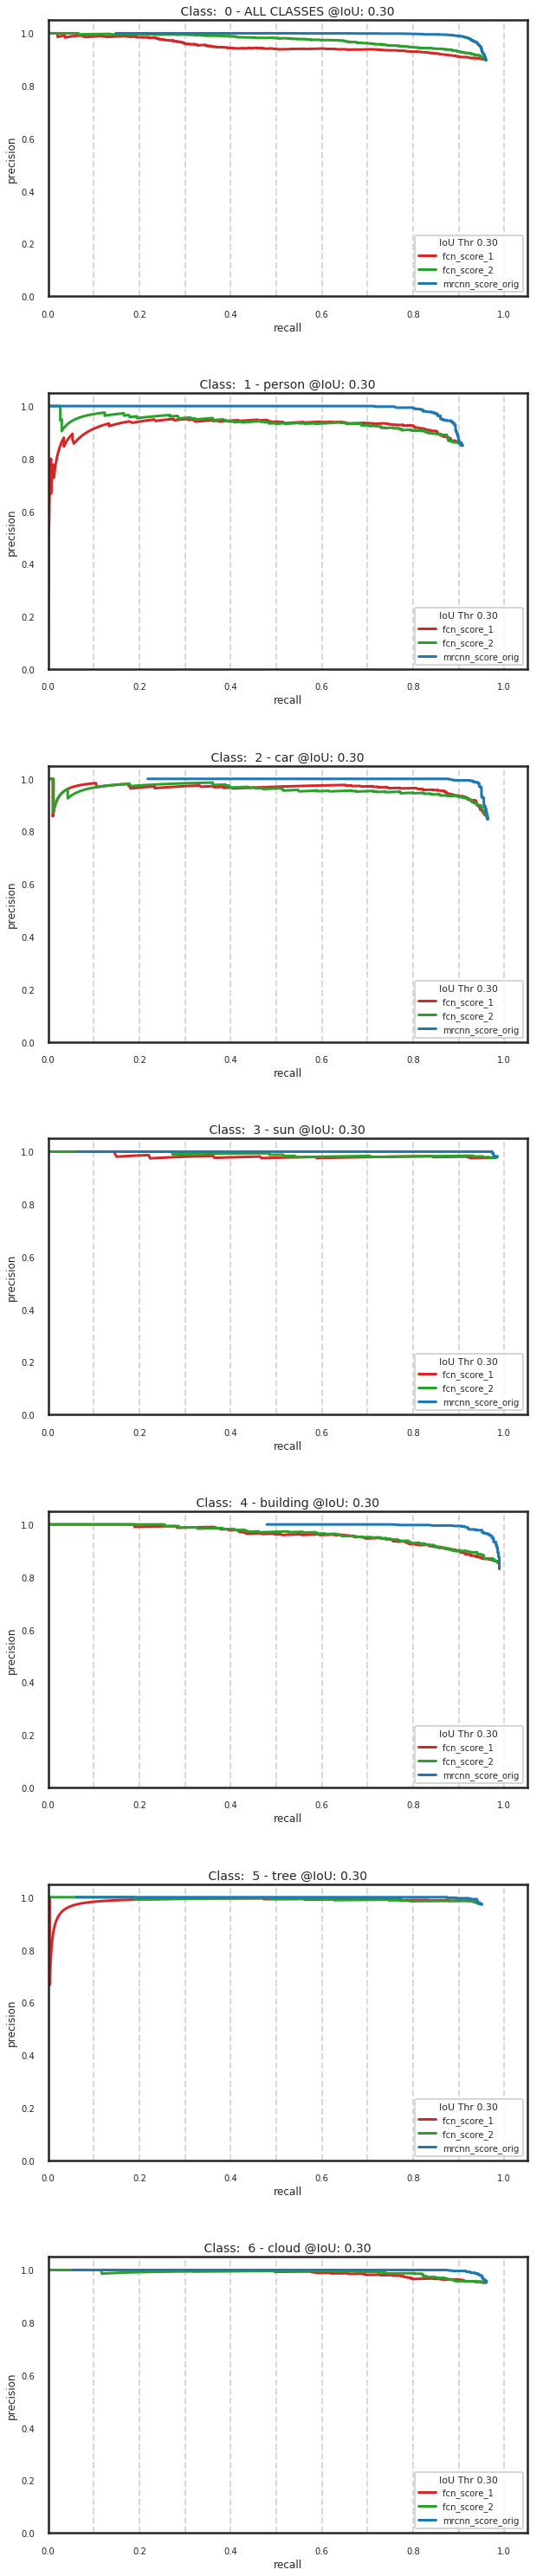

In [34]:
disp_classes = [0,1,2,3,4,5,6]  
# disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
# disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_0', 'fcn_score_0']
# disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_1', 'fcn_score_1']
# disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_1', 'fcn_score_1']
disp_scores  = [ 'fcn_score_1', 'fcn_score_2', 'mrcnn_score_orig']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = disp_classes, class_names= CLASS_NAMES, iou = 0.3, columns = 1)

### IoU = 0.5

col/rows:  1 7

                                                     AP @ IoU 0.50 Thresholds for Computed Scores                                                     

----------------------------------------------------------------------  scores  ----------------------------------------------------------------------
Id - ClassName                fcn_score_1       fcn_score_2  mrcnn_score_orig
------------------------------------------------------------------------------------------------------------------------------------------------------
 1 - person                        0.7453            0.7531            0.8084 
 2 - car                           0.8829            0.8781            0.9082 
 3 - sun                           0.8847            0.8901            0.9091 
 4 - building                      0.8696            0.8755            0.9071 
 5 - tree                          0.8993            0.8986            0.9056 
 6 - cloud                         0.8956            0.89

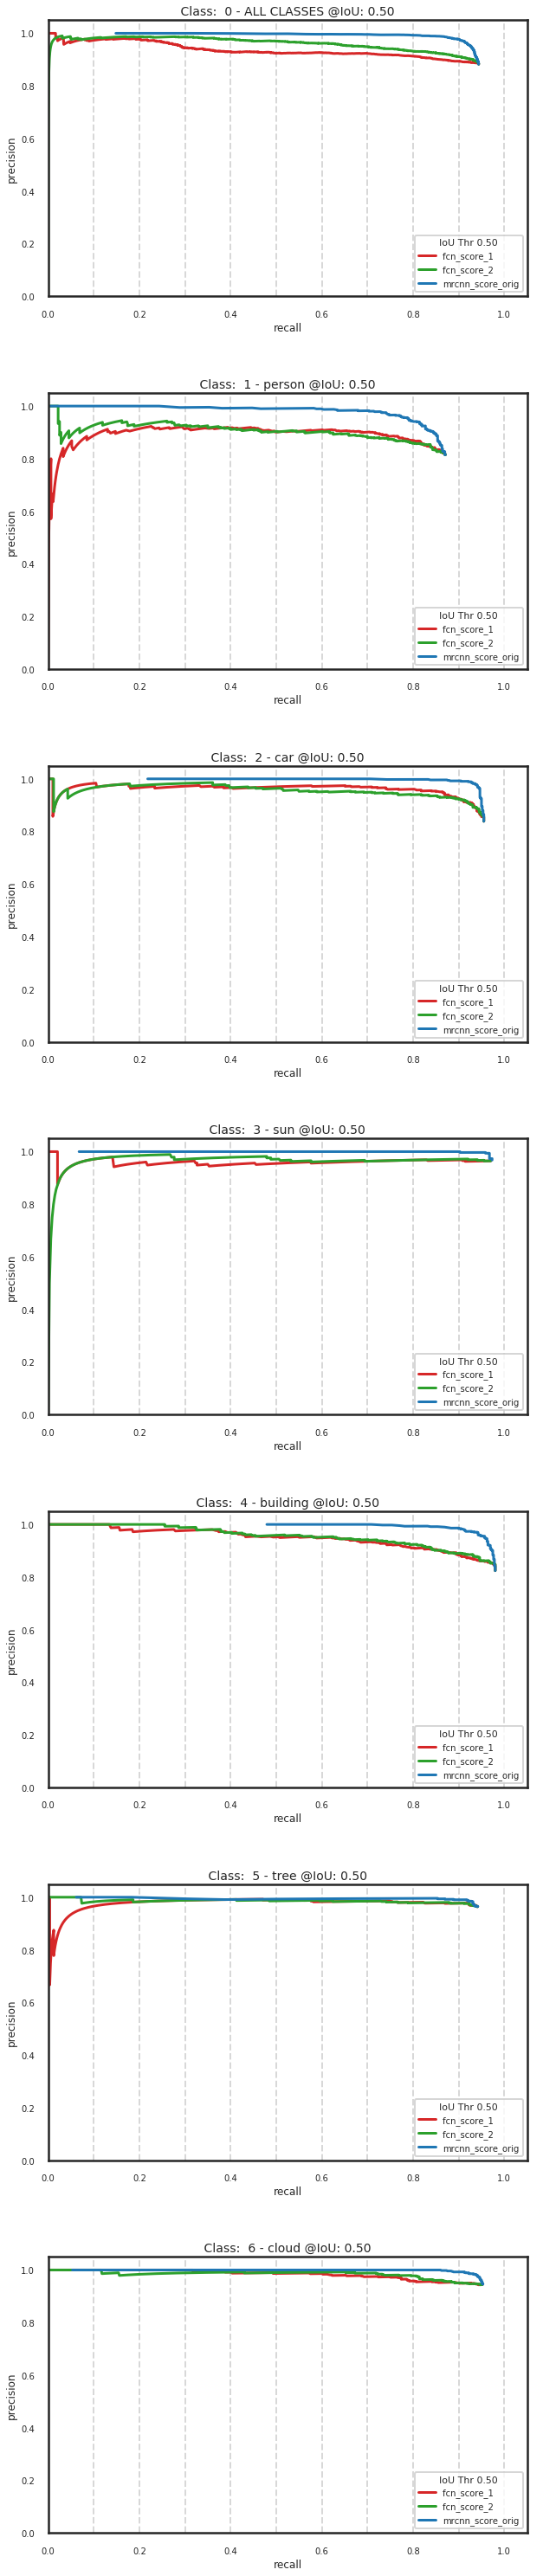

In [8]:
disp_classes = [0,1,2,3,4,5,6]  
# disp_classes = [3]  
# disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
disp_scores  = [ 'fcn_score_1', 'fcn_score_2', 'fcn_score_1_norm', 'fcn_score_2_norm']
disp_scores  = [ 'fcn_score_1', 'fcn_score_2', 'mrcnn_score_orig']
# disp_scores  = [ 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = disp_classes, class_names= CLASS_NAMES, iou = 0.5,columns = 1)

### IoU = 0.75

col/rows:  2 4

                                                     AP @ IoU 0.75 Thresholds for Computed Scores                                                     

----------------------------------------------------------------------  scores  ----------------------------------------------------------------------
Id - ClassName           mrcnn_score_orig     mrcnn_score_0     mrcnn_score_1     mrcnn_score_2       fcn_score_0       fcn_score_1       fcn_score_2
------------------------------------------------------------------------------------------------------------------------------------------------------
 1 - person                        0.1987            0.1734            0.2217            0.2199            0.1403            0.1313            0.1432 
 2 - car                           0.7507            0.7353            0.7204            0.7204            0.6729            0.6497            0.6551 
 3 - sun                           0.7871            0.7587            0.7647 

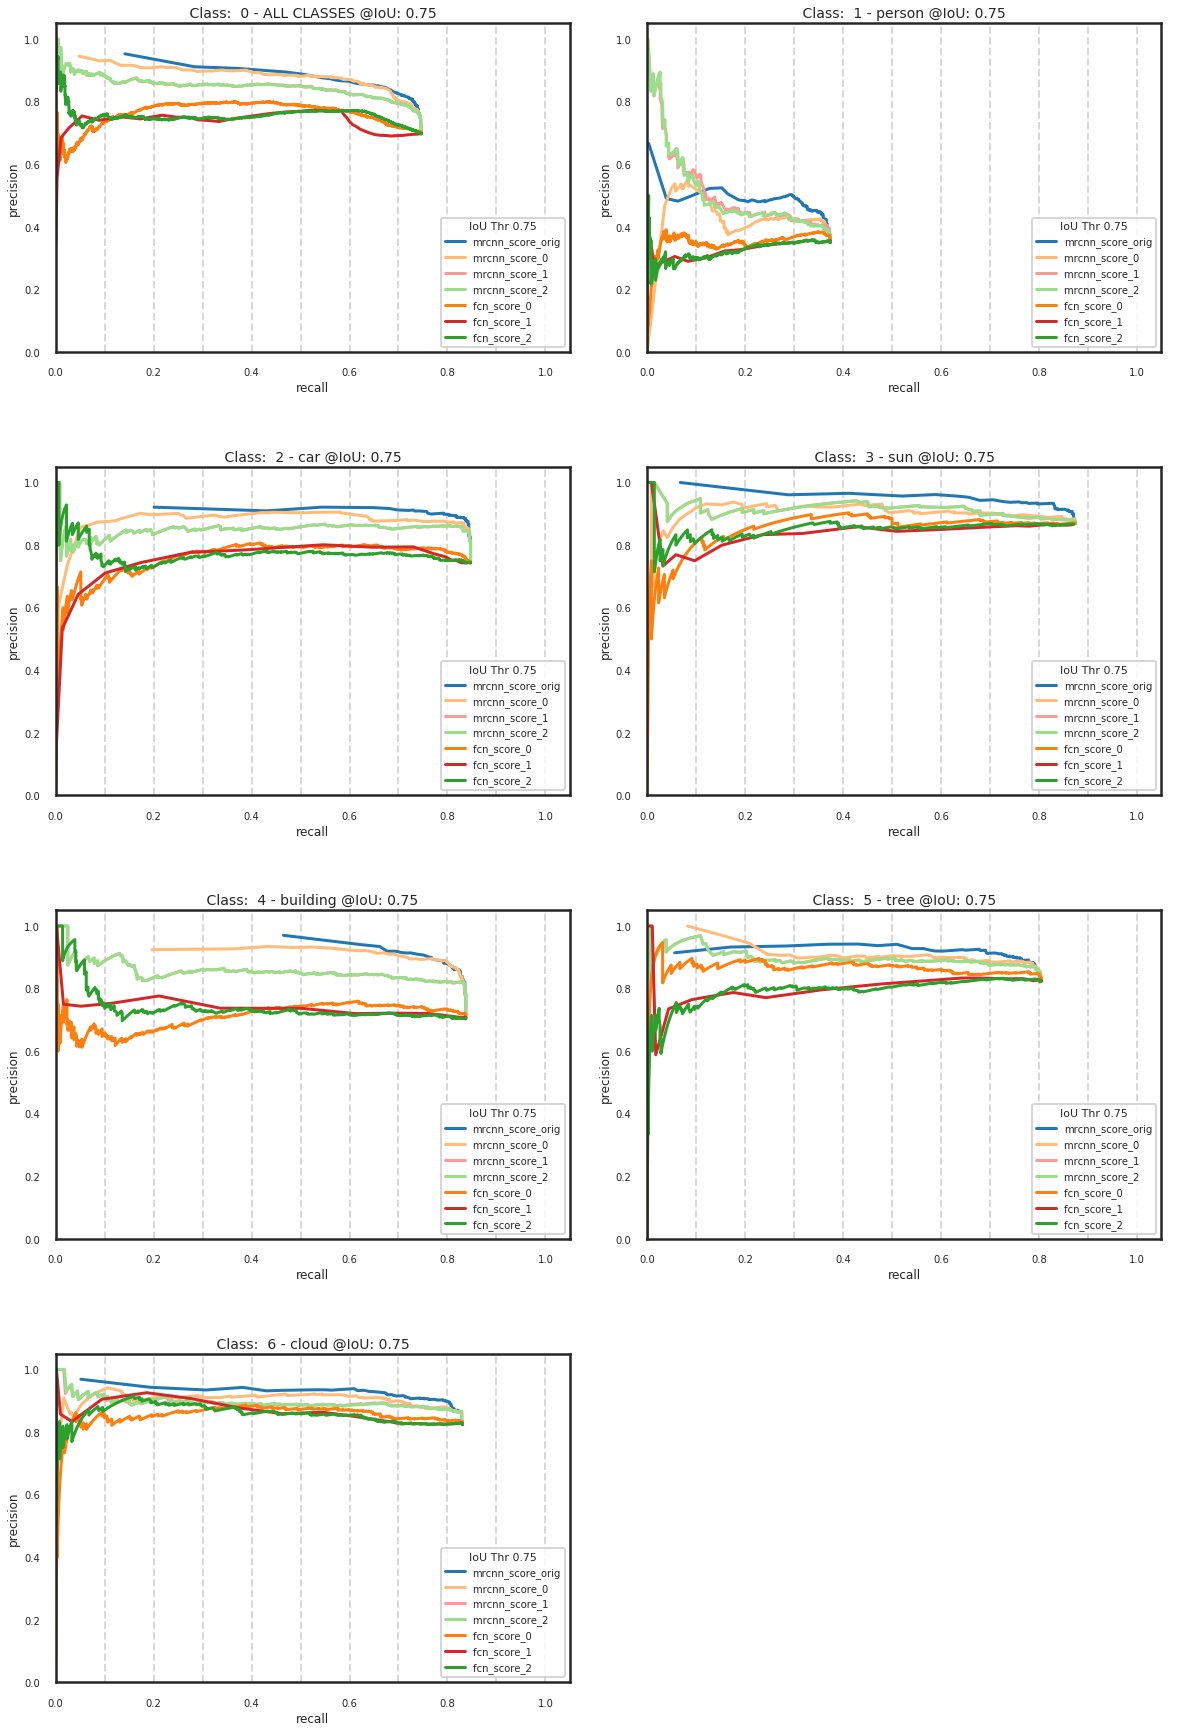

In [53]:
disp_classes = [0,1,2,3,4,5,6]  
disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = disp_classes, class_names= class_names, iou = 0.75)

### IoU = 0.9

col/rows:  2 4

                                                     AP @ IoU 0.90 Thresholds for Computed Scores                                                     

----------------------------------------------------------------------  scores  ----------------------------------------------------------------------
Id - ClassName           mrcnn_score_orig     mrcnn_score_2       fcn_score_2
------------------------------------------------------------------------------------------------------------------------------------------------------
 1 - person                        0.4637            0.4602            0.5574 
 2 - car                           0.5033            0.5564            0.5477 
 3 - sun                           0.4704            0.5073            0.5145 
 4 - building                      0.4603            0.5130            0.5077 
 5 - tree                          0.4555            0.4788            0.5763 
 6 - cloud                         0.4753            0.51

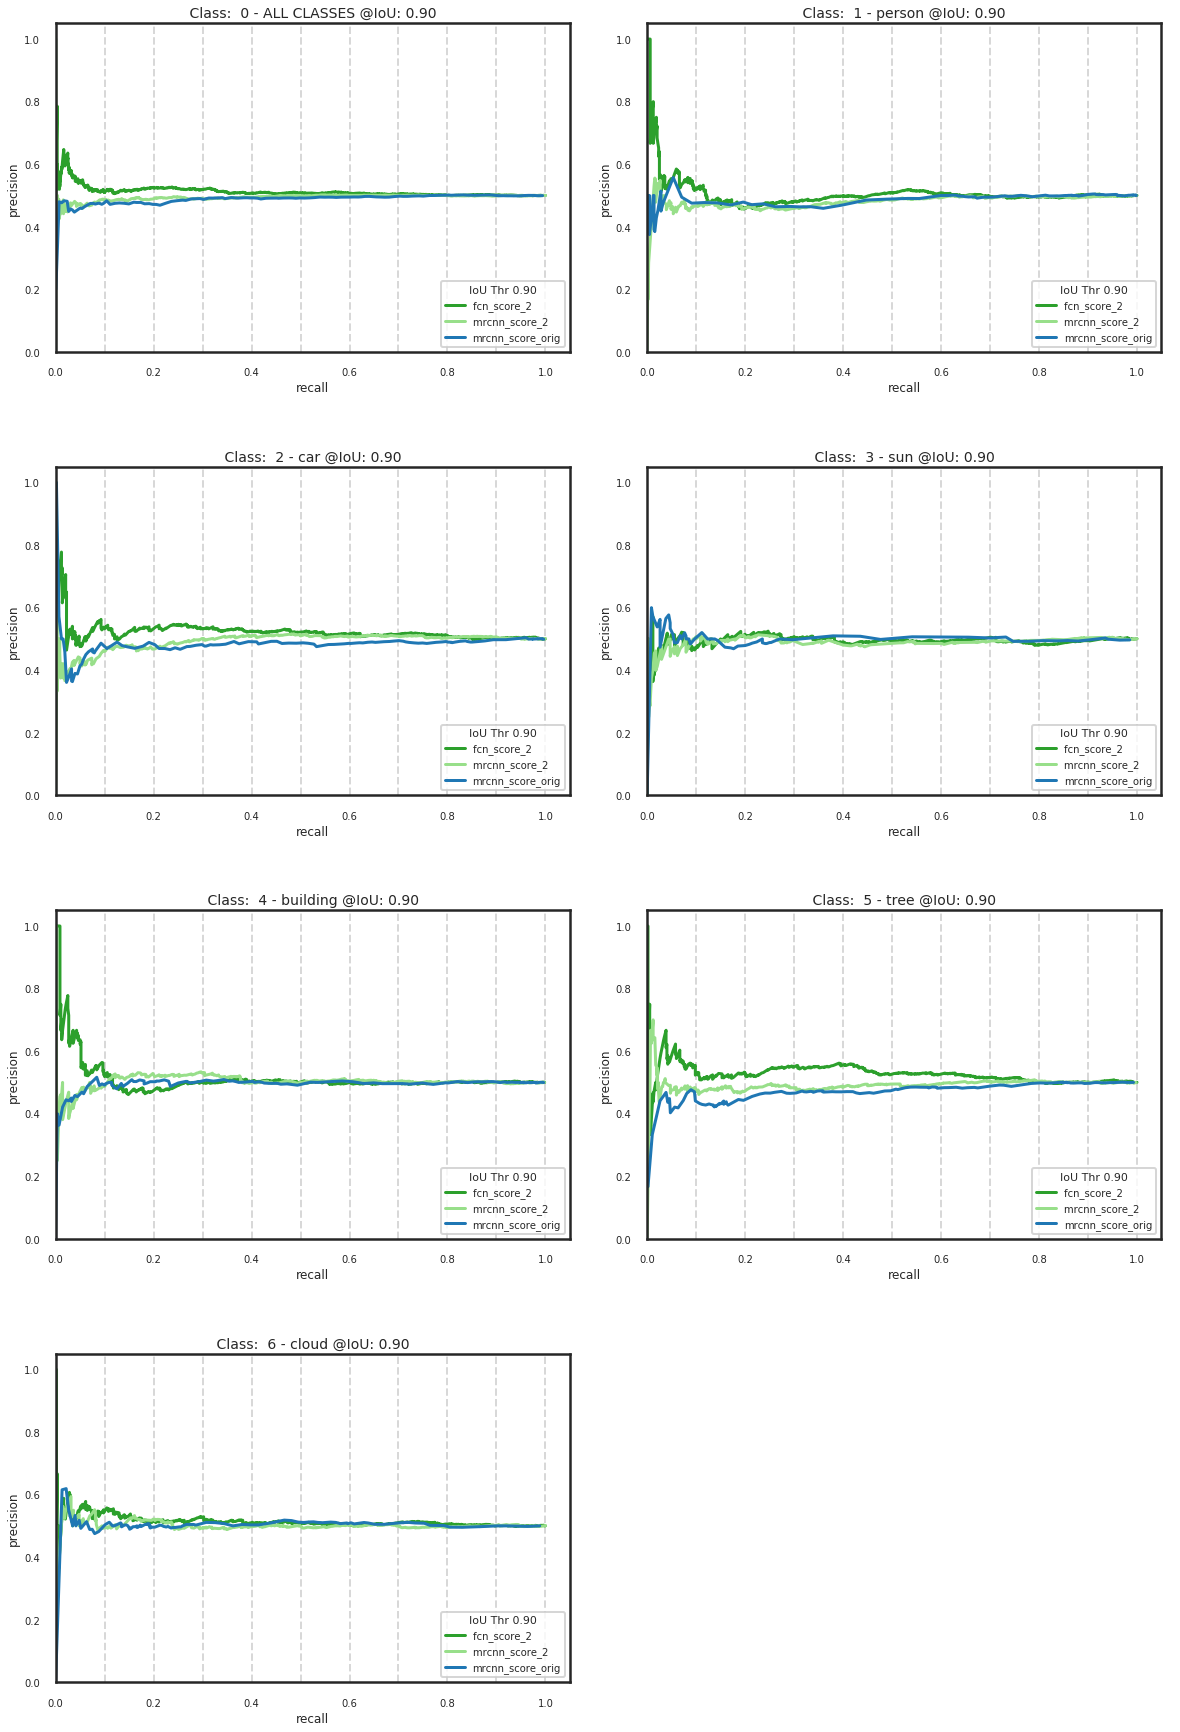

In [59]:
disp_classes = [0,1,2,3,4,5,6]  
# disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_0', 'fcn_score_0']
disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_1', 'fcn_score_1']
disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_2', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = disp_classes, class_names= class_names, iou = 0.9)

In [166]:
objs_by_cls = np.zeros((7))
for img in sorted(gt_boxes.keys()):
#     print(img, gt_boxes[img]['class_ids'], np.bincount(gt_boxes[img]['class_ids'], minlength = 7))
    objs_by_cls += np.bincount(gt_boxes[img]['class_ids'], minlength = 7)
for i in class_ids:    
    print('{:3d} {:20s} {:6d}'.format(i, class_names[i], int(objs_by_cls[i])))    

  1 person                  637
  2 car                     582
  3 sun                     340
  4 building                559
  5 tree                    569
  6 cloud                   602


## Code from `calculate_mean_ap.py`

### `display pr_info one class()` - `display_pr_info_subset()`

In [12]:
BLUE     = '#1f77b4'
LBLUE    = '#aec7e8'
ORANGE   = '#ff7f0e'
LORANGE  = '#ffbb78'
GREEN    = '#2ca02c'
LGREEN   = '#98df8a'
RED      = '#d62728'
LRED     = '#ff9896'
PURPLE   = '#9467bd'
LPURPLE  = '#c5b0d5'
BROWN    = '#8c564b'
LBROWN   = '#c49c94'
PINK     = '#e377c2'
LPINK    = '#f7b6d2'
GRAY     = '#7f7f7f'
LGRAY    = '#c7c7c7'
GOLD     = '#bcbd22'
LGOLD    = '#dbdb8d'
AQUA     = '#17becf'
LAQUA    = '#9edae5'
SCORE_COLORS = {  'mrcnn_score_orig':  BLUE
                , 'mrcnn_score_0'   :  LORANGE
                , 'mrcnn_score_1'   :  LRED
                , 'mrcnn_score_2'   :  LGREEN
                , 'fcn_score_0'     :  ORANGE 
                , 'fcn_score_1'     :  RED
                , 'fcn_score_2'     :  GREEN}

##------------------------------------------------------------------------------------------
##   Plot PR Curves for multiple calculated scores - for one class
##------------------------------------------------------------------------------------------
def display_pr_info_one_class(class_data, class_id, class_name, scores = None, iou = None , ax = None ):
    avg_precs = {}
    iou_thrs = {}
    score_keys = []
    iou_key = np.round(iou,2)
    
    if ax is None:
        plt.figure(figsize=(15,10))
        ax = plt.gca()
    print('Disp scores: ', scores)
    
    for idx, score_key in enumerate(scores):
#         if  scores is not None and score_key not in  scores:
#             continue        
#         print('score_key is: {:20s} iou: {:6.3f}  avg_prec: {:10.4f}'.format(score_key,  iou_key, class_data[score_key][iou_key]['avg_prec']))
#         score_keys.append(score_key)
        avg_precs[score_key] = class_data[score_key][iou_key]['avg_prec']
        precisions = class_data[score_key][iou_key]['precisions']
        recalls    = class_data[score_key][iou_key]['recalls']
        label      = '{:15s}'.format(score_key)
        
        score_idx  = scores.index(score_key)
        print('idx: ', idx, ' Score_key: ' , score_key, 'Score Index: ' , score_idx, 'color:', SCORE_COLORS[score_key])
        
        #### ax = plot_pr_curve(precisions, recalls, label= label, color=COLORS[idx*2], ax=ax)
        ax.plot(recalls, precisions, label=label,  color=SCORE_COLORS[score_key])


    ax.set_title(' Class: {:2d} - {} @IoU: {:4.2f} '.format(class_id, class_name, iou), fontsize=14)
    ax.set_xlabel('recall   ', fontsize= 12)
    ax.set_ylabel('precision', fontsize= 12)
    ax.tick_params(axis='both', labelsize = 10)
    ax.set_xlim([0.0,0.2])
    ax.set_ylim([0.3,0.7])
    leg = plt.legend(loc='lower right',frameon=True, fontsize = 10, markerscale = 6)
    leg.set_title('IoU Thr {:.2f}'.format(iou_key),prop={'size':11})
                  
    for xval in np.linspace(0.0, 1.0, 11):
        plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed', linewidth=2)
                         
    return avg_precs

##------------------------------------------------------------------------------------------
##   Plot PR Curves for multiple calculated scores - for one class
##------------------------------------------------------------------------------------------
def display_pr_info_subset(class_data, class_id, class_name, scores = None, iou = None , ax = None ):
    iou_key = np.round(iou,2)
    
    if ax is None:
        plt.figure(figsize=(15,10))
        ax = plt.gca()
    print('Disp scores: ', scores)
    
    for idx, score_key in enumerate(scores):
#         if  scores is not None and score_key not in  scores:
#             continue        
#         print('score_key is: {:20s} iou: {:6.3f}  avg_prec: {:10.4f}'.format(score_key,  iou_key, class_data[score_key][iou_key]['avg_prec']))
#         score_keys.append(score_key)
        avg_precs  = class_data['avg_prec']
        precisions = class_data['precisions']
        recalls    = class_data['recalls']
        label      = '{:15s}'.format(score_key)
#         print('precisions:', precisions[::-1].round(4))
#         print('recalls   :', recalls[::-1].round(4))
        score_idx  = scores.index(score_key)
        print('idx: ', idx, ' Score_key: ' , score_key, 'Score Index: ' , score_idx, 'color:', SCORE_COLORS[score_key])
        
        #### ax = plot_pr_curve(precisions, recalls, label= label, color=COLORS[idx*2], ax=ax)
        ax.plot(recalls, precisions, label=label,  color=SCORE_COLORS[score_key])


    ax.set_title(' Class: {:2d} - {} @IoU: {:4.2f} '.format(class_id, class_name, iou), fontsize=14)
    ax.set_xlabel('recall   ', fontsize= 12)
    ax.set_ylabel('precision', fontsize= 12)
    ax.tick_params(axis='both', labelsize = 10)
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.1])
    leg = plt.legend(loc='lower right',frameon=True, fontsize = 10, markerscale = 6)
    leg.set_title('IoU Thr {:.2f}'.format(iou_key),prop={'size':11})
                  
    for xval in np.linspace(0.0, 1.0, 11):
        plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed', linewidth=2)
                         
    return avg_precs



### `get_avg_precsion_at_iou()` dev version

In [93]:
import itertools 
def orig_get_avg_precision_at_iou(gt_boxes, pr_boxes, iou_thr=0.5, score_key = 'scores', verbose = 0):
    from copy import deepcopy
    """Calculates average precision at given IoU threshold.

    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (list of list of floats): list of locations of predicted
            objects as [xmin, ymin, xmax, ymax]
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.

    Returns:
        dict: avg precision as well as summary info about the PR curve

        Keys:
            'avg_prec' (float): average precision for this IoU threshold
            'precisions' (list of floats): precision value for the given
                model_threshold
            'recall' (list of floats): recall value for given
                model_threshold
            'models_thrs' (list of floats): model threshold value that
                precision and recall were computed for.
    """
    ## 01-05-19: added to prevent corruption of original data passed to function
    ## TODO: merge pred_boxes and pred_boxes_pruned to conserve memory
    pred_boxes = deepcopy(pr_boxes)
    
    model_scores_map    = cmap2.dev_get_model_scores_map(pred_boxes, score_key = score_key)
    
    sorted_model_scores = sorted(model_scores_map.keys())
    
    n_items = list(itertools.islice(gt_boxes.keys(),5))
    print(' Number of GT BBoxes :', len(gt_boxes.keys()), n_items)
    print(' model_scores_map    :', len(model_scores_map.keys()))
    print(' sorted_model_scores :', len(sorted_model_scores))
    print(' sorted_model_scores[:-1] :', sorted_model_scores[:-1])
    print(' sorted_model_scores      :', sorted_model_scores)
    pp.pprint(model_scores_map)
    print()


    
    
    ## Sort the predicted boxes in ascending score order (lowest scoring boxes first):
    for img_id in sorted(pred_boxes.keys()):
        if verbose:
            print()
            print('image_id : ', img_id)
    #         print('--------------------------')
            print('  Before Sort - ',score_key.ljust(16), ':' ,pred_boxes[img_id][score_key],' ',pred_boxes[img_id]['boxes'] )        
        
        arg_sort = np.argsort(pred_boxes[img_id][score_key])        
        pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id][score_key])[arg_sort].tolist()
        pred_boxes[img_id]['boxes']  = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

        if verbose:
    #         print()
            print('  After Sort  - ',score_key.ljust(16), ':' ,pred_boxes[img_id]['scores'],' ',pred_boxes[img_id]['boxes'] )
    
    pred_boxes_pruned = deepcopy(pred_boxes)

    precisions  = []
    recalls     = []
    model_thrs  = []
    tps         = []
    fps         = []
    fns         = []
    img_results = {}
    
    # Loop over model score thresholds and calculate precision, recall
    print()
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):   ## changed from thsi to line below

        # On first iteration, define img_results for the first time:
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        if verbose:
            print('------------------------------------------------------------------------------')
            print('index: ', ithr, 'model_scr_thr: ', model_score_thr, 'Len(img_ids): ', len(img_ids))
            print('------------------------------------------------------------------------------')   
        
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]['boxes']
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:      ## Changed this from <= model_score_thr to < model_score_thr
                    # pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break

            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores'] = pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes']  = pred_boxes_pruned[img_id]['boxes'][start_idx:]
            if verbose:
                print()
                print('   image_id : ', img_id,'   scr_threshold:', model_score_thr,  '   pred_boxes start_idx:', start_idx)
                print('   -------------------------------------------------------------------------------------------')  
            
            # Recalculate image results for this image
            img_results[img_id] = cmap2.dev_get_single_image_results(
                gt_boxes_img, pred_boxes_pruned[img_id], iou_thr, verbose = verbose)

            # print('Start Idx is ', start_idx)
            if verbose:
                print('   gt_boxes_img     :', gt_boxes_img)
                print('   pred_boxes_pruned:', pred_boxes_pruned[img_id]['boxes'])
                print('   img_results      :', img_results[img_id])
#                 print('   -')
        
        prec, rec, true_pos, false_pos, false_neg  = cmap2.dev_calc_precision_recall(img_results)
        if verbose:
            print()
            print(' Img Results for score threshold ', model_score_thr, ':')
            for img_key in img_results:
                print('  ', img_key, ':', img_results[img_key])
        ttl = true_pos + false_pos + false_neg
        print()
#         print("#########################################################################################################################")
        print(' calc_PR():  score_thr: {:6.4f}       TP: {:6d}      FP: {:6d}    FN: {:6d}   TP+FN : {:6d}     Total: {:6d}   '\
              '   Precision: {:6.4f}     Recall   : {:6.4f}'.format(model_score_thr, true_pos, false_pos, false_neg, true_pos+false_neg, ttl,
                                                                     round(prec,4), round(rec,4)))
        print('#'*100)
        
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)
        tps.append(true_pos)
        fps.append(false_pos)
        fns.append(false_neg)

    precisions = np.array(precisions)
    recalls    = np.array(recalls)
    tps     = np.array(tps)
    fps     = np.array(fps)
    fns     = np.array(fns)
    # print('final precsions:', precisions)
    # print('final recall   :', recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    return {
        'avg_prec'      : avg_prec,
        'precisions'    : precisions,
        'recalls'       : recalls,
        'model_thrs'    : model_thrs,
        'prec_at_rec'   : prec_at_rec, 
        'tps'           : tps,
        'fps'           : fps, 
        'fns'           : fns
    }


###  Use `all_data`

In [150]:
for i in  [1]:
    print('all_data[',i,'] keys:', all_data[i].keys())
    for j in ['fcn_score_2']:
        print('all_data[',i,'][',j,'] keys:', all_data[i][j].keys())
        for k in all_data[i][j].keys():
            print()
            print('all_data[',i,'][',j,'][',k,'] keys:', all_data[i][j][k].keys())   
            for l in all_data[i][j][k]:
                print('all_data[',i,'][',j,'][',k,'][',l,'] type:', type(all_data[i][j][k][l]))               

all_data[ 1 ] keys: dict_keys(['fcn_score_1', 'fcn_score_0', 'mrcnn_score_2', 'fcn_score_2', 'mrcnn_score_1', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_orig'])
all_data[ 1 ][ fcn_score_2 ] keys: dict_keys([0.2, 0.25, 0.35, 0.6, 0.5, 0.7, 0.65, 0.3, 0.55, 0.8, 0.4, 0.9, 0.45, 0.85, 0.75])

all_data[ 1 ][ fcn_score_2 ][ 0.2 ] keys: dict_keys(['model_thrs', 'recalls', 'avg_prec', 'prec_at_rec', 'iou', 'precisions'])
all_data[ 1 ][ fcn_score_2 ][ 0.2 ][ model_thrs ] type: <class 'list'>
all_data[ 1 ][ fcn_score_2 ][ 0.2 ][ recalls ] type: <class 'numpy.ndarray'>
all_data[ 1 ][ fcn_score_2 ][ 0.2 ][ avg_prec ] type: <class 'numpy.float64'>
all_data[ 1 ][ fcn_score_2 ][ 0.2 ][ prec_at_rec ] type: <class 'list'>
all_data[ 1 ][ fcn_score_2 ][ 0.2 ][ iou ] type: <class 'numpy.float64'>
all_data[ 1 ][ fcn_score_2 ][ 0.2 ][ precisions ] type: <class 'numpy.ndarray'>

all_data[ 1 ][ fcn_score_2 ][ 0.25 ] keys: dict_keys(['model_thrs', 'recalls', 'avg_prec', 'prec_at_rec', 'iou', 'precision

dict_keys(['fcn_score_1', 'fcn_score_0', 'mrcnn_score_2', 'fcn_score_2', 'mrcnn_score_1', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_orig'])
dict_keys(['model_thrs', 'recalls', 'avg_prec', 'prec_at_rec', 'iou', 'precisions'])
Disp scores:  ['mrcnn_score_1']
idx:  0  Score_key:  mrcnn_score_1 Score Index:  0 color: #ff9896


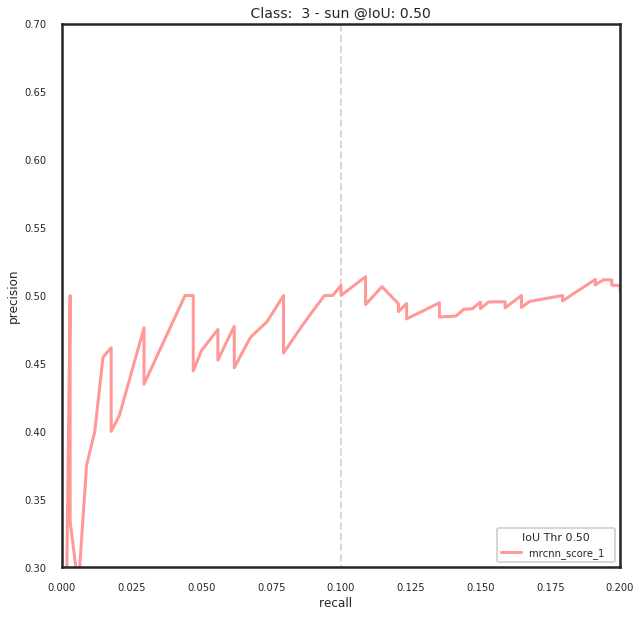

In [82]:
class_id = 3
iou = 0.5
disp_scores = ['mrcnn_score_orig', 'mrcnn_score_2', 'fcn_score_2']
disp_scores = ['fcn_score_1']
disp_scores = ['mrcnn_score_1']
print(all_data[3].keys())
print(all_data[3]['fcn_score_1'][0.5].keys())
# class_precs = cmap.plot_pr_curves_by_scores_for_one_class(all_data[class_id], class_id, class_names[class_id], scores = disp_scores, iou = iou)    
class_precs = display_pr_info_one_class(all_data[class_id], class_id, class_names[class_id], scores = disp_scores, iou = iou)    


#### Print precision recalls from all_data

In [9]:
iou_key = 0.5
class_id = 3
for i, score_key in enumerate(['fcn_score_2']):
    prec_at_rec= all_data[class_id][score_key][iou_key]['prec_at_rec']
    precisions = all_data[class_id][score_key][iou_key]['precisions']
    recalls    = all_data[class_id][score_key][iou_key]['recalls']
    print(' i: ', i, 'score_key:', score_key)
#     prec = ''.join(['{:.4f}  '.format(p) for p in precisions])
#     prec = ''.join(['{:.4f}  '.format(p) for p in precisions])
    num_prs = precisions.shape[0]
    print(len(prec_at_rec))
    print(len(precisions), num_prs)
    print(len(recalls), recalls.shape)
    print('         RECALL    PRECISION')
    print('         ------    ---------')
    
    for j in range(num_prs-1,0,-1):
        print('{:4d}     {:.4f}     {:.4f} '.format(j, recalls[j], precisions[j]))

 i:  0 score_key: fcn_score_2
11
561 561
561 (561,)
         RECALL    PRECISION
         ------    ---------
 560     0.0000     0.0000 
 559     0.0029     0.5000 
 558     0.0029     0.3333 
 557     0.0029     0.2500 
 556     0.0059     0.4000 
 555     0.0088     0.5000 
 554     0.0118     0.5714 
 553     0.0118     0.5000 
 552     0.0118     0.4444 
 551     0.0118     0.4000 
 550     0.0118     0.3636 
 549     0.0147     0.4167 
 548     0.0147     0.3846 
 547     0.0176     0.4286 
 546     0.0176     0.4000 
 545     0.0206     0.4375 
 544     0.0235     0.4706 
 543     0.0235     0.4444 
 542     0.0265     0.4737 
 541     0.0265     0.4500 
 540     0.0294     0.4762 
 539     0.0294     0.4545 
 538     0.0324     0.4783 
 537     0.0324     0.4583 
 536     0.0353     0.4800 
 535     0.0382     0.5000 
 534     0.0412     0.5185 
 533     0.0412     0.5000 
 532     0.0412     0.4828 
 531     0.0441     0.5000 
 530     0.0441     0.4839 
 529     0.0471     0.

### Use Subset of all Images

#### Build a subset of `gt_boxes_subset` and `pr_boxes_suset` for testing

In [99]:
#     print('-----------------------')
#     print('gt boxes           : ', len(gt_boxes_class[class_id][key]['boxes']), gt_boxes_class[class_id][key]['boxes'])
#     print('pr boxes           : ', pr_boxes_class[class_id][key]['boxes'])
#     print('class_ids       : ',pr_boxes_class[class_id][key]['class_ids'])
#     print('det_ind         : ',pr_boxes_class[class_id][key]['det_ind'])
#     print('fcn_score_2     : ',pr_boxes_class[class_id][key]['fcn_score_2'])
#     print('mrcnn_score_orig: ',pr_boxes_class[class_id][key]['mrcnn_score_orig'])
#     print('scores          : ',pr_boxes_class[class_id][key]['scores'])
#     print()
#     pp.pprint(gt_boxes_class[class_id][key])

gt_boxes_subset = {}
pr_boxes_subset = {}
class_id    = 1
num_samples = 100
gt_boxes_subset[class_id] = {}
pr_boxes_subset[class_id] = {}
gt_boxes_class_keys = sorted(gt_boxes_class[class_id].keys())

print(' Total number of GT boxes for class', class_id, 'is :',len(gt_boxes_class_keys))
# gt_boxes_class_keys.remove('newshapes_00087')  <-- remove for correction of SUN PR Curve

print(' Total number of GT boxes for class', class_id, 'is :',len(gt_boxes_class_keys))

# for key in gt_boxes_class_keys[:num_samples]:
gt_bbox_count = 0 
pr_bbox_count = 0
 
for key in gt_boxes_class_keys[5:8]:   ## problem is image number 231
    
    pr_boxes_subset[class_id].setdefault(key,pr_boxes_class[class_id][key])
    gt_boxes_subset[class_id].setdefault(key,gt_boxes_class[class_id][key])
    gt_bbox_count += len(gt_boxes_class[class_id][key]['boxes'])
    pr_bbox_count += len(pr_boxes_class[class_id][key]['boxes'])
#     print('-----------------------')
    print('Key: ', key)
    
print(' gt_boxes_subset[class].keys: ', len(gt_boxes_subset[class_id].keys()), 'pr_boxes_subset[class].keys :', len(pr_boxes_subset[class_id].keys()))
print(' gt_bbox_count, ', gt_bbox_count, 'pr_bbox_count ', pr_bbox_count )
# for img_id, val in pr_boxes_subset[3].items():
#     print(img_id, val)

 Total number of GT boxes for class 1 is : 348
 Total number of GT boxes for class 1 is : 348
Key:  newshapes_00010
Key:  newshapes_00011
Key:  newshapes_00013
 gt_boxes_subset[class].keys:  3 pr_boxes_subset[class].keys : 3
 gt_bbox_count,  6 pr_bbox_count  10


###  Calculate fcn_score_1 on class

####  call `dev_avg_get_precision_at_iou()` on pr_boxes_subset

In [108]:
iou_key = 0.5
# score_key = 'mrcnn_score_orig'
score_key = 'fcn_score_1'
# score_key = 'fcn_score_1'
verbose   = True
print(' class     :', class_id)
print(' iou_key   :', iou_key)
print(' score_key :', score_key)
class_data    = cmap2.dev_get_avg_precision_at_iou(gt_boxes_subset[class_id], pr_boxes_subset[class_id], iou_thr=iou_key, score_key = score_key, verbose = verbose)
# class_data2   = orig_get_avg_precision_at_iou(gt_boxes_subset[class_id], pr_boxes_subset[class_id], iou_thr=iou_key, score_key = score_key, verbose = False)

# pp.pprint(class_data)

 class     : 1
 iou_key   : 0.5
 score_key : fcn_score_1
 Number of GT BBoxes : 3 ['newshapes_00010', 'newshapes_00013', 'newshapes_00011']
 model_scores_map    : 10
 sorted_model_scores : 10
 sorted_model_scores[:-1] : 0.0332 0.0843
 sorted_model_scores      : [0.0332, 0.0367, 0.04, 0.0472, 0.048, 0.0632, 0.0637, 0.0696, 0.0698, 0.0843]
{ 0.0332: ['newshapes_00010'],
  0.0367: ['newshapes_00013'],
  0.04: ['newshapes_00010'],
  0.0472: ['newshapes_00010'],
  0.048: ['newshapes_00010'],
  0.0632: ['newshapes_00010'],
  0.0637: ['newshapes_00010'],
  0.0696: ['newshapes_00013'],
  0.0698: ['newshapes_00011'],
  0.0843: ['newshapes_00013']}


image_id :  newshapes_00010
  Before Sort -  fcn_score_1      : [0.0637, 0.0332, 0.0632, 0.0472, 0.04, 0.048]   [[74.0, 20.0, 103.0, 27.0], [76.0, 36.0, 105.0, 42.0], [68.0, 57.0, 92.0, 63.0], [77.0, 33.0, 104.0, 38.0], [66.0, 61.0, 97.0, 73.0], [71.0, 24.0, 101.0, 33.0]]
  After Sort  -  fcn_score_1      : [0.0332, 0.04, 0.0472, 0.048, 0.0632, 0.06

Disp scores:  ['fcn_score_1']
idx:  0  Score_key:  fcn_score_1 Score Index:  0 color: #d62728
Disp scores:  ['fcn_score_1']
idx:  0  Score_key:  fcn_score_1 Score Index:  0 color: #d62728
idx:  0  Score_key:  fcn_score_1 Score Index:  0 color: #d62728


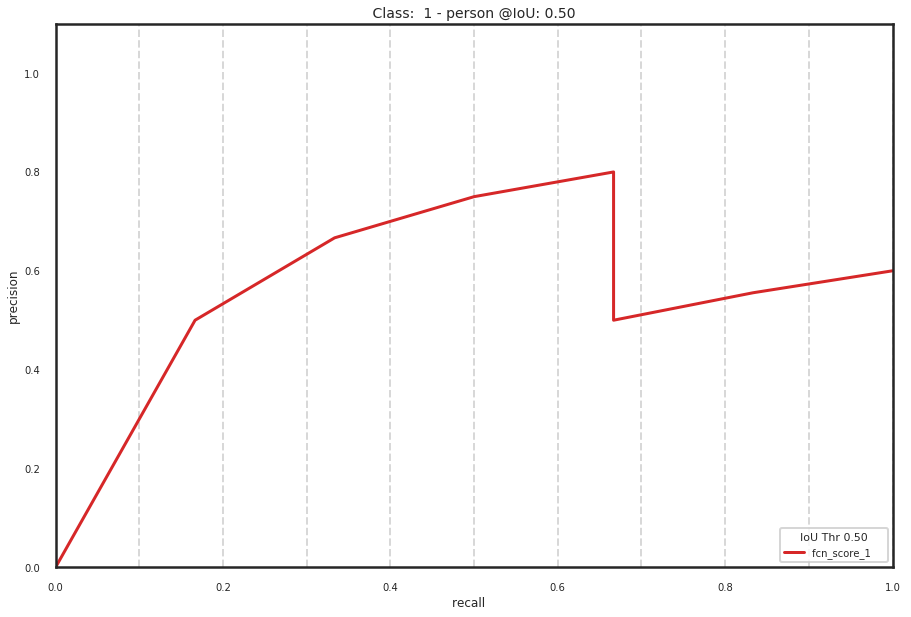

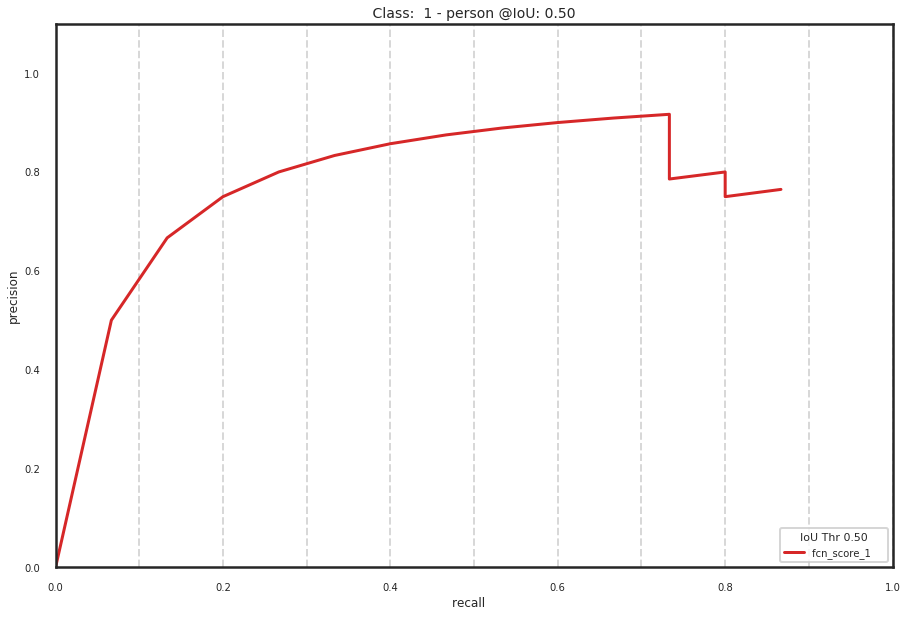

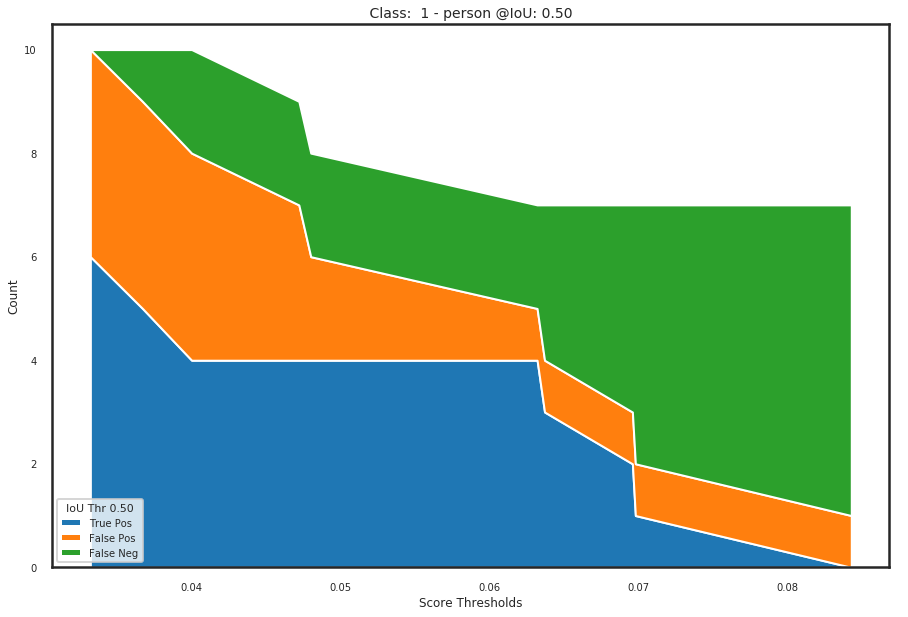

In [101]:
####  PR curve using and subset data
display_pr_info_subset(class_data, class_id, CLASS_NAMES[class_id], scores = [score_key], iou = iou_key)    
display_pr_info_subset(class_data2, class_id, CLASS_NAMES[class_id], scores = [score_key], iou = iou_key)    
cmap2.display_true_false(class_data, class_id, CLASS_NAMES[class_id], scores = [score_key], iou = iou_key, stacked = True)   

####  Display results of  `dev_avg_get_precision_at_iou()` on pr_boxes_subset

In [161]:
print('class     :', class_id)
print('iou_key   :', iou_key)
print('score_key :', score_key)
print('class_data keys: ', class_data.keys())

print()
print('avg precision  : ', round(class_data['avg_prec'],4))
print('recalls        : ', class_data['recalls'].shape[0]   , class_data['recalls'][::-1].round(4))
print('precisions     : ', class_data['precisions'].shape[0], class_data['precisions'][::-1].round(4))
print('thresholds     : ', len(class_data['model_thrs'])    , class_data['model_thrs'][:10])
print('true_pos  : ', len(class_data['tps'])    , class_data['tps'][:10])
print('false_pos : ', len(class_data['fps'])    , class_data['fps'][:10])
print('false_neg : ', len(class_data['fns'])    , class_data['fns'][:10])

print('prec_at_rec  : ', len(class_data['prec_at_rec'])   , [round(i,4) for i in class_data['prec_at_rec']])
for i in class_data:
    print(i, type(class_data[i]))

class     : 3
iou_key   : 0.5
score_key : fcn_score_2
class_data keys:  dict_keys(['avg_prec', 'recalls', 'fps', 'precisions', 'model_thrs', 'fns', 'prec_at_rec', 'tps'])

avg precision  :  0.1818
recalls        :  2 [0.     0.3333]
precisions     :  2 [0.  0.5]
thresholds     :  2 [0.5233, 0.5609]
true_pos  :  2 [1 0]
false_pos :  2 [1 1]
false_neg :  2 [2 3]
prec_at_rec  :  11 [0.5, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
avg_prec <class 'numpy.float64'>
recalls <class 'numpy.ndarray'>
fps <class 'numpy.ndarray'>
precisions <class 'numpy.ndarray'>
model_thrs <class 'list'>
fns <class 'numpy.ndarray'>
prec_at_rec <class 'list'>
tps <class 'numpy.ndarray'>


#### display_true_false()

idx:  0  Score_key:  fcn_score_0 Score Index:  0 color: #ff7f0e
idx:  0  Score_key:  fcn_score_2 Score Index:  0 color: #2ca02c


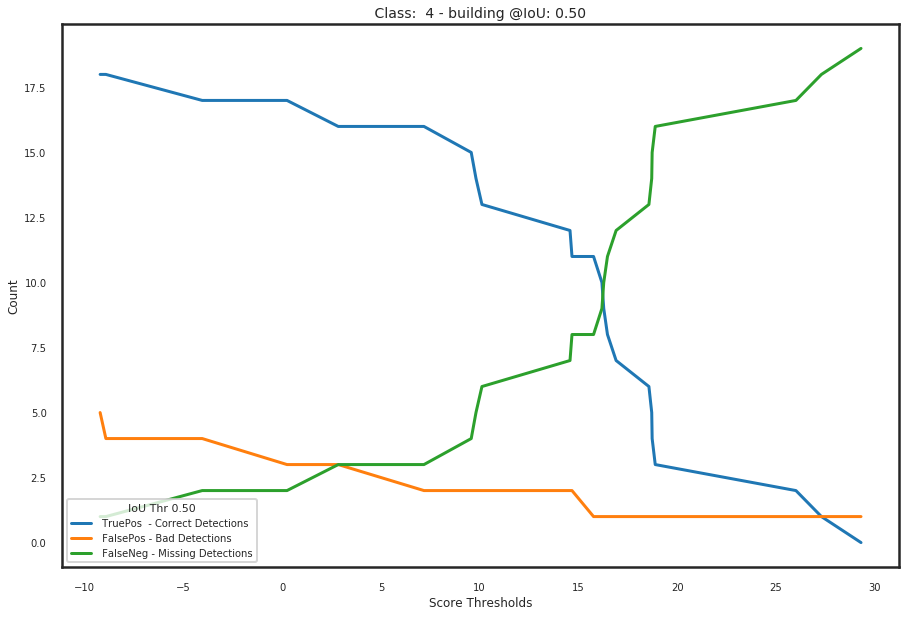

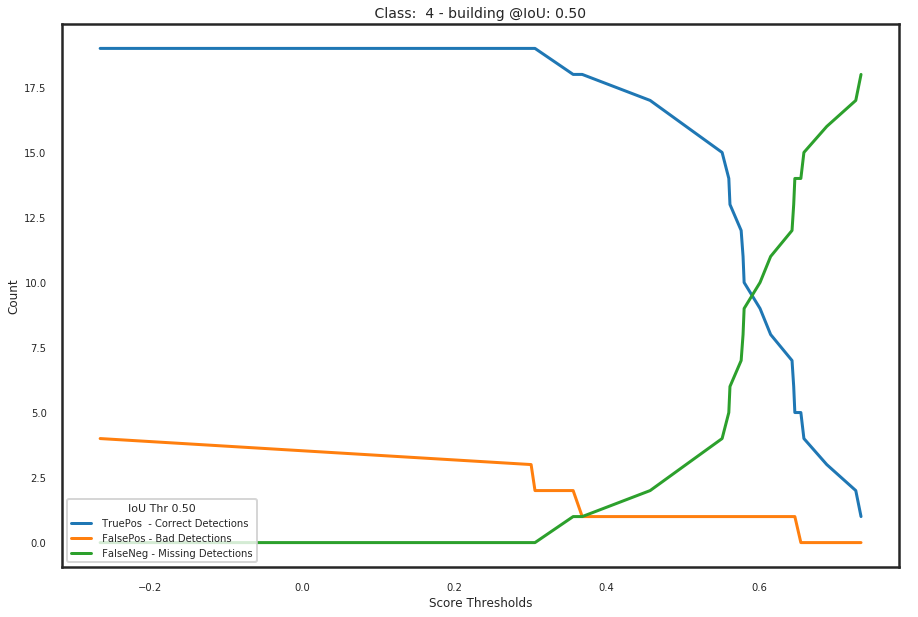

In [389]:
display_true_false(class_data_0, class_id, CLASS_NAMES[class_id], scores = ['fcn_score_0'], iou = iou_key) 
# display_true_false(class_data_1, class_id, CLASS_NAMES[class_id], scores = ['fcn_score_1'], iou = iou_key)    
display_true_false(class_data_2, class_id, CLASS_NAMES[class_id], scores = ['fcn_score_2'], iou = iou_key)   

#### Compute AP for one image 

In [263]:
img_key = 'newshapes_00336'
iou_thr = 0.3
img_gt_boxes       = np.asarray(gt_boxes_subset[5][img_key]['boxes'])
img_gt_boxes       = np.asarray([[]])
print(' gt_bxoes: ', img_gt_boxes.shape)
print('   ',img_gt_boxes)
img_gt_class_ids   = gt_boxes_subset[5][img_key]['class_ids']
img_pred_boxes     = np.asarray(pr_boxes_subset[5][img_key]['boxes'])
print(' pred_boxes: ', img_pred_boxes.shape)
print('   ',img_pred_boxes)
img_pred_class_ids = np.asarray(pr_boxes_subset[5][img_key]['class_ids'])
img_pred_scores    = np.asarray(pr_boxes_subset[5][img_key]['fcn_score_1'])
print('img_pred_class_ids.shape: ', img_pred_class_ids.shape, 'img_pred_scores.shape:',img_pred_scores.shape)
mAP, prec, rec, overlap = utils.compute_ap(img_gt_boxes, img_gt_class_ids, img_pred_boxes, img_pred_class_ids, img_pred_scores, iou_threshold= iou_thr)
print(' mAP :', mAP)
print(' prec:', prec)
print(' rec :', rec)
print(' overlap:', overlap)
plot_precision_recall(0.5, prec, rec)

 gt_bxoes:  (1, 0)
    []
 pred_boxes:  (1, 4)
    [[56. 56. 75. 74.]]
img_pred_class_ids.shape:  (1,) img_pred_scores.shape: (1,)


IndexError: index 2 is out of bounds for axis 1 with size 0

###  Calculate fcn_score_2 on class

####  call `dev_avg_get_precision_at_iou()` on pr_boxes_subset

In [46]:
class_id = 3
iou_key = 0.5
print(' class     :', class_id)
print(' iou_key   :', iou_key)
print(' score_key :', score_key)
# score_key = 'fcn_score_2'
# score_key = 'mrcnn_score_orig'
# class_data_0    = dev_get_avg_precision_at_iou(gt_boxes_subset[class_id], pr_boxes_subset[class_id], iou_thr=iou_key, score_key = 'fcn_score_0', verbose = True)
class_data_2_A    = dev_get_avg_precision_at_iou(gt_boxes_subset[class_id], pr_boxes_subset[class_id], iou_thr=iou_key, score_key = 'fcn_score_2', verbose=True)

 class     : 3
 iou_key   : 0.5
 score_key : fcn_score_2
 model_scores_map   : 5
 sorted_model_scores: 5  ordered list of unqiue scores : [0.3394, 0.4865, 0.5186, 0.6072, 0.637]
sorted_model_scores : [0.3394, 0.4865, 0.5186, 0.6072, 0.637]
{ 0.3394: ['newshapes_00074'],
  0.4865: ['newshapes_00076'],
  0.5186: ['newshapes_00077'],
  0.6072: ['newshapes_00078'],
  0.637: ['newshapes_00075']}

sorted_model_scores[:-1] : [0.3394, 0.4865, 0.5186, 0.6072]
 gt_boxes keys      : 5 ['newshapes_00078', 'newshapes_00075', 'newshapes_00077', 'newshapes_00076', 'newshapes_00074']

image_id :  newshapes_00074
  Before Sort - scores: [0.9999]   fcn_score_2      : [0.3394]   [[7.0, 9.0, 19.0, 21.0]]
  After Sort  - scores: [0.3394]   fcn_score_2      : [0.3394]   [[7.0, 9.0, 19.0, 21.0]]

image_id :  newshapes_00075
  Before Sort - scores: [1.0]   fcn_score_2      : [0.637]   [[13.0, 78.0, 30.0, 94.0]]
  After Sort  - scores: [0.637]   fcn_score_2      : [0.637]   [[13.0, 78.0, 30.0, 94.0]]

image_id

####  Display results of  `dev_avg_get_precision_at_iou()` on pr_boxes_subset

In [13]:
print('class     :', class_id)
print('iou_key   :', iou_key)
print('score_key :', score_key)
print('class_data keys: ', class_data.keys())

print()
print('avg precision  : ', round(class_data['avg_prec'],4))
print('recalls        : ', class_data['recalls'].shape[0]   , class_data['recalls'][::-1].round(4))
print('precisions     : ', class_data['precisions'].shape[0], class_data['precisions'][::-1].round(4))
print('thresholds     : ', len(class_data['model_thrs'])    , class_data['model_thrs'][:10])
print('true_pos  : ', len(class_data['tps'])    , class_data['tps'][:10])
print('false_pos : ', len(class_data['fps'])    , class_data['fps'][:10])
print('false_neg : ', len(class_data['fns'])    , class_data['fns'][:10])

print('prec_at_rec  : ', len(class_data['prec_at_rec'])   , [round(i,4) for i in class_data['prec_at_rec']])
for i in class_data:
    print(i, type(class_data[i]))

class     : 3
iou_key   : 0.5
score_key : fcn_score_2


NameError: name 'class_data' is not defined

####  PR curve using and subset data

Disp scores:  ['fcn_score_0']
precisions: [0.     0.5    0.6667 0.75   0.8    0.8333 0.8571 0.875  0.8889 0.9
 0.9091 0.9167 0.8462 0.8571 0.8667 0.875  0.8824 0.8889 0.8421 0.85
 0.8095 0.8182 0.7826]
recalls   : [0.     0.0526 0.1053 0.1579 0.2105 0.2632 0.3158 0.3684 0.4211 0.4737
 0.5263 0.5789 0.5789 0.6316 0.6842 0.7368 0.7895 0.8421 0.8421 0.8947
 0.8947 0.9474 0.9474]
idx:  0  Score_key:  fcn_score_0 Score Index:  0 color: #ff7f0e


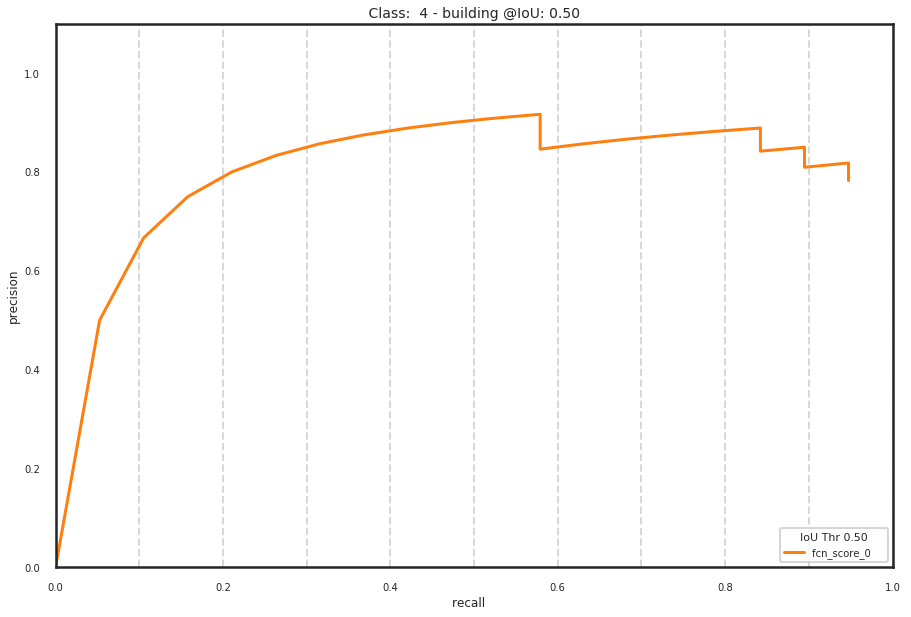

In [399]:
# iou_key  = 0.5
# disp_scores = ['mrcnn_score_orig', 'mrcnn_score_2', 'fcn_score_2']
class_precs = display_pr_info_subset(class_data_0, class_id, CLASS_NAMES[class_id], scores = ['fcn_score_0'], iou = iou_key)    
# class_precs = display_pr_info_subset(class_data_1, class_id, CLASS_NAMES[class_id], scores = ['fcn_score_1'], iou = iou_key) 

### build `all_data_subset`  for sampling from `gt_boxes_subset` and `pr_boxes_subset`

In [73]:
cls_id = 3
iou_thr = 0.50
score_key = 'fcn_score_2'

# del class_data, outp, all_data_subset

all_data_subset = cmap.build_mAP_data_structure_by_class(gt_boxes_subset, pr_boxes_subset, class_ids = [3], scores=['fcn_score_2'], iou_thresholds = [0.5])

print('all_data_subset keys    : ', all_data_subset.keys())   
for i in  all_data_subset.keys():
    print('all_data_subset[',i,'] keys:', all_data_subset[i].keys())

Build mAP information for classes:  [3]  and scores  ['fcn_score_2']
class_id:   3  
all_data_subset keys    :  dict_keys([3])
all_data_subset[ 3 ] keys: dict_keys(['fcn_score_2'])


In [ ]:
print('alldata[3].keys() : ', all_data_subset[3].keys())
print('all_data[3][fcn_score_1][0.5] keys: ', all_data_subset[3]['fcn_score_2'][0.5].keys())
# print(all_data[3]['fcn_score_1'][0.5].keys())

# class_precs = display_pr_info_one_class(all_data[class_id], class_id, class_names[class_id], scores = disp_scores, iou = iou)   